# Hyperskill java dataset analysis

## Settings

In [1]:
import pandas as pd
import numpy as np

from typing import List, Dict
import string
import sys
import os

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style='whitegrid', font_scale=2, rc={"lines.linewidth": 5, "lines.markersize": 15})

In [2]:
import importlib
module_path = os.path.abspath(os.path.join('../../../../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from analysis.src.python.data_analysis.analysis.attrs import draw_base_attrs

from analysis.src.python.data_analysis.stat_test.iticse_2022.rq_stat_tests import run_stat_tests

from analysis.src.python.data_analysis.analysis.statistics import \
    get_submissions_percent_by_issues, get_client_stats, \
    get_submissions_series_dynamic_by_feature, get_submissions_series_issues_dynamic, \
    get_top_issues, get_top_issues_categories, get_submissions_percent_by_feature, \
    get_submissions_series_client_dynamic

from analysis.src.python.data_analysis.analysis.plots import \
    draw_compare, draw_heatmap_compare, \
    draw_hist_plots, draw_count_plots, \
    draw_stat_plot, draw_client_dynamic_graph

/Users/tiginamaria1999/PycharmProjects/hyperstyle-analyze/venv/src/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
def merge_dfs(df_left: pd.DataFrame, df_right: pd.DataFrame, left_on: str, right_on: str) -> pd.DataFrame:
    df_merged = pd.merge(df_left, df_right, left_on=left_on, right_on=right_on, suffixes=('', '_extra'))
    df_merged.drop(df_merged.filter(regex='_extra$').columns.tolist(), axis=1, inplace=True)
    return df_merged

In [4]:
def get_tag(count, scope_borders, labels) -> str:
    if count <= scope_borders[0]:
        return labels[0]
    if count >= scope_borders[1]:
        return labels[2]
    return labels[1]

### Set path to following csv files (or use preset default)

In [5]:
data_directory_path = '/Users/tiginamaria1999/PycharmProjects/hyperstyle-analyze/analysis/src/resources/data/java_new'
steps_file_path = os.path.join(data_directory_path, 'steps_prep.csv')
topics_file_path = os.path.join(data_directory_path, 'topics_prep.csv')

submissions_file_path = os.path.join(data_directory_path, 'solutions_java11_prep.csv')
submissions_stats_file_path = os.path.join(data_directory_path, 'solutions_java11_prep_stats.csv')

hyperstyle_issues_stats_file_path = os.path.join(data_directory_path, 'solutions_java11_prep_hyperstyle_filtered_issues_stats.csv')
hyperstyle_issues_classes_file_path = os.path.join(data_directory_path, 'hyperstyle_issues.csv')


### Color pallents of main attributes

difficulty
easy -> medium -> hard


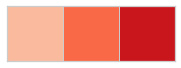

complexity
shallow -> middle -> deep


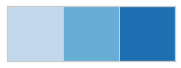

scope
small -> medium -> wide


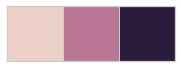

level
low -> average -> high


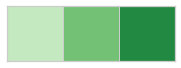

client
idea -> web


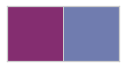

In [6]:
draw_base_attrs()

# Steps and Topics
**Step** - is a task where user is asked to write some code. Main attributes:
* `id` - *identifier of step*
* `seconds_to_complete` - *estimated secons to complete (calculated as average from all successful sumbissions)*
* `solved_by` - *number of successful sumbissions*
* `success_rate` - *number of successful sumbissions dvided by total number of sumbissions*
* `topic_id` - *id of topic step is related to. By this id we can define step's `depth` and `prerequisites_count` by related topic's `depth` and `prerequisites_count`*
* `difficulty` - [`easy`, `medium`, `hard`] *according to success_rate [sr<=0.33, 0.33<sr<0.66, sr>=0.66]*. This value is defeined in planform and calculated there for each step according this rule.
* `complexity` - [`shallow`, `middle`, `deep`] *according to topic depth [d<=2, 2<d<5, d>=5]*. Borders was selected as 0.25 and 0.75 quantiles.
* `scope` - [`small`, `medium`, `wide`] *according to prerequisites_count [pc<=6, 6<pc<42, pc>=42]*. Borders was selected as 0.25 and 0.75 quantiles.

**Topic** - is a theme or knowledge area. Every step is related to some topic. Main attributes:
* `id` - *identifier of step*
* `prerequisites` - *topics ids which must be leared before*
* `depth` - *the depth in topics tree*
* `prerequisites_count` - *number of all prerequisite topics in topics tree (subtree size)*

In [7]:
df_steps = pd.read_csv(steps_file_path)
df_steps[['id', 'success_rate', 'depth', 'prerequisites_count']].describe(percentiles=[0.25, 0.5, 0.75])

id  success_rate      depth  prerequisites_count
count    415.000000    415.000000  415.00000           415.000000
mean    4473.072289      0.557455    3.60000            23.168675
std     3415.102166      0.175283    1.88408            19.223337
min     1926.000000      0.156000    0.00000             0.000000
25%     2325.500000      0.421000    2.00000             6.000000
50%     2835.000000      0.563882    3.00000            18.000000
75%     4940.500000      0.695500    5.00000            42.000000
max    15239.000000      0.929000    8.00000            84.000000

In [8]:
df_steps['complexity'] = df_steps['depth'].apply(get_tag, scope_borders=[2, 5], labels=['shallow', 'middle', 'deep'])
# df_steps['scope'] = df_steps['prerequisites_count'].apply(get_tag, scope_borders=[6, 42], labels=['small', 'medium', 'wide'])
# df_steps.to_csv(steps_file_path)

## Steps statistics description

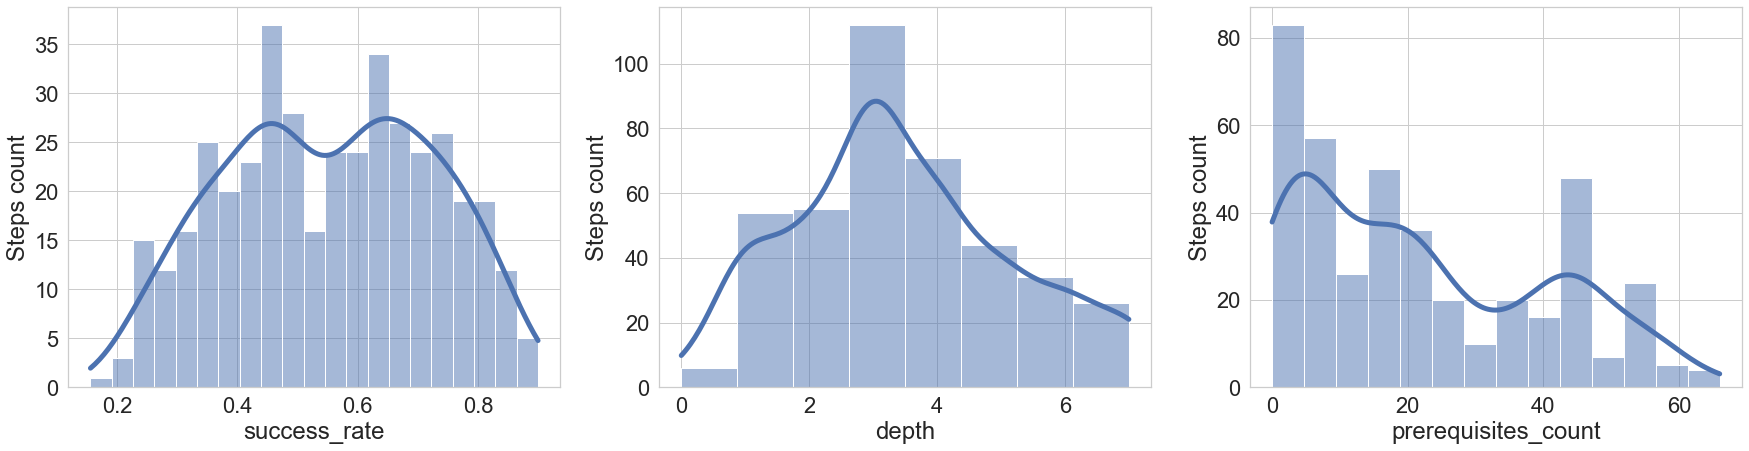

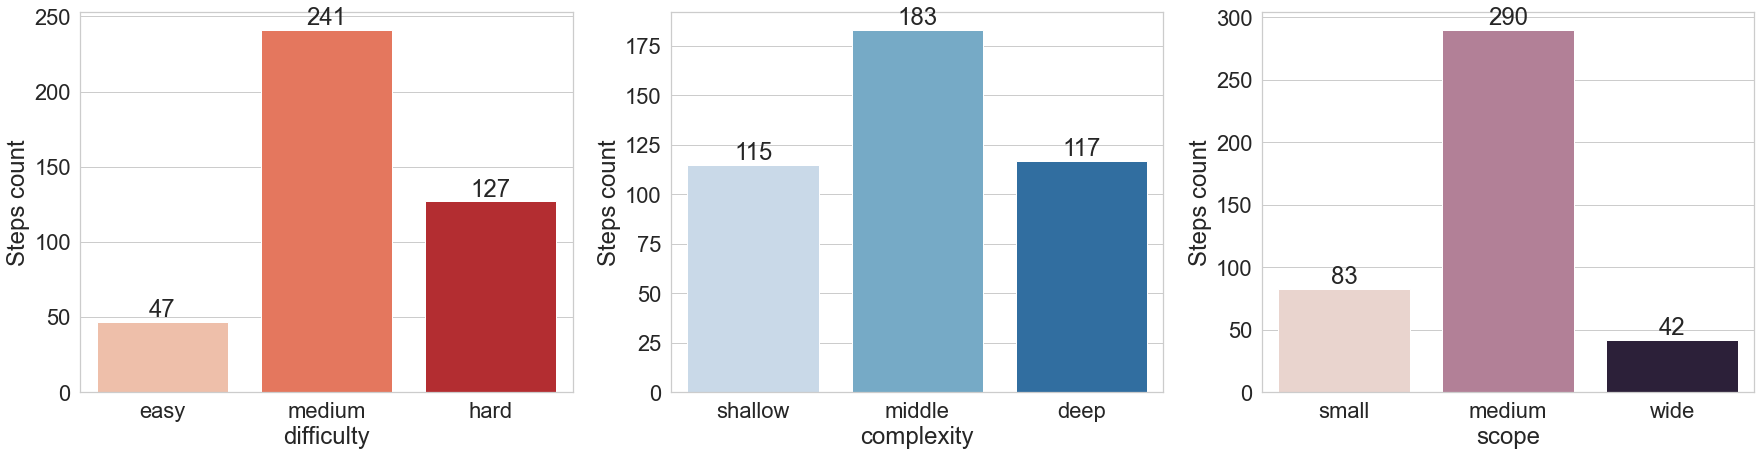

In [9]:
draw_hist_plots(df_steps, ['success_rate', 'depth', 'prerequisites_count'], 
                columns=3, log_scale=False, kde=True, y_label='Steps count')
draw_count_plots(df_steps, ['difficulty', 'complexity', 'scope'], 
                 columns=3, y_label='Steps count')

## Submissions

Submission is an attempt of user to pass step's task. One user can do several attempts to pass one step.

* `id` - *identifier of submission*
* `step_id` - *identifier of step*
* `user_id` - *identifier of user*
* `group` - *number of submission series (group of submissions on one step by one user)*
* `attempt` - *number of attempt inside submission series*
* `total_attempt` - *number of attempts is submission series*
* `base_client` - `[web, idea, ide, IdeaEdu, Idea]` *interface from which submission was submitted*
* `client` - `[web, idea]` *interface group from which submission was submitted*

In [10]:
df_submissions = pd.read_csv(submissions_file_path)
df_submissions.describe().astype('int32')

id  step_id  sync_counter  user_id    group  attempt  \
count   1131229  1131229       1131229  1131229  1131229  1131229   
mean   42792425     3554             8     8385   545343        5   
std     7941636     2406             1     7852   307704       42   
min    29381342     1926             1        0        0        1   
25%    35695524     2247             7     2140   259941        1   
50%    42760043     2507             8     5806   567495        1   
75%    49852455     3750             9    12960   819438        2   
max    56397779    15239            22    82397  1055200     1122   

       total_attempts  
count         1131229  
mean                9  
std                74  
min                 1  
25%                 1  
50%                 1  
75%                 2  
max              1122

In [11]:
total_attempt_count = {
    'total_attempts': [],
    'count<=': [],
    'count>': [],
    'percent<=': [],
    'percent>': [],
}


for total_attempt in sorted(df_submissions['total_attempts'].unique()):
    total_attempt_count['total_attempts'].append(total_attempt)
    count = df_submissions[df_submissions['total_attempts'] <= total_attempt].shape[0]
    total_attempt_count['count<='].append(count)
    total_attempt_count['count>'].append(df_submissions.shape[0] - count)
    total_attempt_count['percent<='].append(count / df_submissions.shape[0])
    total_attempt_count['percent>'].append((df_submissions.shape[0] - count) / df_submissions.shape[0])

df_total_attempt_count = pd.DataFrame.from_dict(total_attempt_count)
df_total_attempt_count.to_csv('java/total_attempts.csv', index=False)
df_total_attempt_count

total_attempts  count<=  count>  percent<=  percent>
0                 1   671688  459541   0.593768  0.406232
1                 2   893120  238109   0.789513  0.210487
2                 3   995540  135689   0.880052  0.119948
3                 4  1046248   84981   0.924877  0.075123
4                 5  1073018   58211   0.948542  0.051458
..              ...      ...     ...        ...       ...
100             595  1127152    4077   0.996396  0.003604
101             788  1127940    3289   0.997093  0.002907
102            1068  1129008    2221   0.998037  0.001963
103            1099  1130107    1122   0.999008  0.000992
104            1122  1131229       0   1.000000  0.000000

[105 rows x 5 columns]

In [39]:
df_submissions = df_submissions[df_submissions['total_attempts'] <= 5]

### Sumbission client distriburion
In platform student can use `web` indeface for typing code or `ide`.
This plot shows that around 2/3 of the sumbisssions are done in `web` indeface. 

<AxesSubplot:xlabel='client', ylabel='Count'>

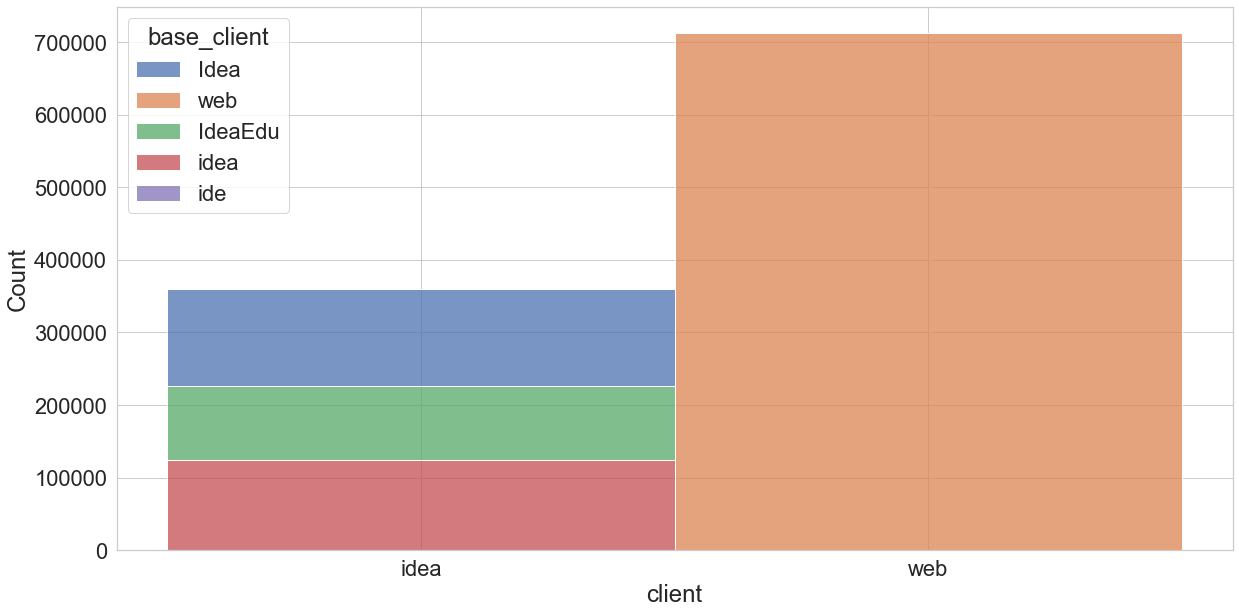

In [40]:
fig, ax = plt.subplots(figsize=((20, 10)))
sns.histplot(data=df_submissions, x='client', hue='base_client', multiple='stack')

## Submission statistics
* `code_lines_count` - number of code lines
* `code_symbols_count` - number of code symbols
* `hyperstyle_issues_count` - number of raw issues
* `hyperstyle_issues_by_code_lines` - number of raw issues divided by code lines
* `qodana_issues_by_code_lines` - number of qodana issues divided by code lines

In [41]:
df_submissions_stats = pd.read_csv(submissions_stats_file_path)
df_submissions_stats = merge_dfs(df_submissions_stats, df_submissions, left_on='id', right_on='id')
df_submissions_stats.describe().astype('int32')

id  code_lines_count  code_symbols_count  step_id  sync_counter  \
count   1073018           1073018             1073018  1073018       1073018   
mean   42755199                19                 528     3542             8   
std     7919587                19                 509     2391             1   
min    29381342                 1                  90     1926             2   
25%    35701302                11                 262     2265             7   
50%    42705906                15                 413     2507             8   
75%    49802164                22                 617     3750             9   
max    56397779              2366               81399    15239            22   

       user_id    group  attempt  total_attempts  
count  1073018  1073018  1073018         1073018  
mean      8454   548565        1               1  
std       7879   307715        0               1  
min          0        0        1               1  
25%       2284   272812        1               1  
50%       5888   573327        1               1  
75%      13032   820907        1               2  
max      82397  1055200        5               5

In [42]:
df_submissions_stats = merge_dfs(df_submissions_stats, df_steps[['id', 'complexity', 'difficulty', 'scope']], 
                                 left_on='step_id', right_on='id')

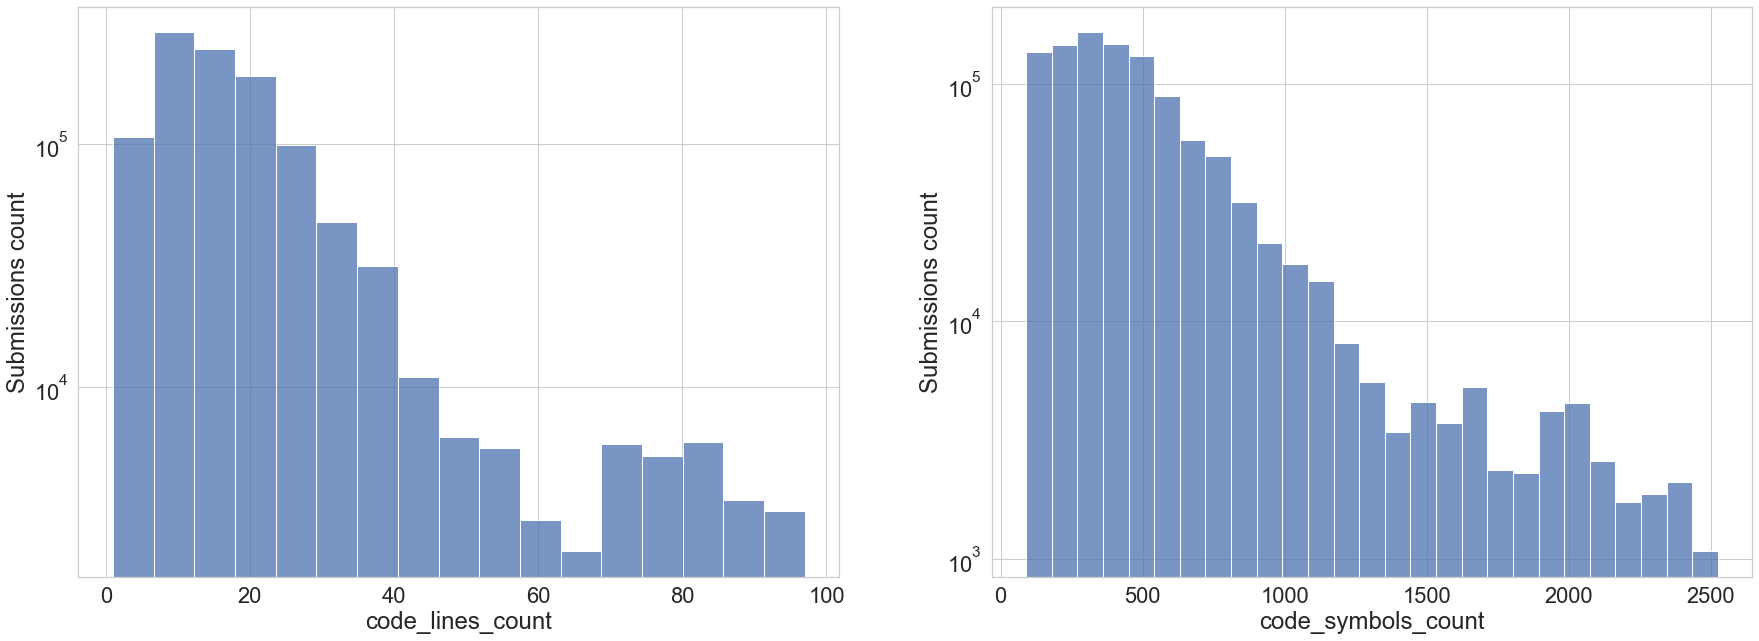

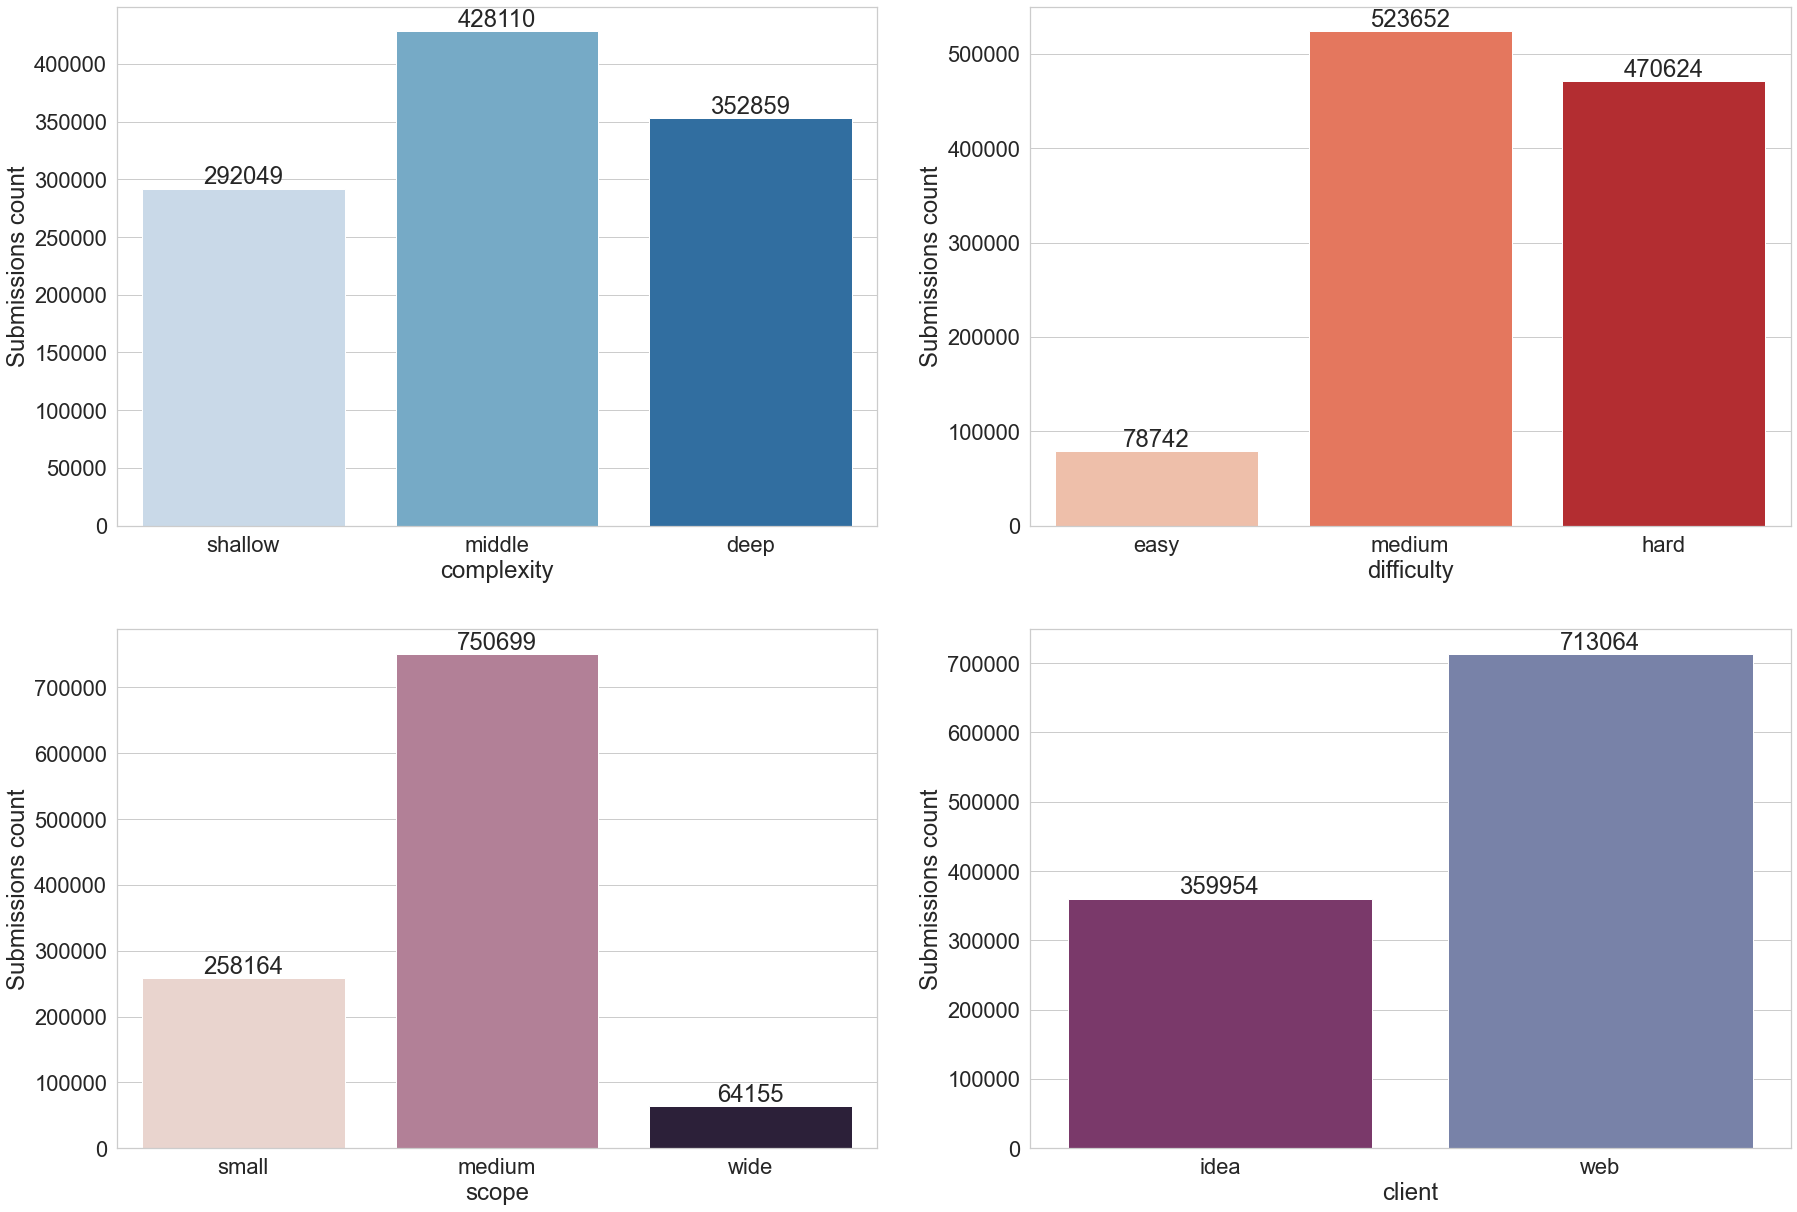

In [43]:
draw_hist_plots(df_submissions_stats, ['code_lines_count', 'code_symbols_count'], 
                columns=2, log_scale=(False, True), y_label='Submissions count')

draw_count_plots(df_submissions_stats, ['complexity', 'difficulty', 'scope', 'client'], y_label='Submissions count')

# Hyperstyle code quality issue analysis

We invoked Hyperstyle code quality tool on each submissions and got a code quality report with list of detected issues in submission `hypertyle_issues`. Hyperstyle issue is code quality error which has `name` e.x. MagicNumberCheck and `category` e.x. INFO. 

In a preprocessing part for each submission we calcaulated number of hypertyle issues of each name.

In [44]:
def draw_issues(df: pd.DataFrame, df_issues: pd.DataFrame, blur_issues, base_dir: str):
    os.makedirs(base_dir, exist_ok=True)
    
    for attr in ['difficulty', 'complexity', 'client', 'scope']:
        df_stats = get_submissions_percent_by_issues(df, df_issues, attr, sort=False)
        df_stats.to_csv(os.path.join(base_dir, f'issues_stats_{attr}.csv'), index=False)
        draw_compare(df_stats, 
                     'issue', 
                     attr, blur_issues, 
                     save_path=os.path.join(base_dir, f'issues_stats_{attr}.pdf'))

In [45]:
df_hyperstyle_issues_stats = pd.read_csv(hyperstyle_issues_stats_file_path)
df_hyperstyle_issues_stats = merge_dfs(df_hyperstyle_issues_stats, df_submissions_stats, left_on='id', right_on='id')
df_hyperstyle_issues_stats.describe()

id  WhitespaceAroundCheck  MagicNumberCheck  \
count  1.073018e+06           1.073018e+06      1.073018e+06   
mean   4.275520e+07           6.593841e-01      5.512526e-01   
std    7.919588e+06           2.771475e+00      1.363369e+00   
min    2.938134e+07           0.000000e+00      0.000000e+00   
25%    3.570130e+07           0.000000e+00      0.000000e+00   
50%    4.270591e+07           0.000000e+00      0.000000e+00   
75%    4.980216e+07           0.000000e+00      0.000000e+00   
max    5.639778e+07           2.320000e+02      2.890000e+02   

       IndentationCheck  WhitespaceAfterCheck  UnnecessaryParenthesesCheck  \
count      1.073018e+06          1.073018e+06                 1.073018e+06   
mean       2.569966e-01          1.677437e-01                 6.350313e-02   
std        1.558073e+00          9.857262e-01                 4.610953e-01   
min        0.000000e+00          0.000000e+00                 0.000000e+00   
25%        0.000000e+00          0.000000e+00                 0.000000e+00   
50%        0.000000e+00          0.000000e+00                 0.000000e+00   
75%        0.000000e+00          0.000000e+00                 0.000000e+00   
max        2.130000e+02          6.330000e+02                 4.800000e+01   

       UnusedLocalVariable  NeedBracesCheck  ParenPadCheck  \
count         1.073018e+06     1.073018e+06   1.073018e+06   
mean          5.814068e-02     3.642809e-02   3.173106e-02   
std           5.804384e-01     2.944289e-01   3.275794e-01   
min           0.000000e+00     0.000000e+00   0.000000e+00   
25%           0.000000e+00     0.000000e+00   0.000000e+00   
50%           0.000000e+00     0.000000e+00   0.000000e+00   
75%           0.000000e+00     0.000000e+00   0.000000e+00   
max           1.000000e+01     3.000000e+01   1.000000e+02   

       LocalVariableNameCheck  ...  ClassCastExceptionWithToArray  \
count            1.073018e+06  ...                   1.073018e+06   
mean             3.236199e-02  ...                   9.319508e-07   
std              3.335725e-01  ...                   9.653760e-04   
min              0.000000e+00  ...                   0.000000e+00   
25%              0.000000e+00  ...                   0.000000e+00   
50%              0.000000e+00  ...                   0.000000e+00   
75%              0.000000e+00  ...                   0.000000e+00   
max              1.200000e+01  ...                   1.000000e+00   

           GodClass  code_lines_count  code_symbols_count       step_id  \
count  1.073018e+06      1.073018e+06        1.073018e+06  1.073018e+06   
mean   9.319508e-07      1.966040e+01        5.285942e+02  3.542354e+03   
std    9.653760e-04      1.917654e+01        5.092620e+02  2.391422e+03   
min    0.000000e+00      1.000000e+00        9.000000e+01  1.926000e+03   
25%    0.000000e+00      1.100000e+01        2.620000e+02  2.265000e+03   
50%    0.000000e+00      1.500000e+01        4.130000e+02  2.507000e+03   
75%    0.000000e+00      2.200000e+01        6.170000e+02  3.750000e+03   
max    1.000000e+00      2.366000e+03        8.139900e+04  1.523900e+04   

       sync_counter       user_id         group       attempt  total_attempts  
count  1.073018e+06  1.073018e+06  1.073018e+06  1.073018e+06    1.073018e+06  
mean   8.480282e+00  8.454876e+03  5.485654e+05  1.319415e+00    1.638830e+00  
std    1.663537e+00  7.879070e+03  3.077158e+05  6.894426e-01    1.002273e+00  
min    2.000000e+00  0.000000e+00  0.000000e+00  1.000000e+00    1.000000e+00  
25%    7.000000e+00  2.284000e+03  2.728122e+05  1.000000e+00    1.000000e+00  
50%    8.000000e+00  5.888000e+03  5.733270e+05  1.000000e+00    1.000000e+00  
75%    9.000000e+00  1.303200e+04  8.209078e+05  1.000000e+00    2.000000e+00  
max    2.200000e+01  8.239700e+04  1.055200e+06  5.000000e+00    5.000000e+00  

[8 rows x 179 columns]

During the analysis we desided to filter out issues with `INFO` and `CODE_STYLE` categories and focude on `BEST_PRACTICES `and `ERROR_PRONE`.

In [46]:
df_hyperstyle_issues = pd.read_csv(hyperstyle_issues_classes_file_path)

hyperstyle_issues_info_names = [issue['name'] for _, issue in df_hyperstyle_issues.iterrows() 
                                if issue['category'] == 'INFO']

hyperstyle_issues_ignore_names = [issue['name'] for _, issue in df_hyperstyle_issues.iterrows() 
                                   if issue['category'] == 'INFO' or issue['category'] == 'CODE_STYLE']

hyperstyle_issues_names = [issue['name'] for _, issue in df_hyperstyle_issues.iterrows() 
                            if issue['name'] not in hyperstyle_issues_ignore_names]

In [47]:
get_top_issues_categories(df_hyperstyle_issues_stats, df_hyperstyle_issues)

category    count     ratio
1      CODE_STYLE  1520378  1.416918
4            INFO   603239  0.562189
0  BEST_PRACTICES   155635  0.145044
3     ERROR_PRONE    22254  0.020740
2      COMPLEXITY      596  0.000555

In one submission can be several issues with one name. But it is simplier to analyse only the presence/absence on issue in solution so in `_unique` dataframe we replace issue count to 0/1 value (0-no such issue in this submission, 1-one ore more issues are detected in this submission).

In [48]:
# Unique means a flag: 1 if issue presented in submission, 0 otherwise
df_hyperstyle_issues_stats_unique = df_hyperstyle_issues_stats.copy()
for issue_name in df_hyperstyle_issues['name'].values:
    df_hyperstyle_issues_stats_unique[issue_name] = df_hyperstyle_issues_stats_unique[issue_name] \
        .apply(lambda x: min(x, 1))

### List and analysis of ignored (filtered) issues (with CODE_STYLE and INFO categories)

In [49]:
BASE_PATH = os.path.join('java', 'hyperstyle')
IGNORE_ISSUES_STATS_PATH = os.path.join(BASE_PATH, 'ignore_issues_stats')
ISSUES_STATS_PATH = os.path.join(BASE_PATH, 'issues_stats')

FIRST_ATTEMPT_STATS_PATH = os.path.join(BASE_PATH, 'first_attempt_stats')
LAST_ATTEMPT_STATS_PATH = os.path.join(BASE_PATH, 'last_attempt_stats')
FIRST_LAST_ATTEMPT_STATS_PATH = os.path.join(BASE_PATH, 'first_last_attempt_stats')

ISSUES_DYNAMIC_STATS_PATH = os.path.join(BASE_PATH, 'issues_dynamic_stats')


os.makedirs(BASE_PATH, exist_ok=True)
os.makedirs(IGNORE_ISSUES_STATS_PATH, exist_ok=True)
os.makedirs(ISSUES_STATS_PATH, exist_ok=True)
os.makedirs(FIRST_ATTEMPT_STATS_PATH, exist_ok=True)
os.makedirs(LAST_ATTEMPT_STATS_PATH, exist_ok=True)
os.makedirs(FIRST_LAST_ATTEMPT_STATS_PATH, exist_ok=True)
os.makedirs(ISSUES_DYNAMIC_STATS_PATH, exist_ok=True)

In [50]:
df_hyperstyle_ignore_issues_top = get_top_issues(df_hyperstyle_issues_stats_unique, 
                                                 df_hyperstyle_issues, 
                                                 20, 
                                                 hyperstyle_issues_names)
df_hyperstyle_ignore_issues_top.to_csv(os.path.join(IGNORE_ISSUES_STATS_PATH, f'top_issues.csv'), index=False)
df_hyperstyle_ignore_issues_top

name   count    category  \
1                    MagicNumberCheck  257823        INFO   
0               WhitespaceAroundCheck  150730  CODE_STYLE   
3                WhitespaceAfterCheck   90479  CODE_STYLE   
2                    IndentationCheck   73856  CODE_STYLE   
4         UnnecessaryParenthesesCheck   29420  CODE_STYLE   
6                     NeedBracesCheck   23157  CODE_STYLE   
7                       ParenPadCheck   21149  CODE_STYLE   
10           CommentsIndentationCheck   18281  CODE_STYLE   
9                     RightCurlyCheck   16869  CODE_STYLE   
11            NoWhitespaceBeforeCheck   14093  CODE_STYLE   
8              LocalVariableNameCheck   13811  CODE_STYLE   
15                    LineLengthCheck   11837  CODE_STYLE   
12                     LeftCurlyCheck   11491  CODE_STYLE   
19  MultipleVariableDeclarationsCheck   10230  CODE_STYLE   
13                 UselessParentheses    9896  CODE_STYLE   
16            EmptyLineSeparatorCheck    8342  CODE_STYLE   
17         AvoidLiteralsInIfCondition    8284        INFO   
21             NoWhitespaceAfterCheck    7570  CODE_STYLE   
20                MethodParamPadCheck    6816  CODE_STYLE   
26                ArrayTypeStyleCheck    4581  CODE_STYLE   

                                                 text difficulty  \
1   Found a magic number. The use of unnamed magic...       EASY   
0                '{' is not preceded with whitespace.       EASY   
3                 'if' is not followed by whitespace.       EASY   
2   'for' has incorrect indentation level 12, expe...       EASY   
4          Unnecessary parentheses around expression.       EASY   
6                      'if' construct must use '{}'s.       EASY   
7                      '(' is followed by whitespace.       EASY   
10  Block comment has incorrect indentation level ...       EASY   
9   '}' at column 9 should be on the same line as ...       EASY   
11                   ';' is preceded with whitespace.       EASY   
8   Name 'C' must use camelCase (checked pattern '...       EASY   
15  Too long line. Try to split it into smaller li...       EASY   
12     '{' at column 16 should have line break after.       EASY   
19  Each variable declaration must be in its own s...       EASY   
13                               Useless parentheses.       EASY   
16  'METHOD_DEF' should be separated from previous...       EASY   
17  Avoid using magic numbers in Conditional State...       EASY   
21                     '{' is followed by whitespace.       EASY   
20                   '(' is preceded with whitespace.       EASY   
26                Array brackets at illegal position.       EASY   

                                          code_sample     ratio  
1   import java.util.Optional;\n\npublic class Mai...  0.240278  
0   import java.util.Scanner;\nclass Main {\n    p...  0.140473  
3   import java.util.Scanner;\nclass Main {\n    p...  0.084322  
2   import java.util.*;\nclass Main {\n    public ...  0.068830  
4   import java.util.*;\nimport java.util.stream.C...  0.027418  
6   import java.util.Scanner;\n\npublic class Main...  0.021581  
7   import java.util.Scanner;\n\nclass Main {\n   ...  0.019710  
10  public class Main {\n\n    public static void ...  0.017037  
9   import java.util.Scanner;\n\nclass FixingArith...  0.015721  
11  import java.util.Scanner;\nimport java.util.Ar...  0.013134  
8   import java.util.Scanner;\n\nclass Main {\n   ...  0.012871  
15  import java.util.*;\n\npublic class Main {\n  ...  0.011032  
12  import java.util.*;\n\npublic class Main {\n\n...  0.010709  
19  import java.time.LocalDateTime;\nimport java.u...  0.009534  
13  import java.util.Scanner;\nclass Main {\n    p...  0.009223  
16  import java.util.Scanner;\n\npublic class Main...  0.007774  
17  \nimport java.util.*; \nimport java.io.*; \n  ...  0.007720  
21  import java.util.*;\n\npublic class Main {\n\n...  0.007055  
20  import java.util.*;\n\npublic class Main {\n  ...  0.006352  
26

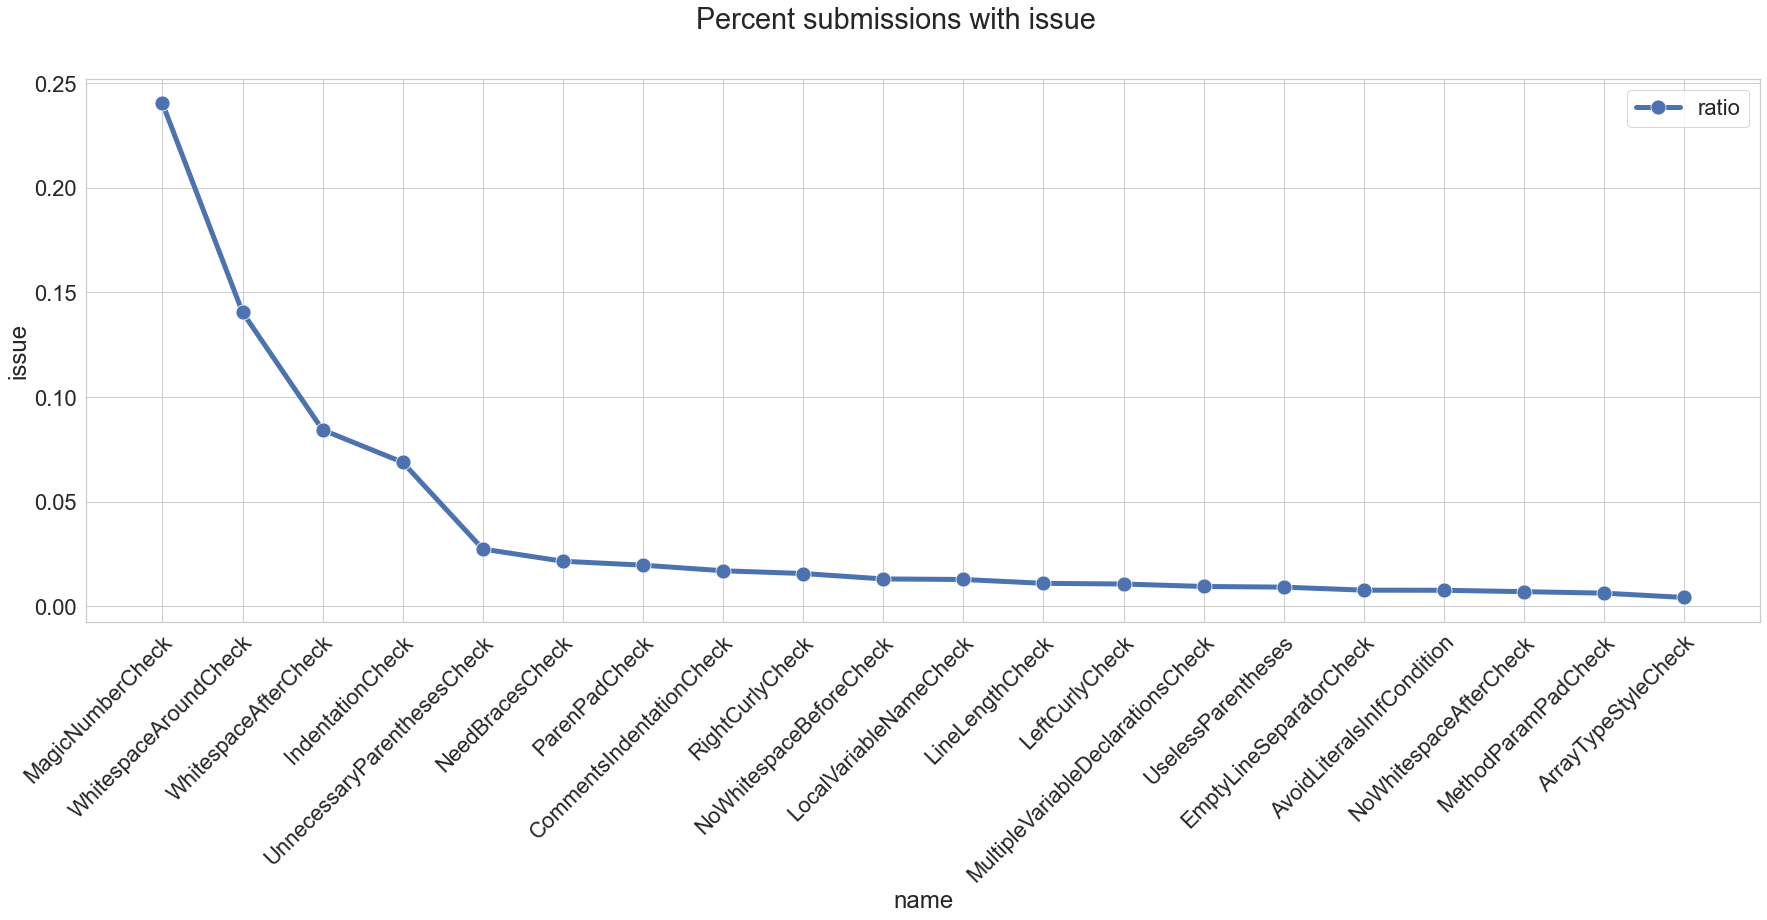

In [51]:
draw_compare(df_hyperstyle_ignore_issues_top, 'name', ['ratio', ['ratio']], 
             y_label='issue', 
             title='Percent submissions with issue', 
             save_path=os.path.join(IGNORE_ISSUES_STATS_PATH, f'top_issues.pdf'))

### Persent of submissions which contains each code quality `ignored` issue 

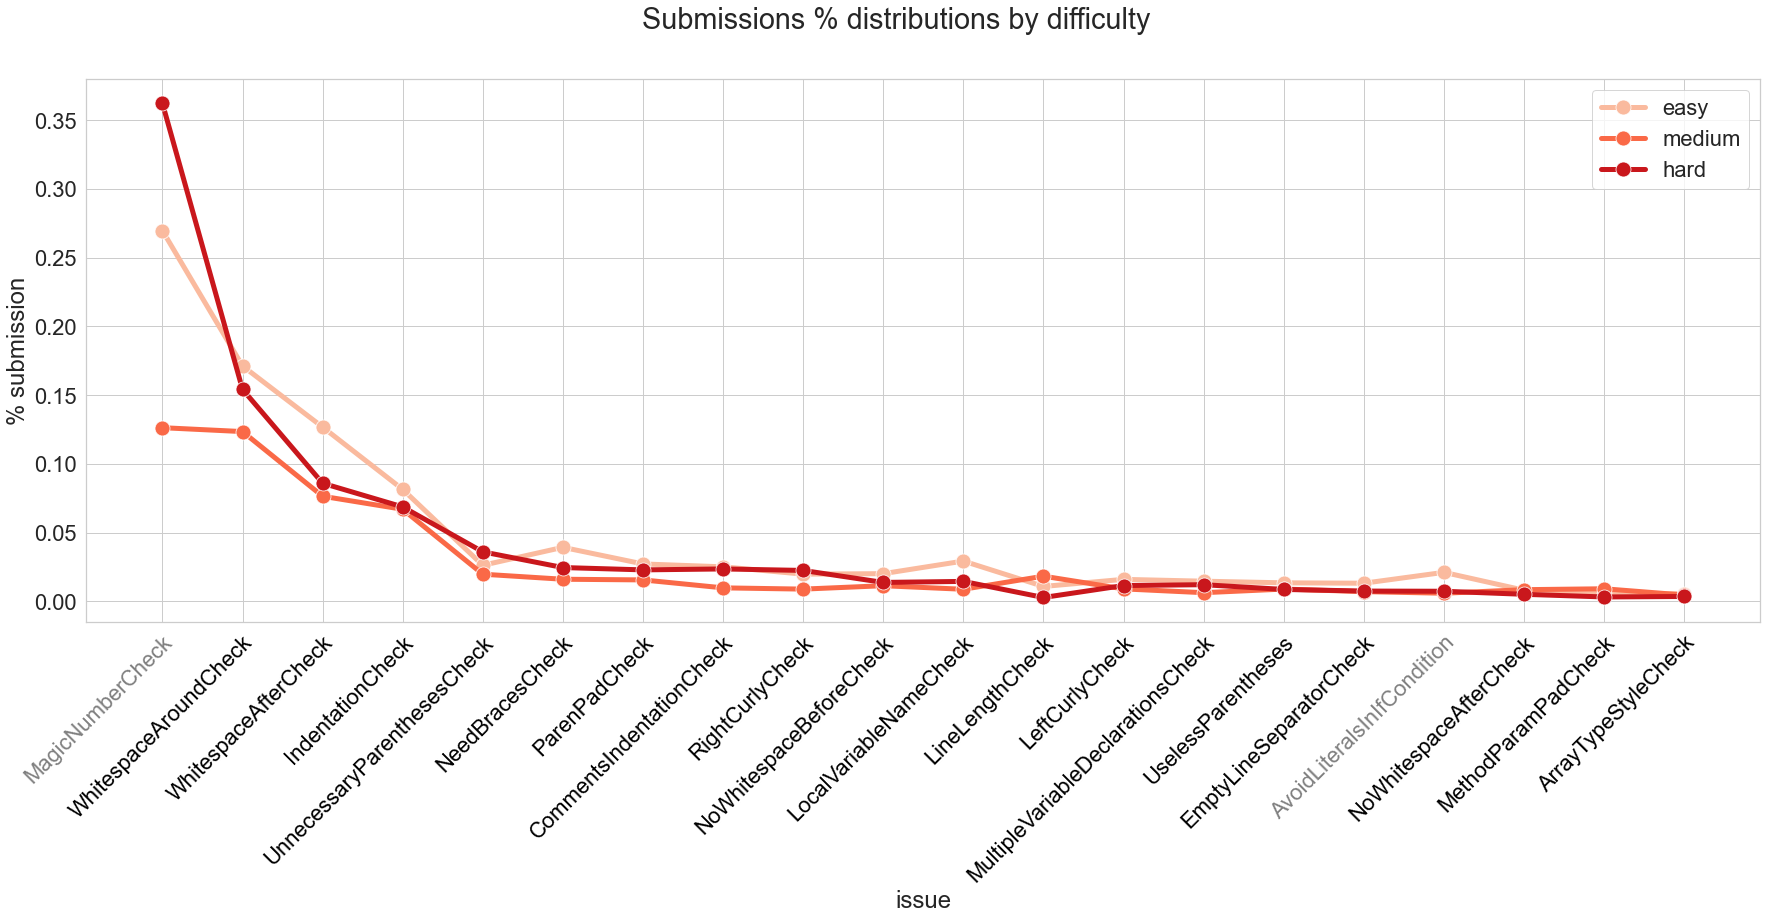

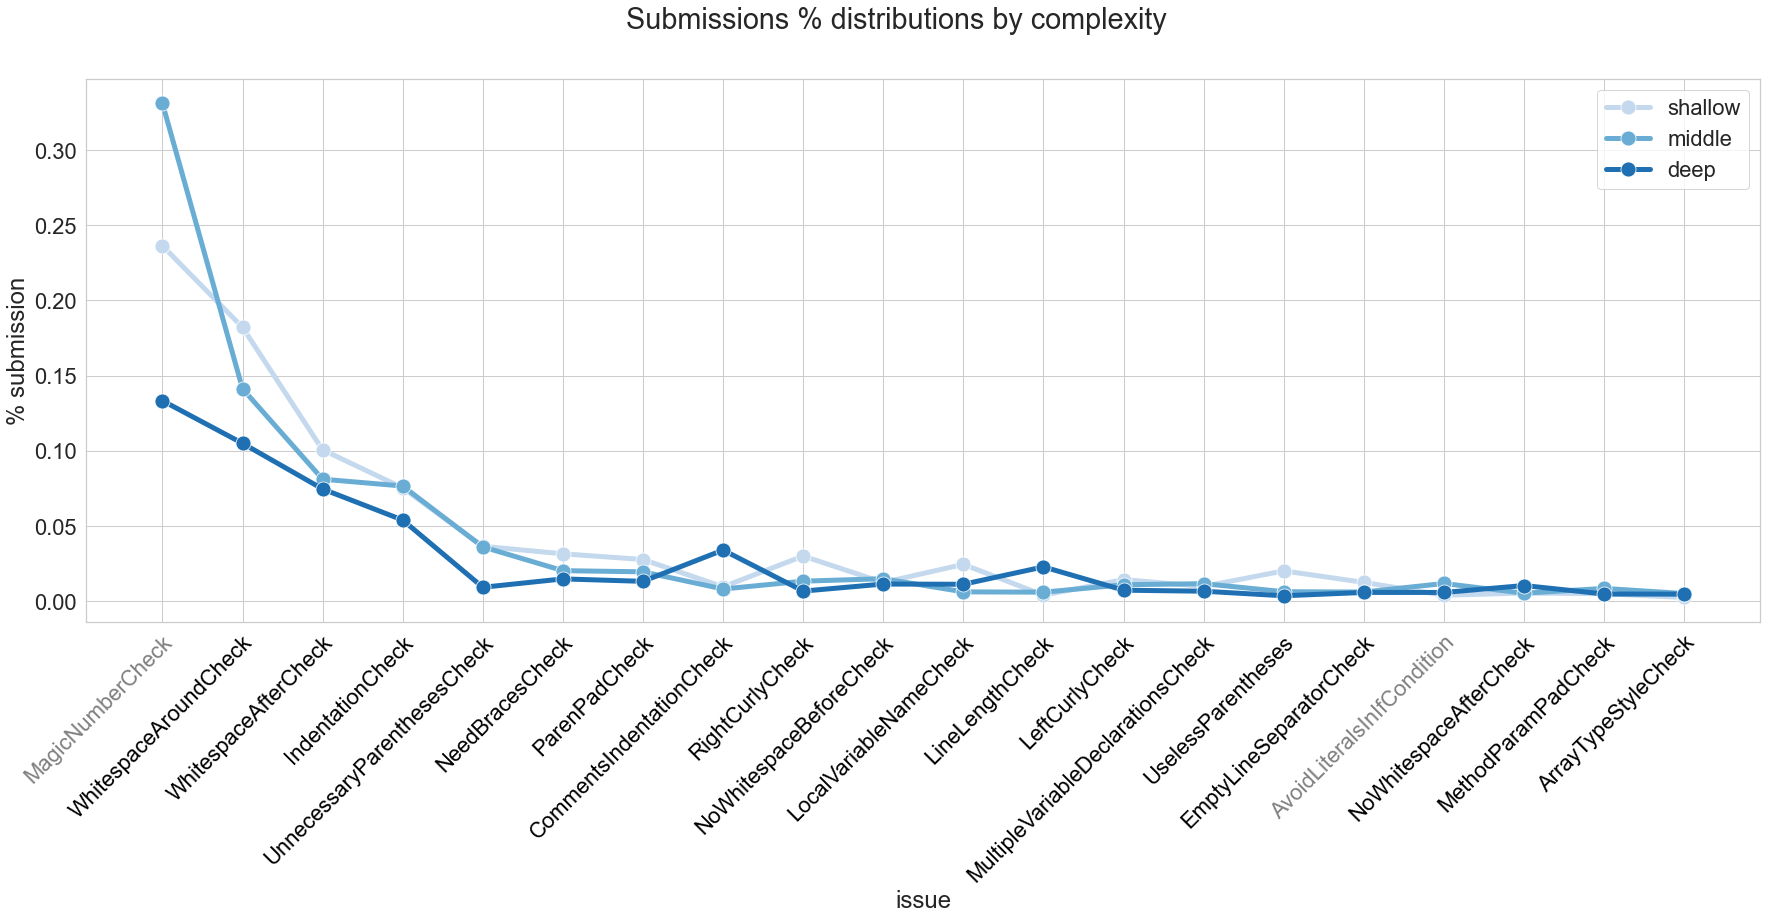

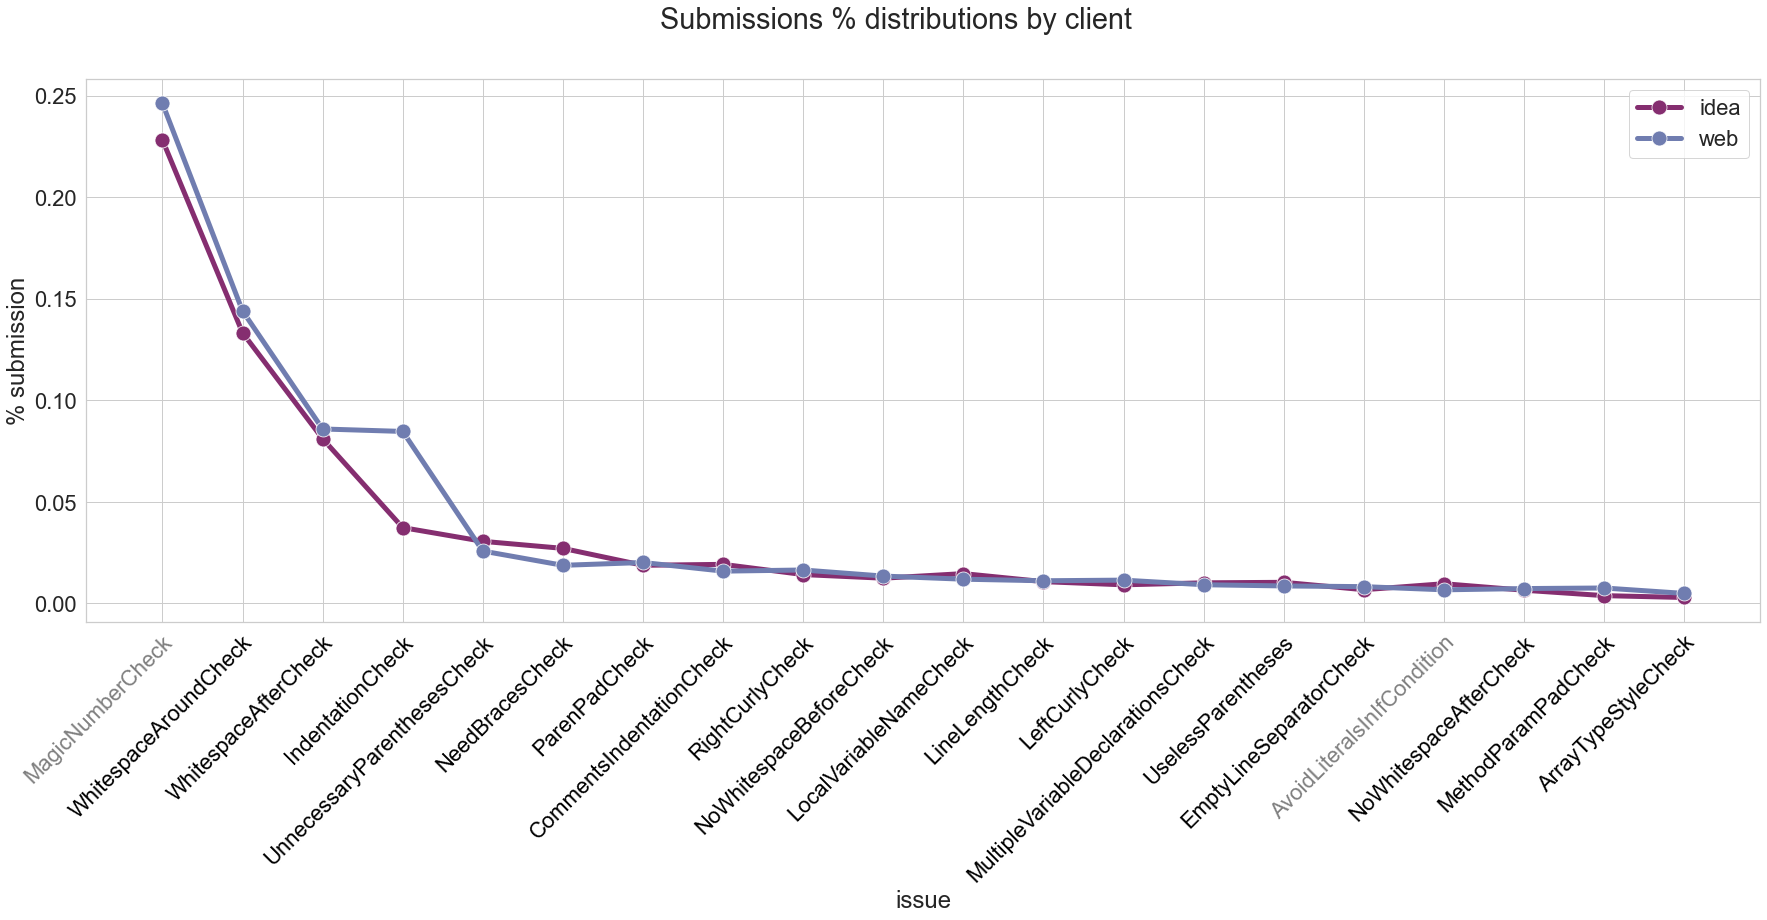

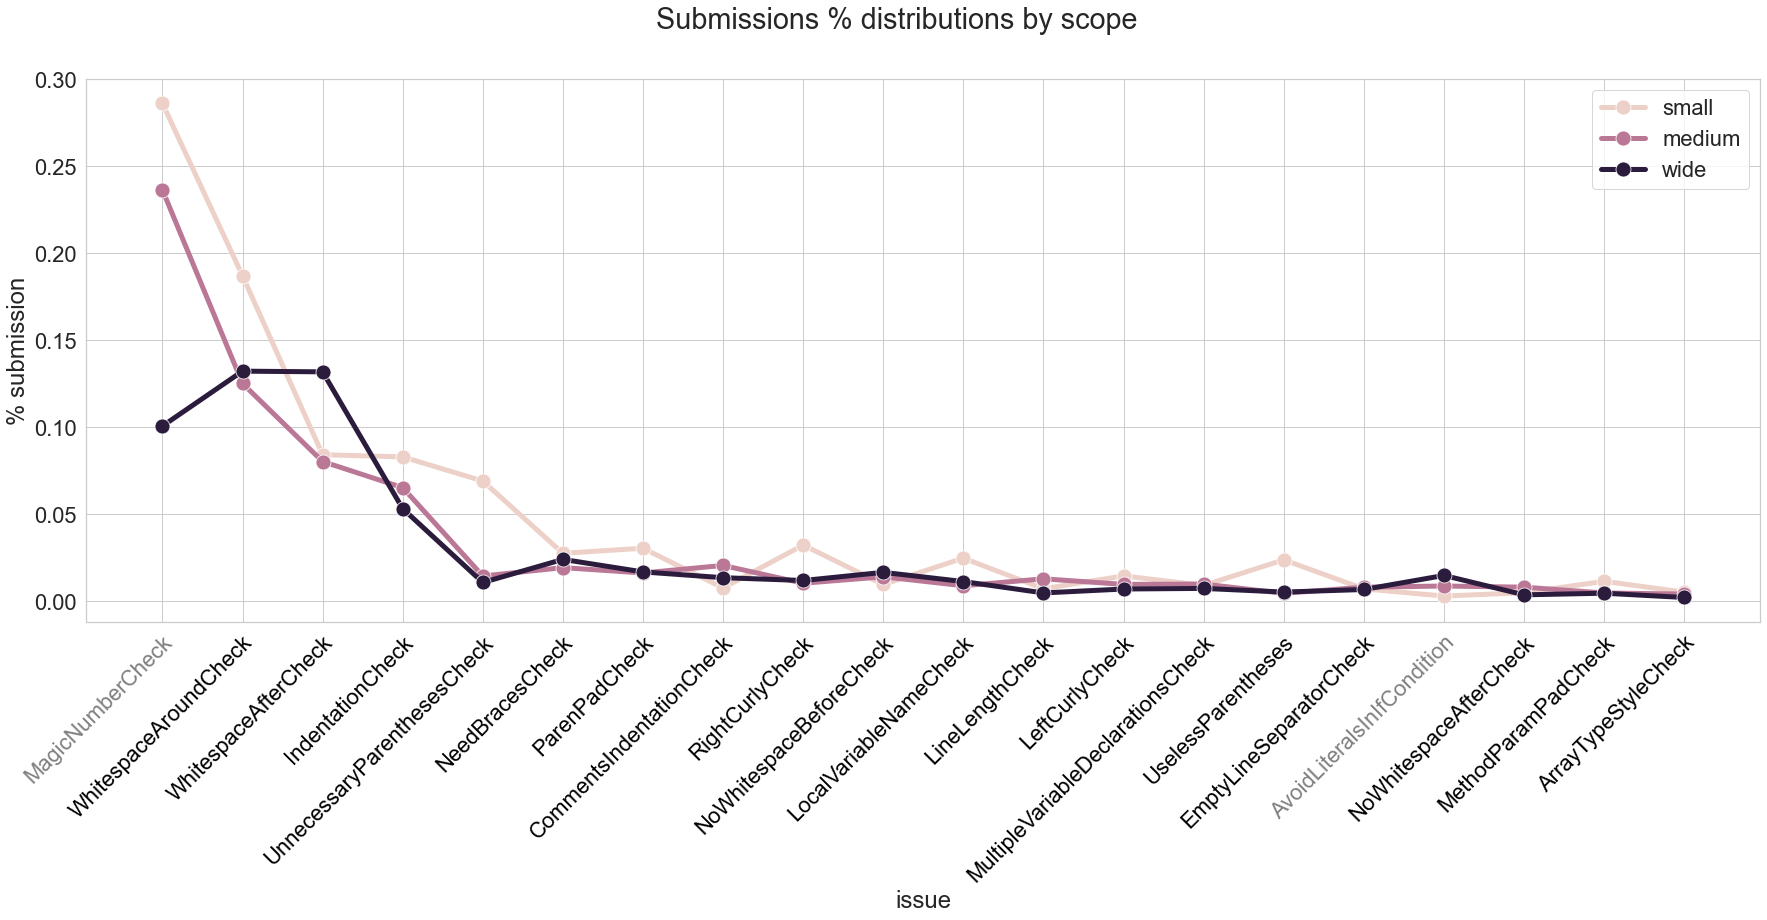

In [52]:
draw_issues(df_hyperstyle_issues_stats_unique, 
            df_hyperstyle_ignore_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=IGNORE_ISSUES_STATS_PATH)

### List and analysis of interesting issues (ERROR_PRONE, BEST_PRACTICES and COMPLEXITY categories)
In further analysis we will consider only top 20 issues with only `ERROR_PRONE`, `BEST_PRACTICES` and `COMPLEXITY` catecories, other issues are ignored

In [53]:
df_hyperstyle_issues_top = get_top_issues(df_hyperstyle_issues_stats_unique, 
                                          df_hyperstyle_issues, 
                                          20, 
                                          hyperstyle_issues_ignore_names)

df_hyperstyle_issues_top.to_csv(os.path.join(ISSUES_STATS_PATH, f'top_issues.csv'), index=False)
df_hyperstyle_issues_top

name  count        category  \
5                UnusedLocalVariable  19323  BEST_PRACTICES   
14                UnusedImportsCheck  14508  BEST_PRACTICES   
18  BooleanExpressionComplexityCheck  10619  BEST_PRACTICES   
23              MissingBreakInSwitch   9154     ERROR_PRONE   
22               ForLoopCanBeForeach   8520  BEST_PRACTICES   
30         MissingSwitchDefaultCheck   4367     ERROR_PRONE   
24    SimplifyBooleanExpressionCheck   4077  BEST_PRACTICES   
25              EqualsAvoidNullCheck   3659  BEST_PRACTICES   
32               AssignmentInOperand   3403     ERROR_PRONE   
27          ParameterAssignmentCheck   3245  BEST_PRACTICES   
28        LiteralsFirstInComparisons   2792  BEST_PRACTICES   
34                   AvoidArrayLoops   2733  BEST_PRACTICES   
33           CollapsibleIfStatements   2647  BEST_PRACTICES   
37              RedundantImportCheck   2431  BEST_PRACTICES   
29                    AddEmptyString   2107  BEST_PRACTICES   
38                 UnnecessaryImport   2081  BEST_PRACTICES   
35      ModifiedControlVariableCheck   1899  BEST_PRACTICES   
39               EmptyStatementCheck   1745     ERROR_PRONE   
42            CallSuperInConstructor    953  BEST_PRACTICES   
44     AvoidReassigningLoopVariables    870  BEST_PRACTICES   

                                                 text difficulty  \
5        Avoid unused local variables such as 'unit'.     MEDIUM   
14                   Unused import - javax.print.Doc.     MEDIUM   
18  Too long boolean expression. Try to split it i...       EASY   
23        A switch statement does not contain a break       HARD   
22    This for loop can be replaced by a foreach loop     MEDIUM   
30                   switch without "default" clause.       HARD   
24                      Expression can be simplified.     MEDIUM   
25  String literal expressions should be on the le...     MEDIUM   
32                      Avoid assignments in operands       HARD   
27     Assignment of parameter 'str1' is not allowed.     MEDIUM   
28      Position literals first in String comparisons     MEDIUM   
34                 System.arraycopy is more efficient     MEDIUM   
33  These nested if statements could be combined b...     MEDIUM   
37  Redundant import from the java.lang package - ...     MEDIUM   
29                           Do not add empty strings     MEDIUM   
38                 Unused import 'java.util.stream.*'     MEDIUM   
35                  Control variable 'j' is modified.     MEDIUM   
39                                   Empty statement.       HARD   
42  It is a good practice to call super() in a con...     MEDIUM   
44    Avoid reassigning the loop control variable 'i'     MEDIUM   

                                          code_sample     ratio  
5   import javax.print.Doc;\n\nclass Army {\n\n   ...  0.018008  
14  import javax.print.Doc; // UnusedImportsCheck ...  0.013521  
18  import java.util.*;\n\npublic class Main {\n  ...  0.009896  
23  import java.util.Scanner;\n\nclass Main {\n   ...  0.008531  
22  import java.util.Scanner;\n\nclass Main {\n   ...  0.007940  
30  import java.util.Scanner;\n\nclass Main {\n   ...  0.004070  
24  import java.util.Scanner;\n\nclass Main {\n   ...  0.003800  
25  import java.util.Scanner;\nclass Main {\n    s...  0.003410  
32  import java.io.BufferedReader;\nimport java.io...  0.003171  
27  import java.util.Scanner;\n\n\npublic class Ma...  0.003024  
28  import java.util.Scanner;\n\nclass Main {\n   ...  0.002602  
34  import java.util.Scanner;\n\nclass SelectionCo...  0.002547  
33  import java.util.Scanner;\n\nclass Main {\n   ...  0.002467  
37  import java.util.*;\nimport java.lang.*; // Re...  0.002266  
29  import java.util.*;\nclass Main {\n    public ...  0.001964  
38   import java.util.*;\n import java.util.stream...  0.001939  
35  import java.util.Scanner;\n\nclass Concatenate...  0.001770  
39  public class Main {\n\n    public static void ...  0.001626  
42  import java.util.Loca

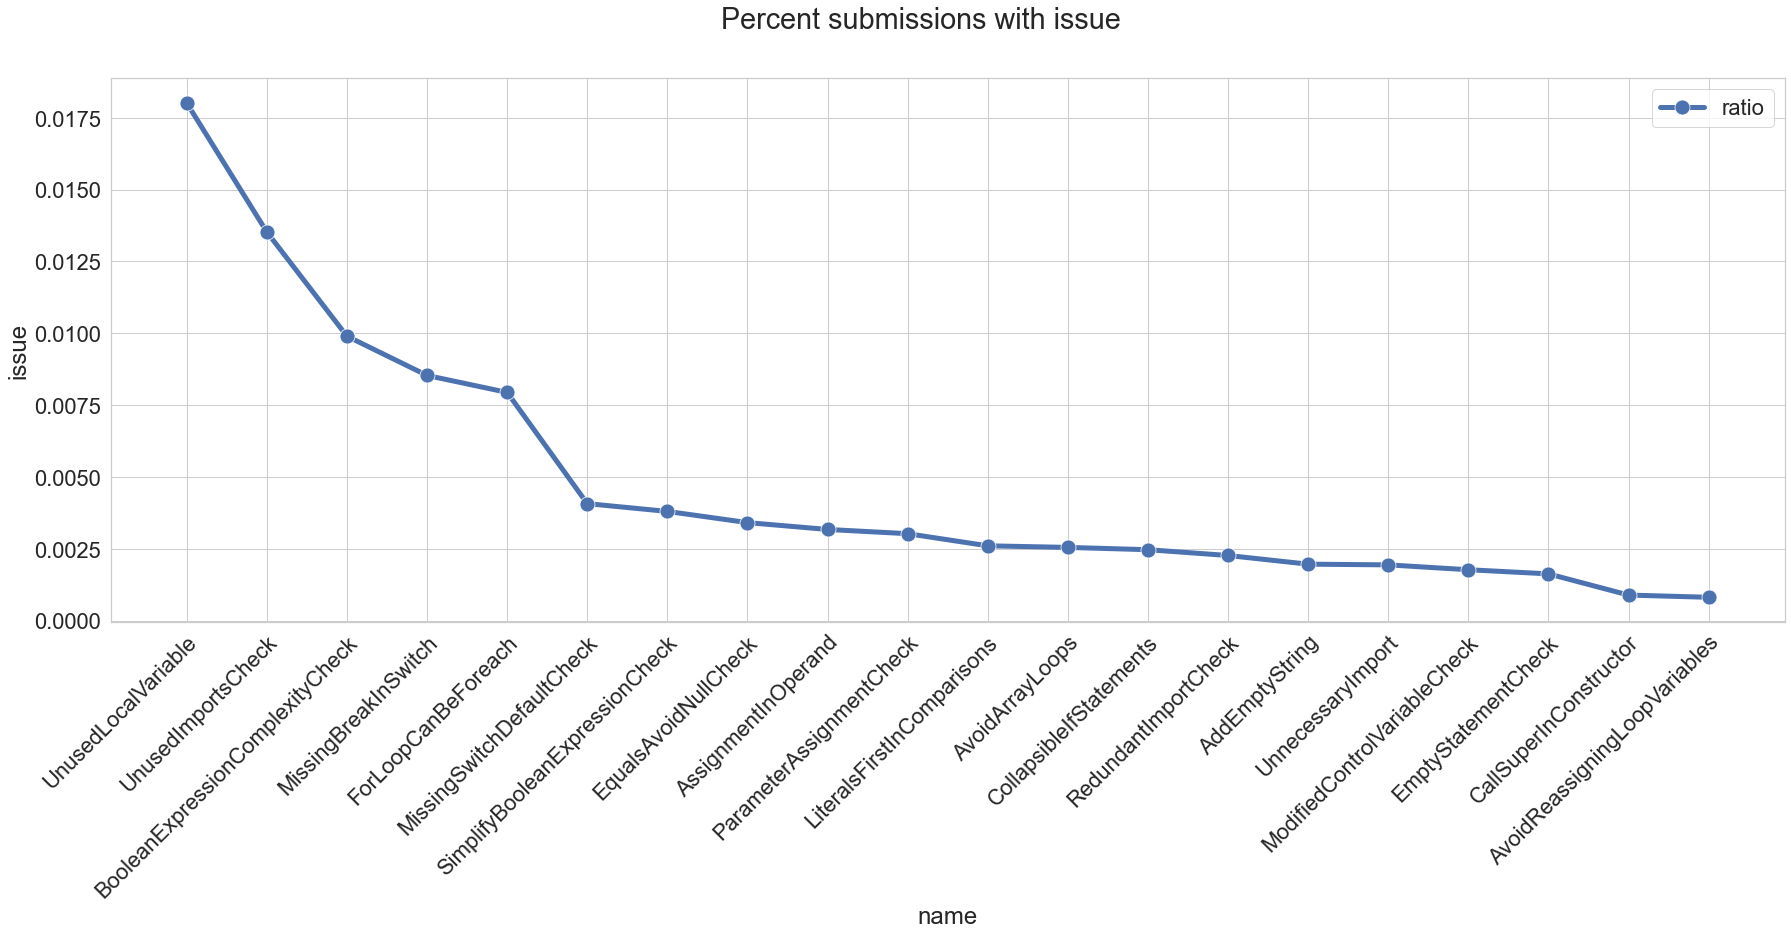

In [54]:
draw_compare(df_hyperstyle_issues_top, 'name', ['ratio', ['ratio']], 
             y_label='issue', 
             title='Percent submissions with issue', 
             save_path=os.path.join(ISSUES_STATS_PATH, f'top_issues.pdf'))

### Percent of all submissions which contain each hyperstyle issue

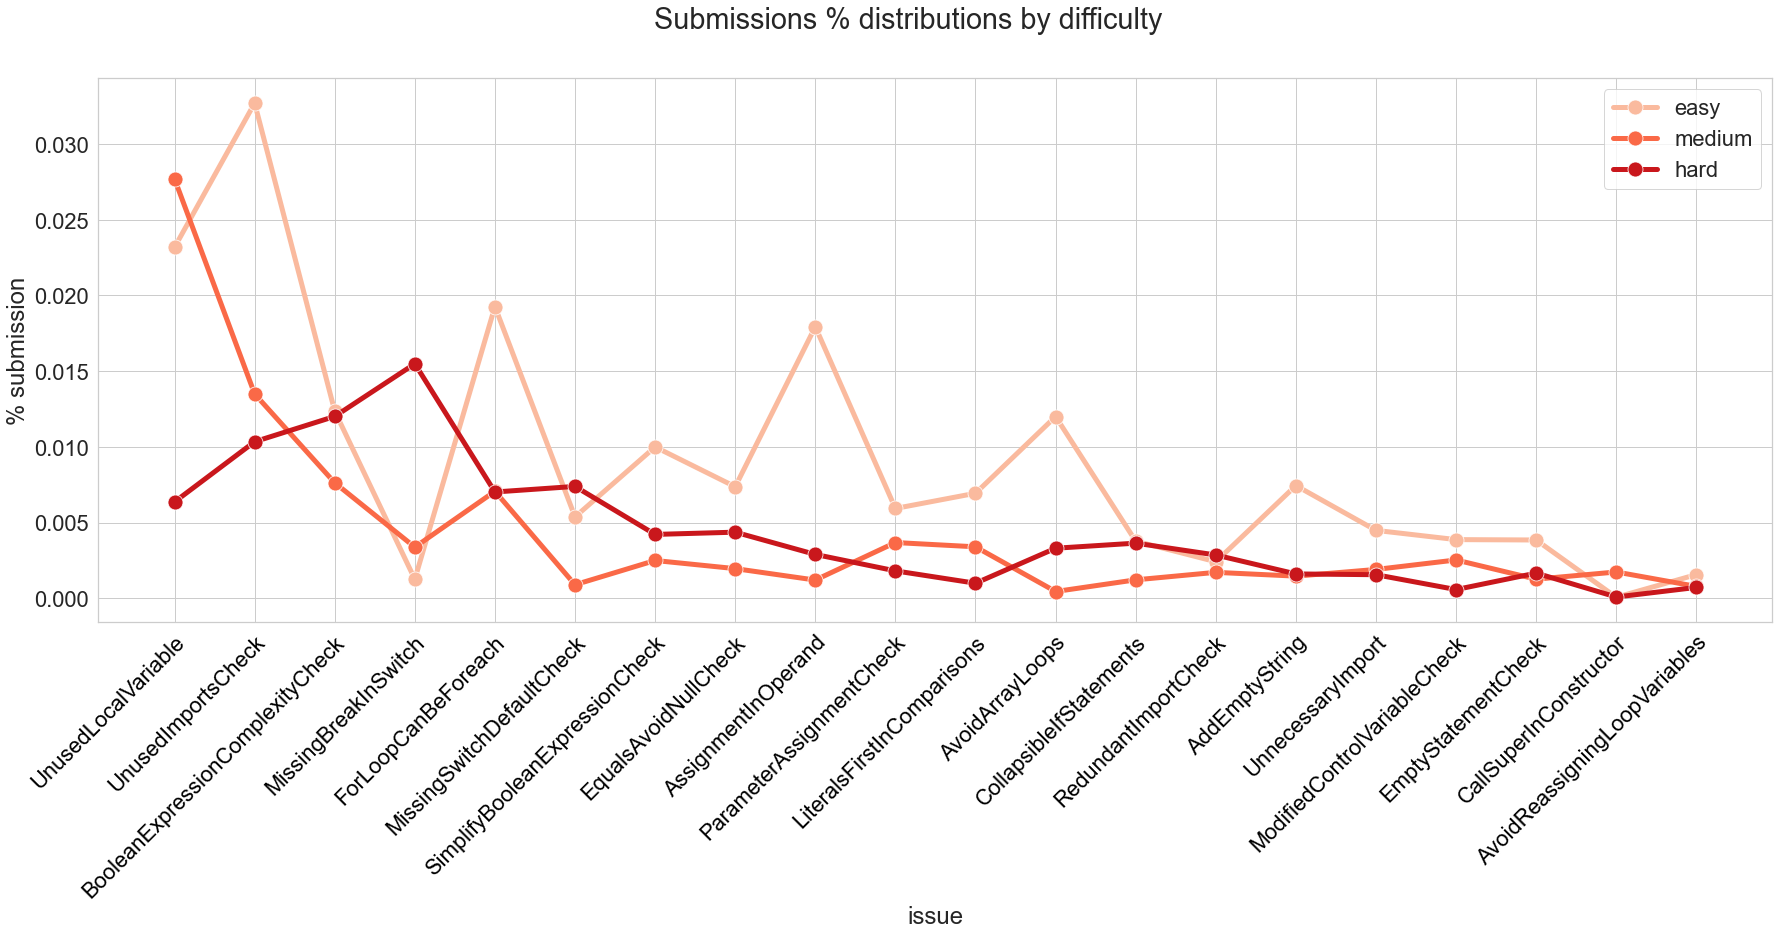

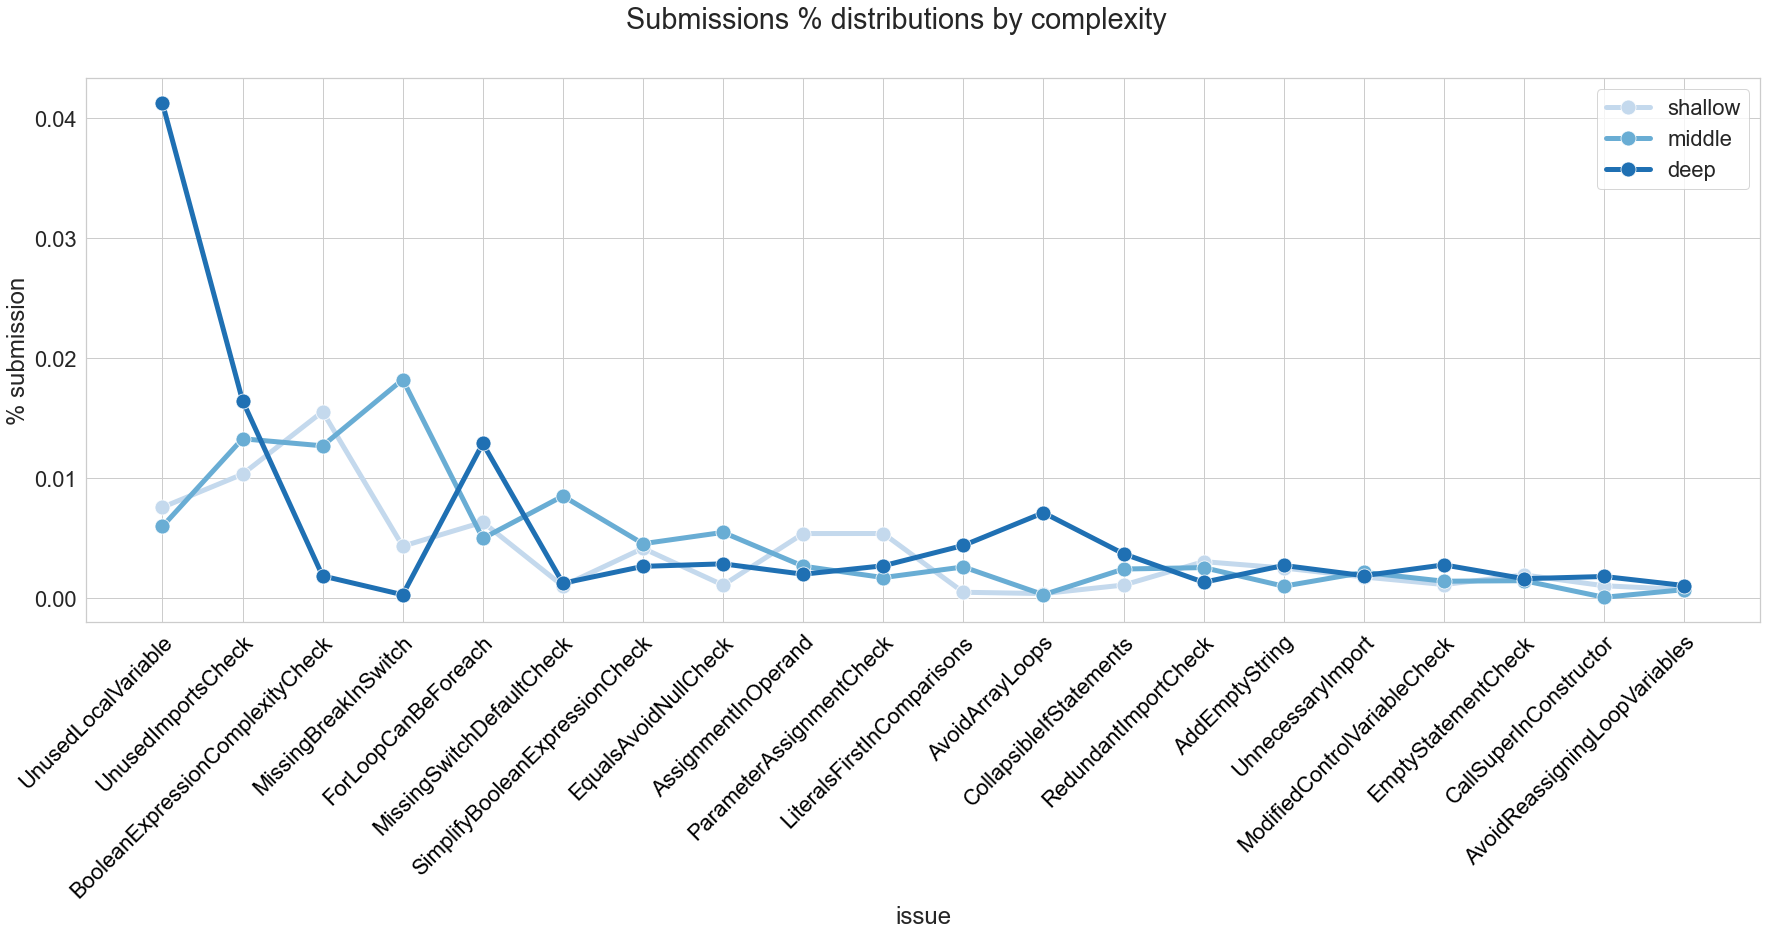

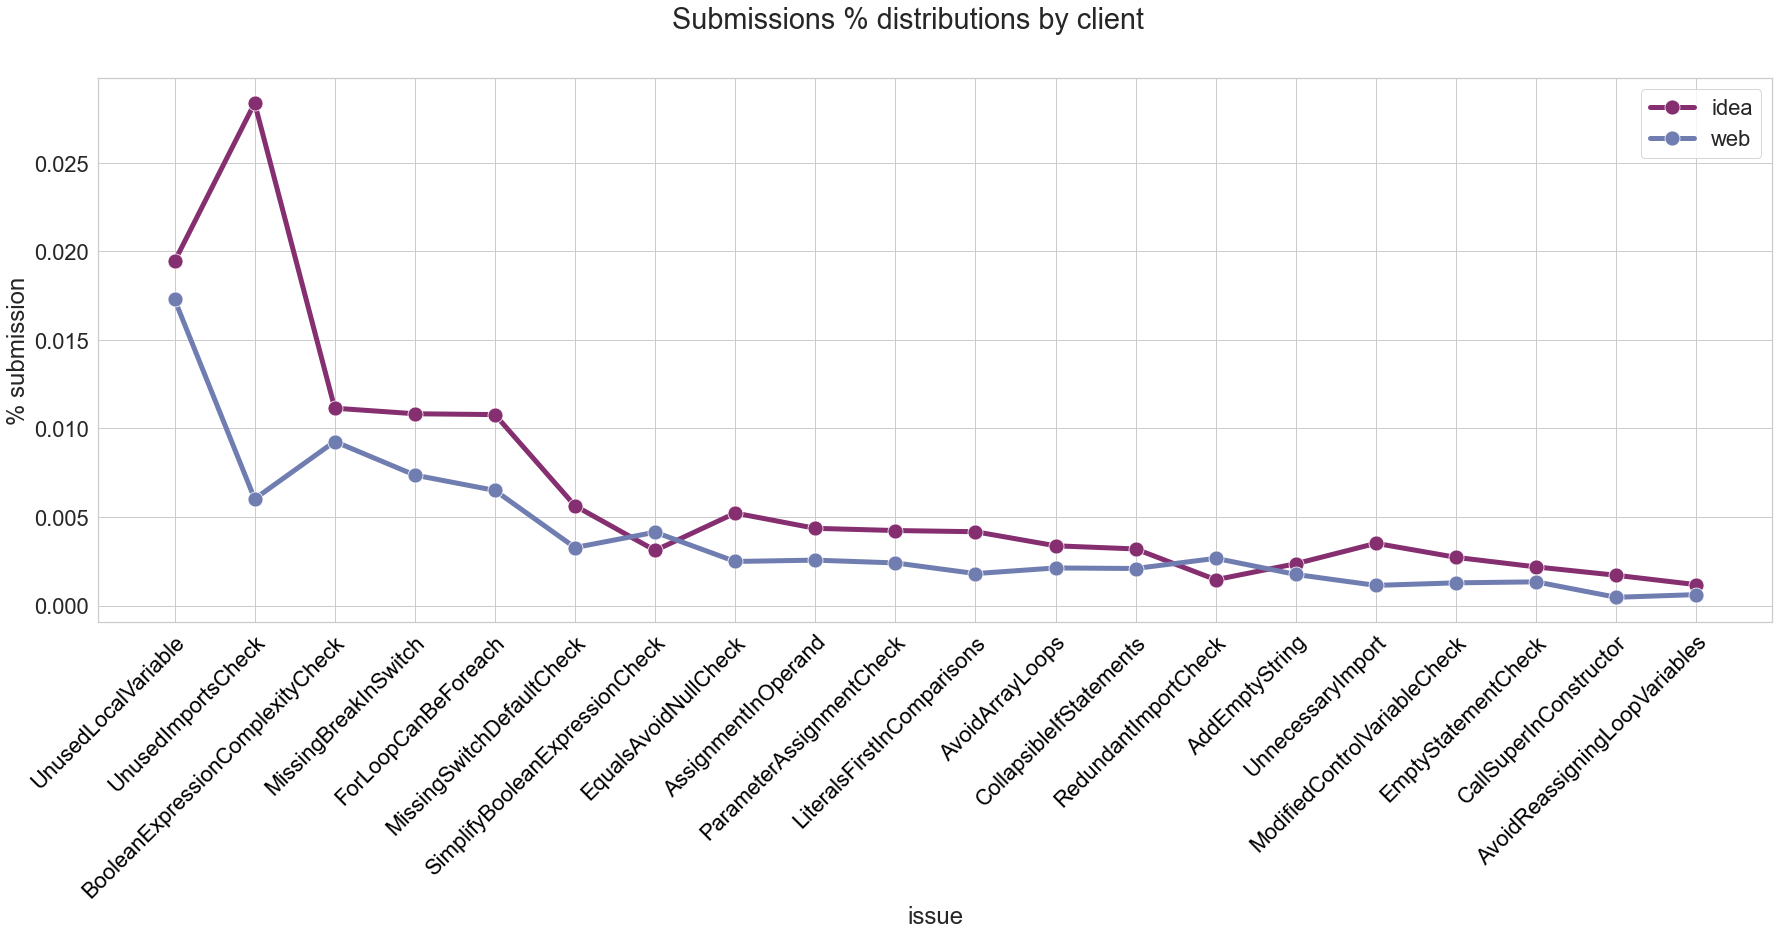

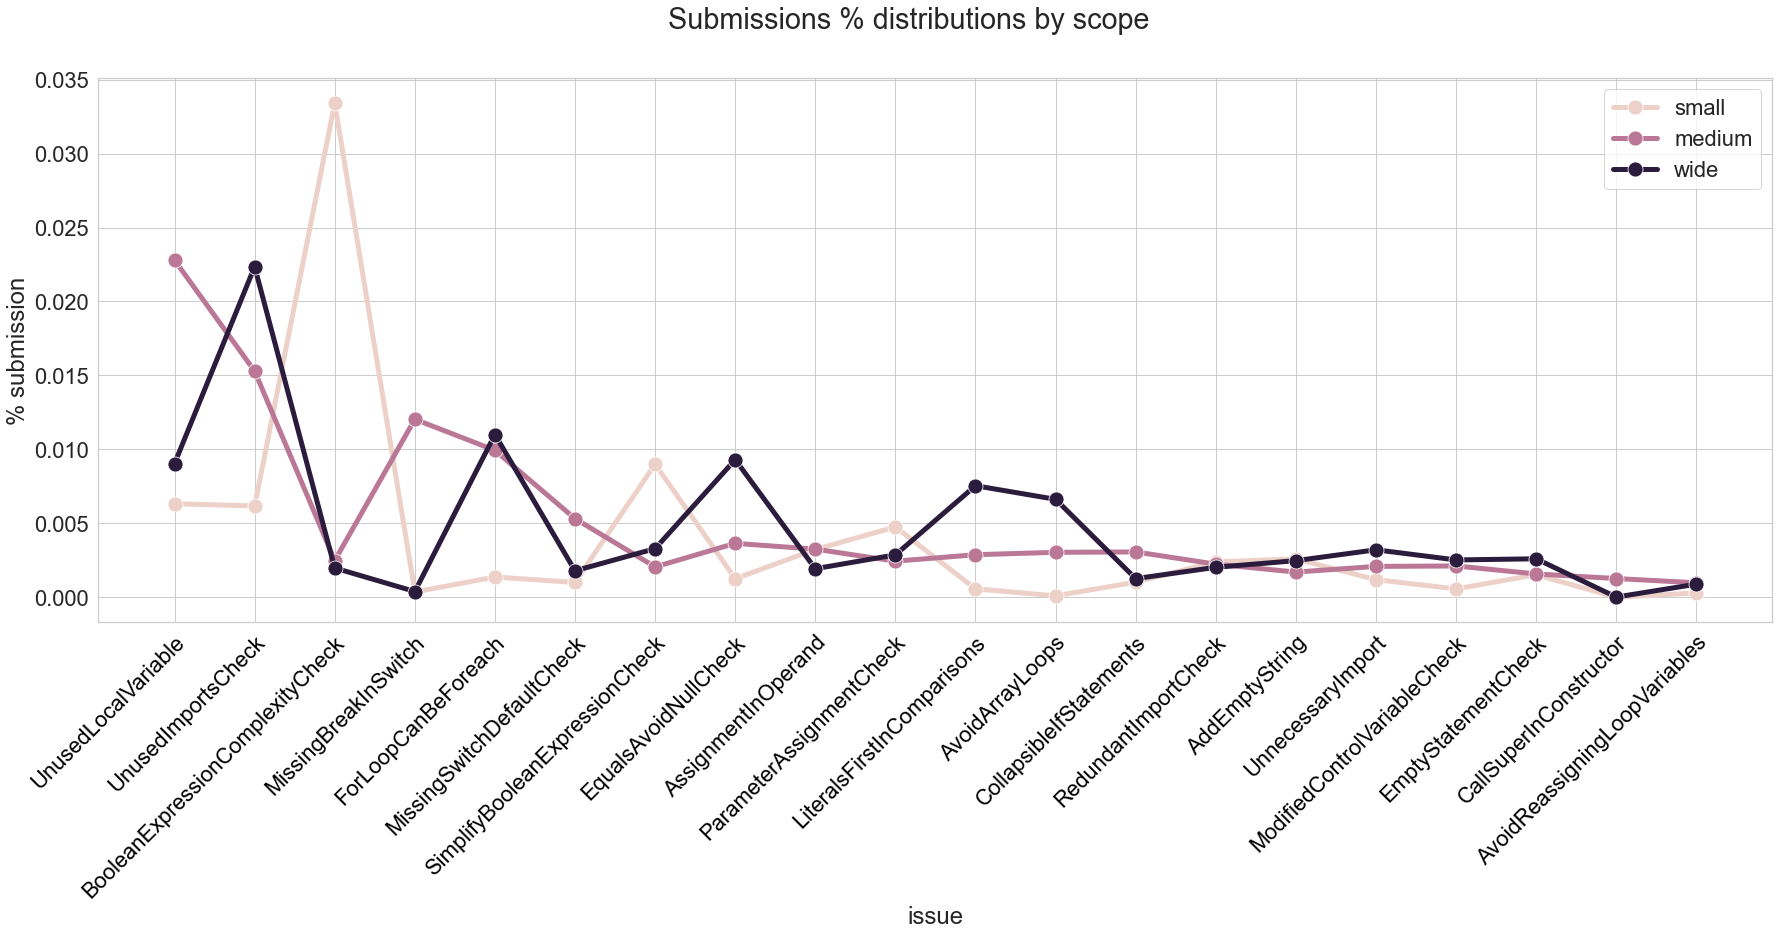

In [55]:
draw_issues(df_hyperstyle_issues_stats_unique, 
            df_hyperstyle_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=ISSUES_STATS_PATH)

# First attempt stats
First attempt submissions is when **attempt** == 1. This is the most interesting case as student do not see code quality feedback before so 1-st attempt shows the exact level of sudent code quality without any hints.

In [56]:
df_first_attempt_stats = df_submissions_stats[df_submissions_stats['attempt'] == 1]
df_first_attempt_stats.describe()

id  code_lines_count  code_symbols_count        step_id  \
count  8.345750e+05     834575.000000       834575.000000  834575.000000   
mean   4.273626e+07         19.364782          517.273254    3564.302187   
std    7.896541e+06         19.641912          513.826138    2400.881303   
min    2.938134e+07          1.000000           92.000000    1926.000000   
25%    3.574286e+07         10.000000          248.000000    2272.000000   
50%    4.265018e+07         15.000000          397.000000    2509.000000   
75%    4.975415e+07         22.000000          601.000000    3752.000000   
max    5.639778e+07       2366.000000        81398.000000   15239.000000   

        sync_counter        user_id         group   attempt  total_attempts  
count  834575.000000  834575.000000  8.345750e+05  834575.0   834575.000000  
mean        8.394579    8592.311883  5.522554e+05       1.0        1.285706  
std         1.627618    8034.311124  3.082742e+05       0.0        0.673806  
min         2.000000       0.000000  0.000000e+00       1.0        1.000000  
25%         7.000000    2363.000000  2.787975e+05       1.0        1.000000  
50%         8.000000    5901.000000  5.746260e+05       1.0        1.000000  
75%         9.000000   13224.000000  8.246625e+05       1.0        1.000000  
max        22.000000   82397.000000  1.055200e+06       1.0        5.000000

In [57]:
df_first_attempt_stats.shape

(834575, 17)

### First attempt statistics

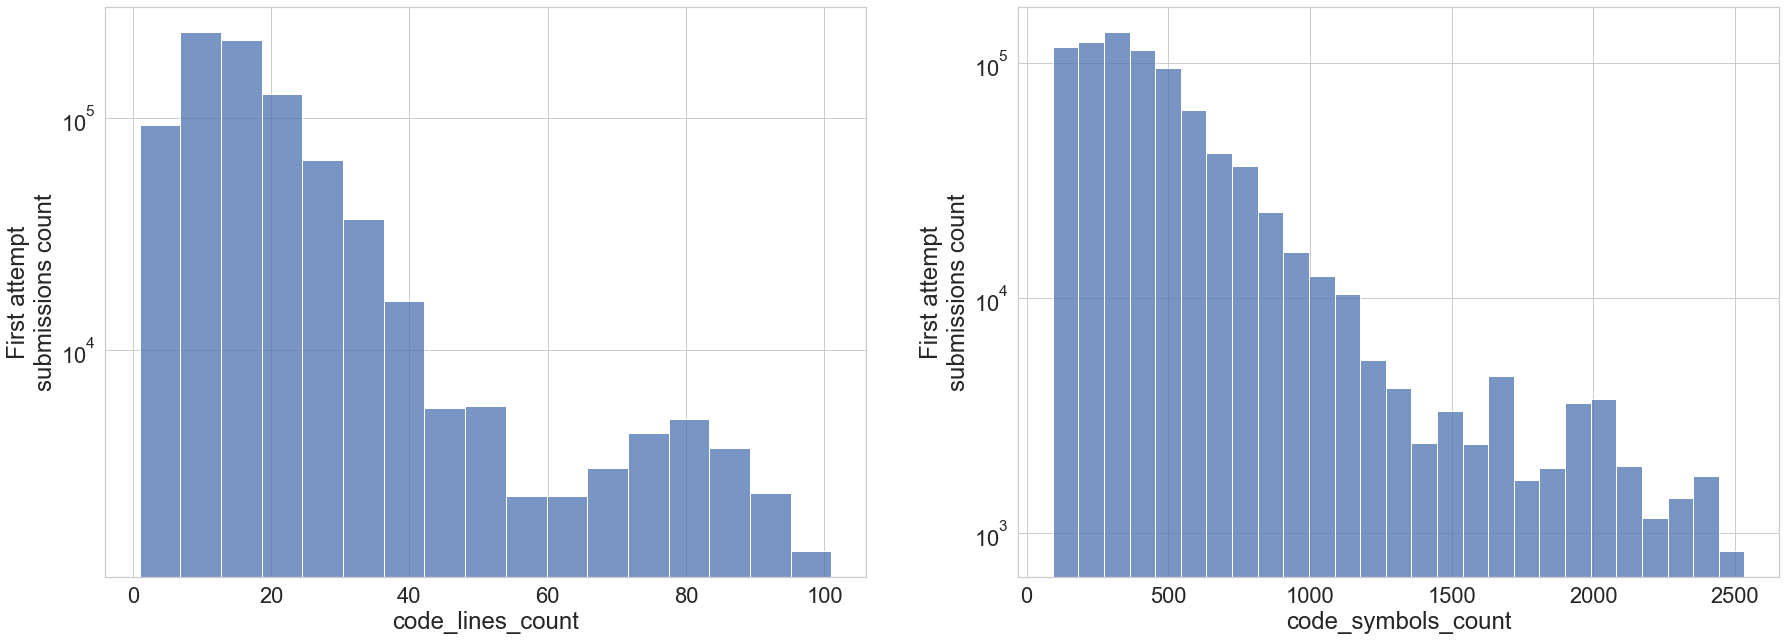

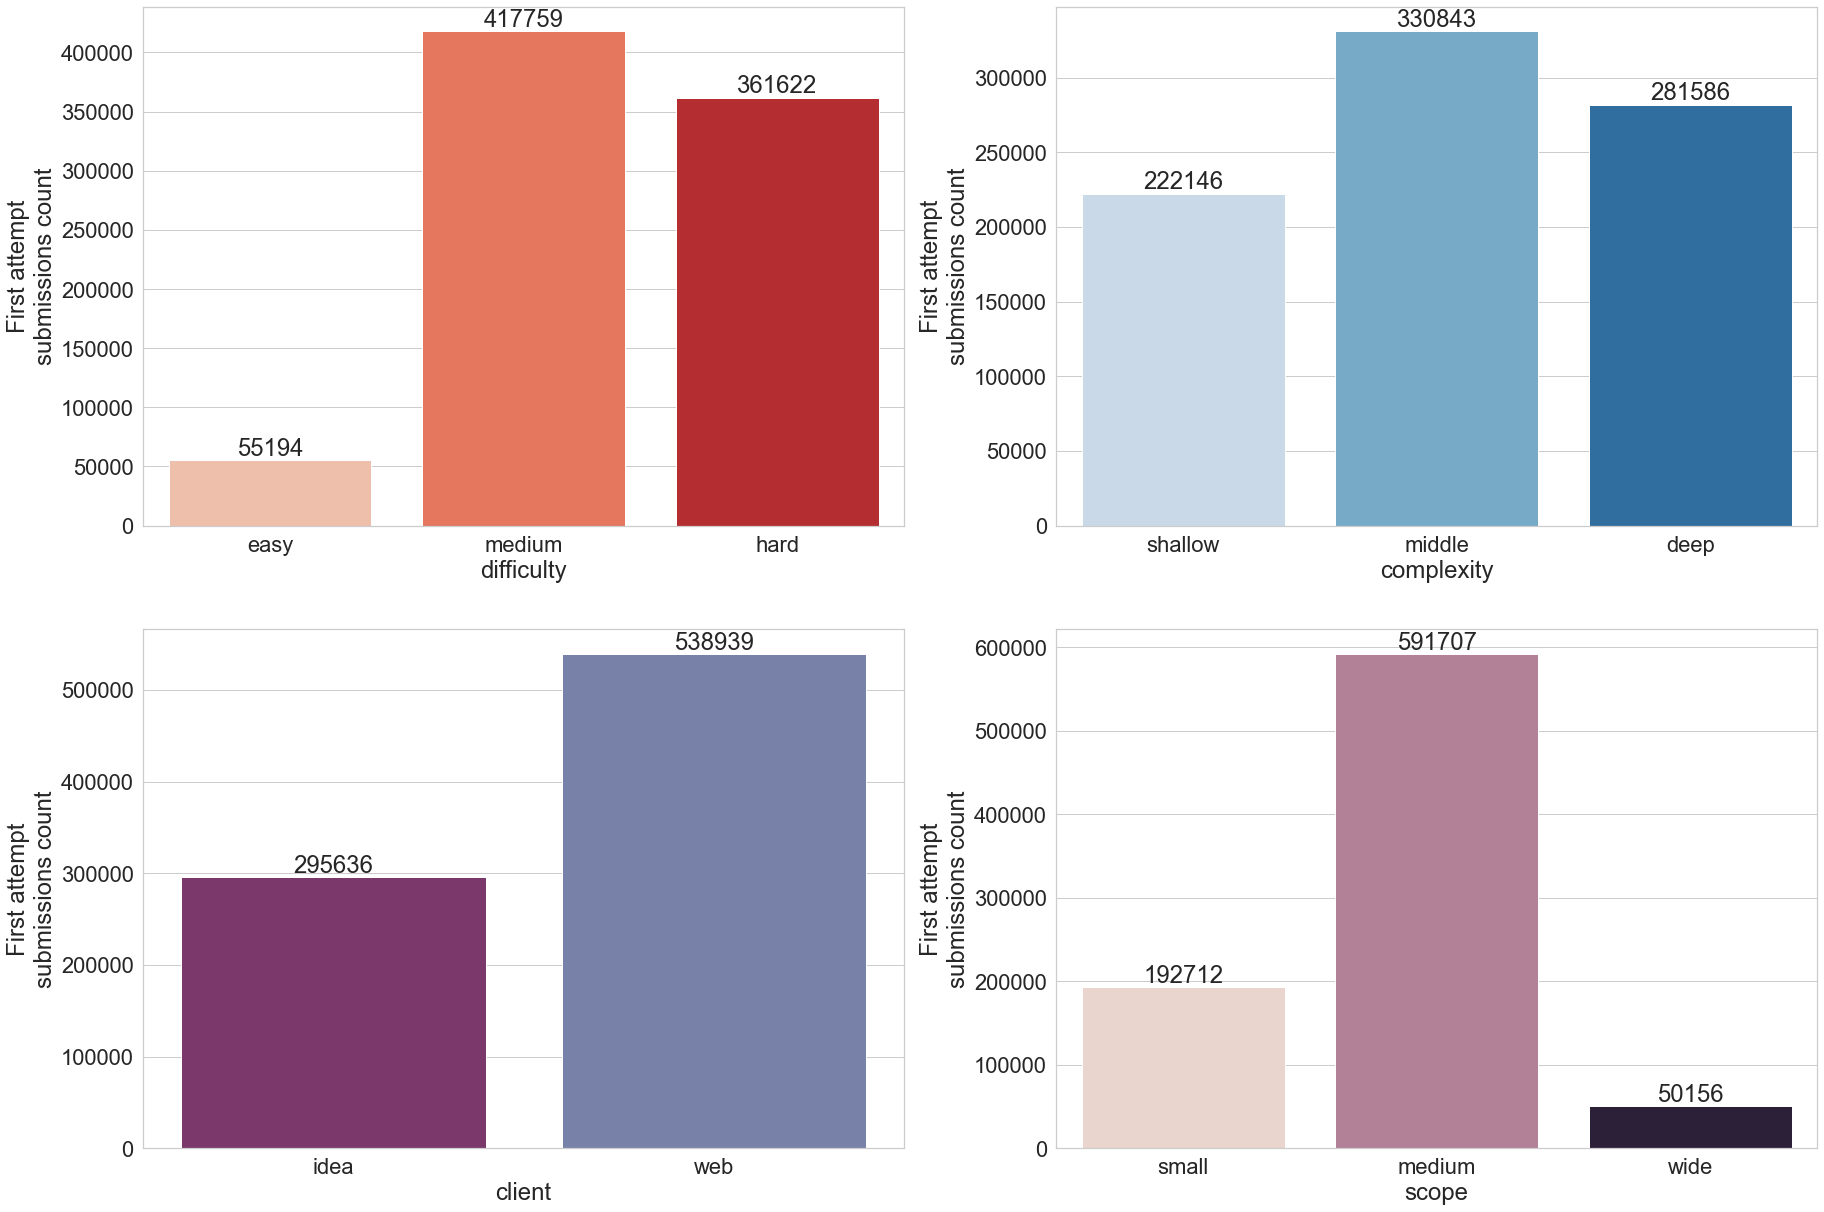

In [58]:
draw_hist_plots(df_first_attempt_stats, ['code_lines_count', 'code_symbols_count'], 
                log_scale=(False, True), y_label='First attempt\nsubmissions count')

draw_count_plots(df_first_attempt_stats, ['difficulty', 'complexity', 'client', 'scope'], 
                 y_label='First attempt\nsubmissions count')

In [59]:
df_first_attempt_hyperstyle_issues_stats = \
    merge_dfs(df_first_attempt_stats, df_hyperstyle_issues_stats, left_on='id', right_on='id')
df_first_attempt_hyperstyle_issues_stats_unique = \
    merge_dfs(df_first_attempt_stats, df_hyperstyle_issues_stats_unique, left_on='id', right_on='id')

### Hyperstyle issues analysis in first attempt. Percent of submissions with each issue.

In [60]:
df_first_attempt_hyperstyle_issues_top = get_top_issues(df_first_attempt_hyperstyle_issues_stats_unique, 
                                          df_hyperstyle_issues, 
                                          20, 
                                          hyperstyle_issues_ignore_names)

df_first_attempt_hyperstyle_issues_top.to_csv(os.path.join(FIRST_ATTEMPT_STATS_PATH, f'top_issues.csv'), index=False)
df_first_attempt_hyperstyle_issues_top

name  count        category  \
5                UnusedLocalVariable  15275  BEST_PRACTICES   
14                UnusedImportsCheck  12089  BEST_PRACTICES   
23              MissingBreakInSwitch   7189     ERROR_PRONE   
18  BooleanExpressionComplexityCheck   7156  BEST_PRACTICES   
22               ForLoopCanBeForeach   6577  BEST_PRACTICES   
30         MissingSwitchDefaultCheck   3666     ERROR_PRONE   
24    SimplifyBooleanExpressionCheck   2953  BEST_PRACTICES   
25              EqualsAvoidNullCheck   2859  BEST_PRACTICES   
27          ParameterAssignmentCheck   2604  BEST_PRACTICES   
32               AssignmentInOperand   2240     ERROR_PRONE   
33           CollapsibleIfStatements   2050  BEST_PRACTICES   
28        LiteralsFirstInComparisons   1994  BEST_PRACTICES   
37              RedundantImportCheck   1925  BEST_PRACTICES   
34                   AvoidArrayLoops   1901  BEST_PRACTICES   
38                 UnnecessaryImport   1705  BEST_PRACTICES   
29                    AddEmptyString   1422  BEST_PRACTICES   
39               EmptyStatementCheck   1372     ERROR_PRONE   
35      ModifiedControlVariableCheck   1335  BEST_PRACTICES   
42            CallSuperInConstructor    818  BEST_PRACTICES   
40                     UpperEllCheck    697  BEST_PRACTICES   

                                                 text difficulty  \
5        Avoid unused local variables such as 'unit'.     MEDIUM   
14                   Unused import - javax.print.Doc.     MEDIUM   
23        A switch statement does not contain a break       HARD   
18  Too long boolean expression. Try to split it i...       EASY   
22    This for loop can be replaced by a foreach loop     MEDIUM   
30                   switch without "default" clause.       HARD   
24                      Expression can be simplified.     MEDIUM   
25  String literal expressions should be on the le...     MEDIUM   
27     Assignment of parameter 'str1' is not allowed.     MEDIUM   
32                      Avoid assignments in operands       HARD   
33  These nested if statements could be combined b...     MEDIUM   
28      Position literals first in String comparisons     MEDIUM   
37  Redundant import from the java.lang package - ...     MEDIUM   
34                 System.arraycopy is more efficient     MEDIUM   
38                 Unused import 'java.util.stream.*'     MEDIUM   
29                           Do not add empty strings     MEDIUM   
39                                   Empty statement.       HARD   
35                  Control variable 'j' is modified.     MEDIUM   
42  It is a good practice to call super() in a con...     MEDIUM   
40                          Should use uppercase 'L'.     MEDIUM   

                                          code_sample     ratio  
5   import javax.print.Doc;\n\nclass Army {\n\n   ...  0.018303  
14  import javax.print.Doc; // UnusedImportsCheck ...  0.014485  
23  import java.util.Scanner;\n\nclass Main {\n   ...  0.008614  
18  import java.util.*;\n\npublic class Main {\n  ...  0.008574  
22  import java.util.Scanner;\n\nclass Main {\n   ...  0.007881  
30  import java.util.Scanner;\n\nclass Main {\n   ...  0.004393  
24  import java.util.Scanner;\n\nclass Main {\n   ...  0.003538  
25  import java.util.Scanner;\nclass Main {\n    s...  0.003426  
27  import java.util.Scanner;\n\n\npublic class Ma...  0.003120  
32  import java.io.BufferedReader;\nimport java.io...  0.002684  
33  import java.util.Scanner;\n\nclass Main {\n   ...  0.002456  
28  import java.util.Scanner;\n\nclass Main {\n   ...  0.002389  
37  import java.util.*;\nimport java.lang.*; // Re...  0.002307  
34  import java.util.Scanner;\n\nclass SelectionCo...  0.002278  
38   import java.util.*;\n import java.util.stream...  0.002043  
29  import java.util.*;\nclass Main {\n    public ...  0.001704  
39  public class Main {\n\n    public static void ...  0.001644  
35  import java.util.Scanner;\n\nclass Concatenate...  0.001600  
42  import java.util.Loca

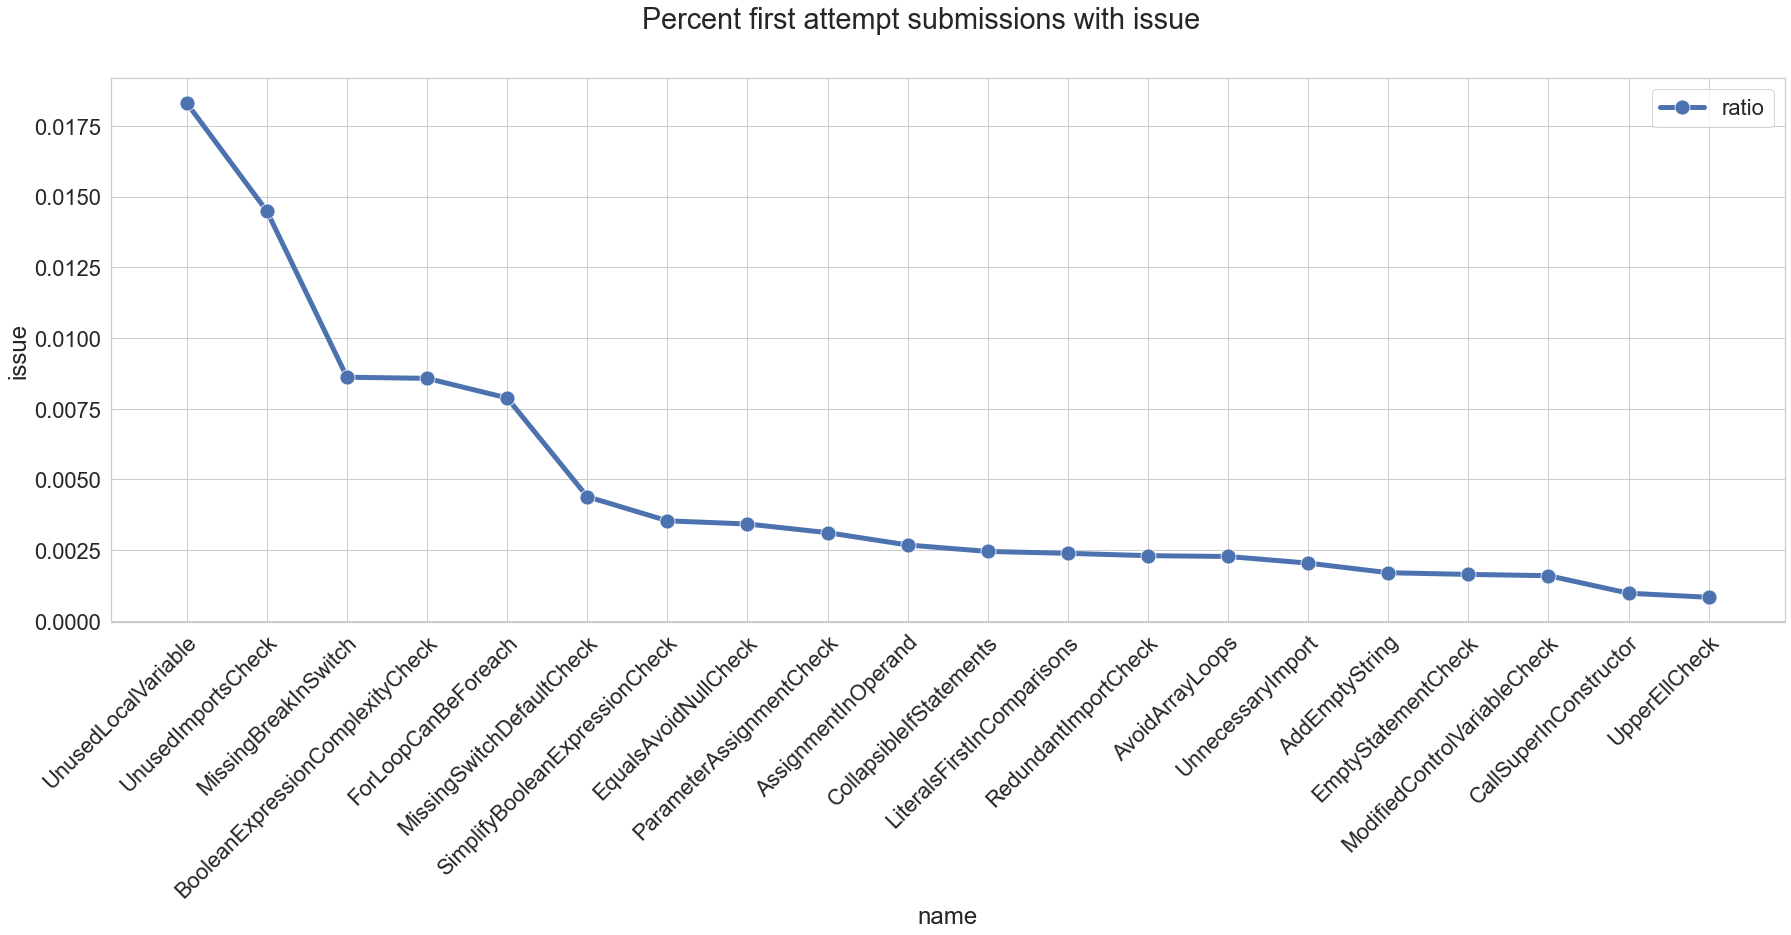

In [61]:
draw_compare(df_first_attempt_hyperstyle_issues_top, 'name', ['ratio', ['ratio']], 
             y_label='issue', 
             title='Percent first attempt submissions with issue', 
             save_path=os.path.join(FIRST_ATTEMPT_STATS_PATH, f'top_issues.pdf'))

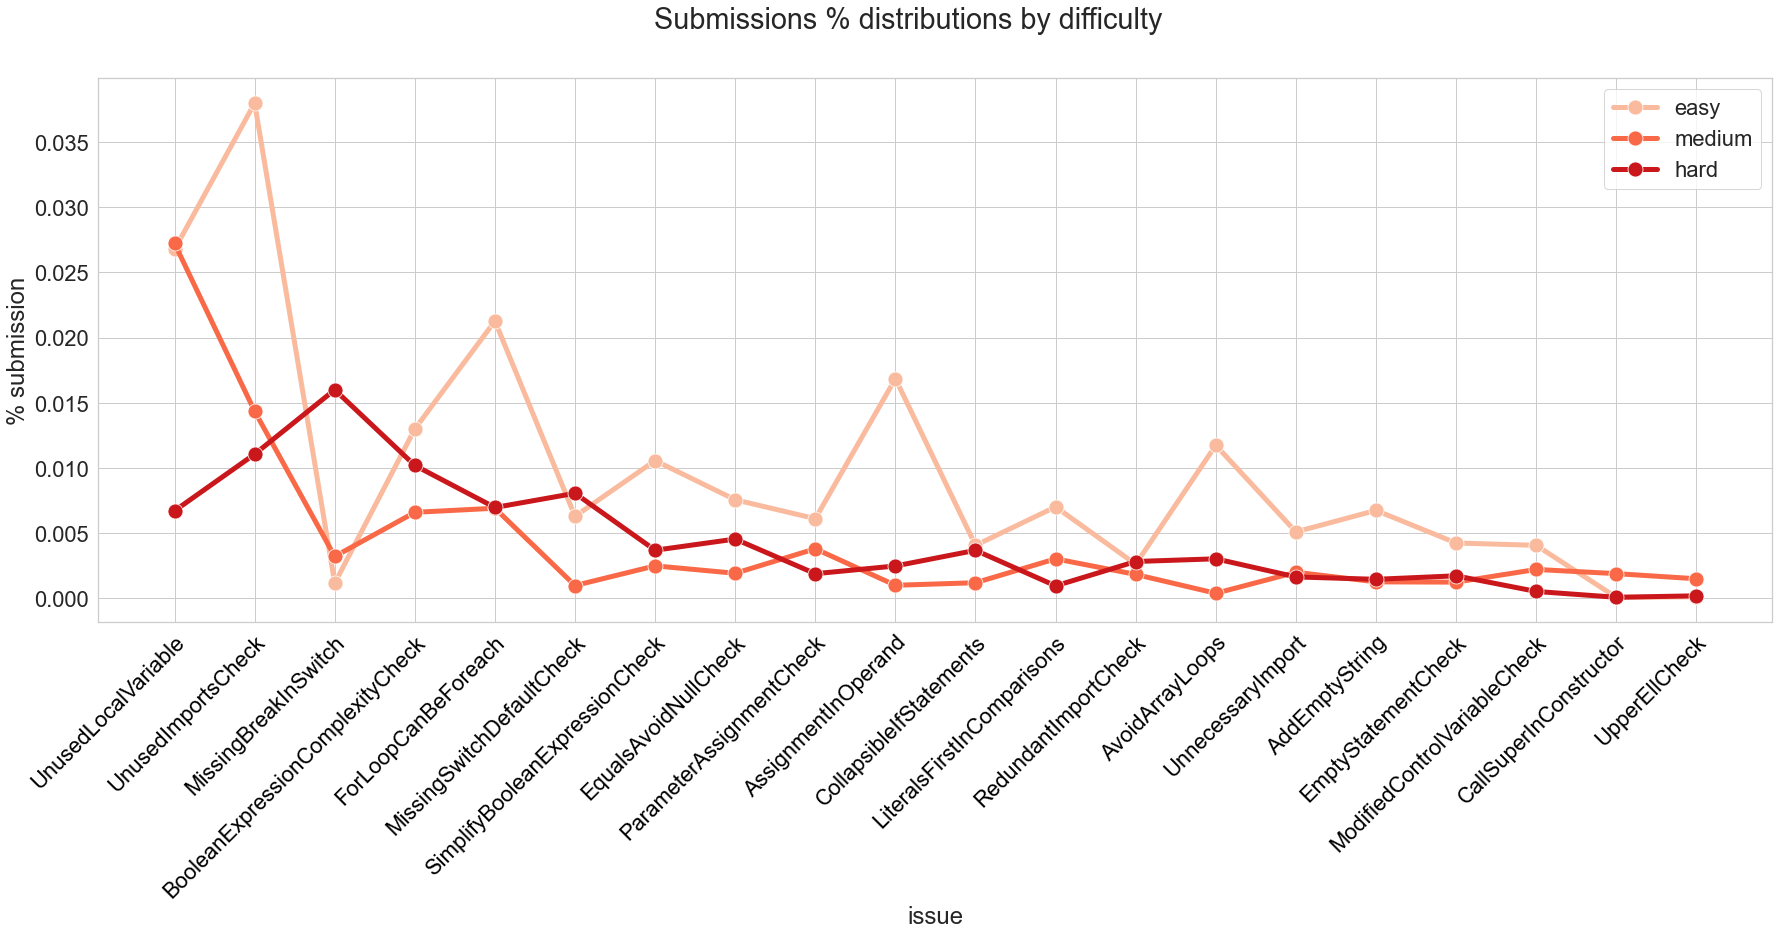

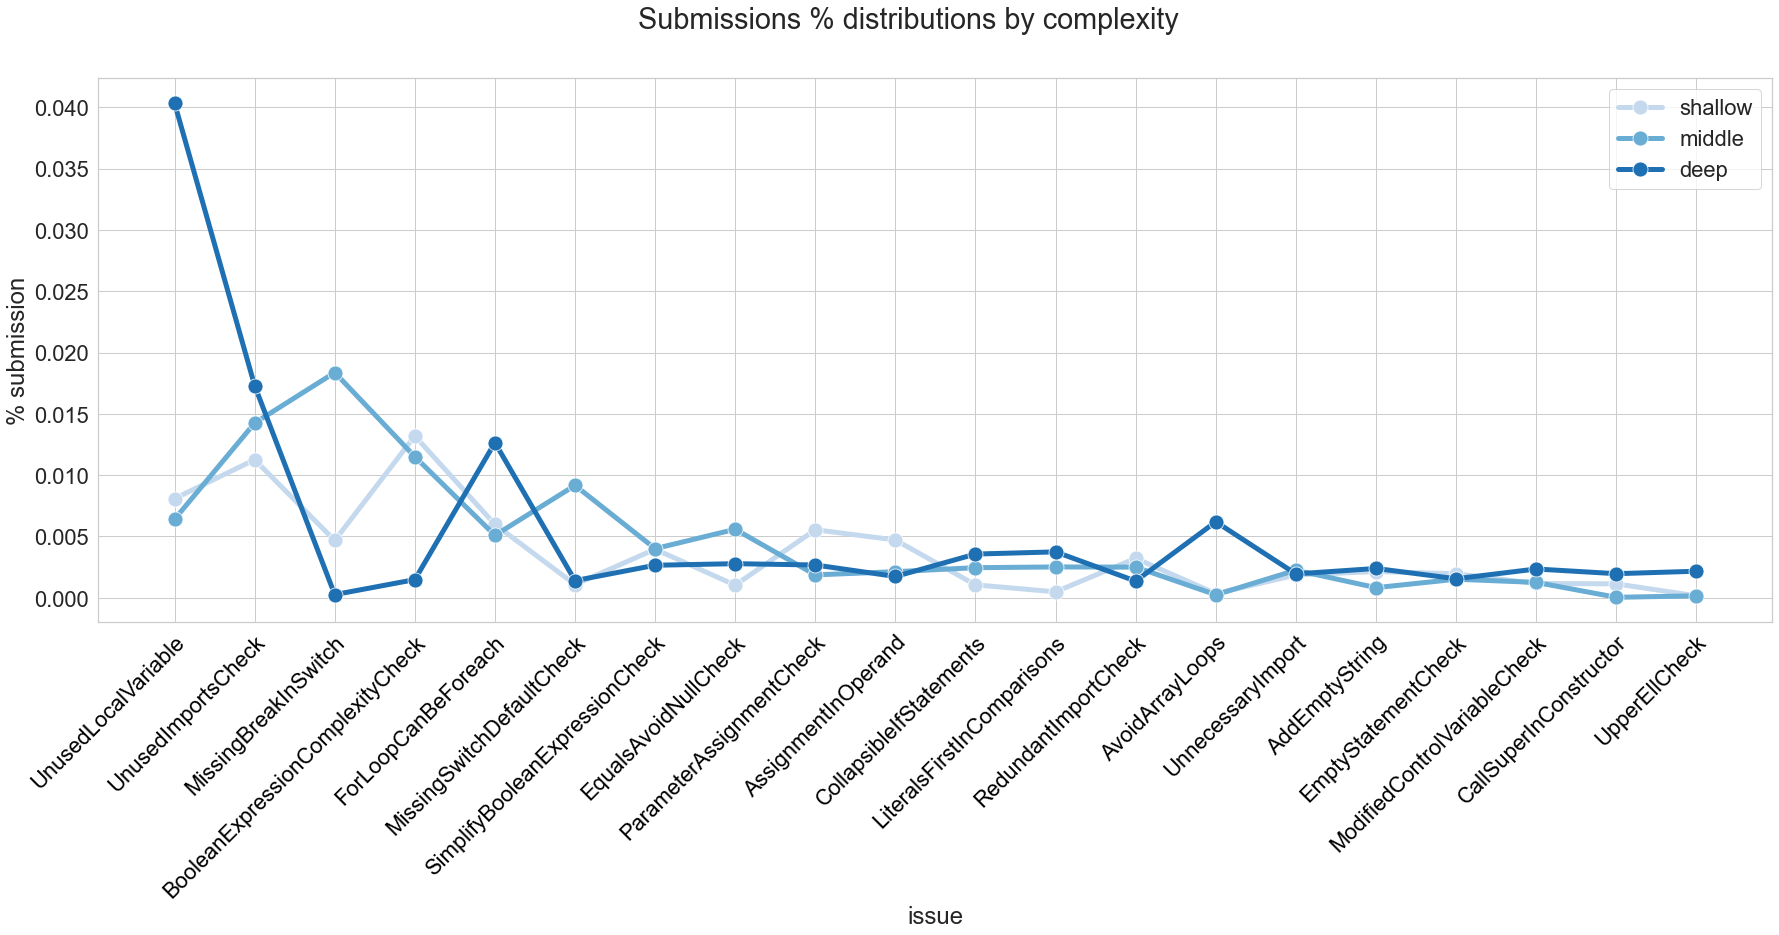

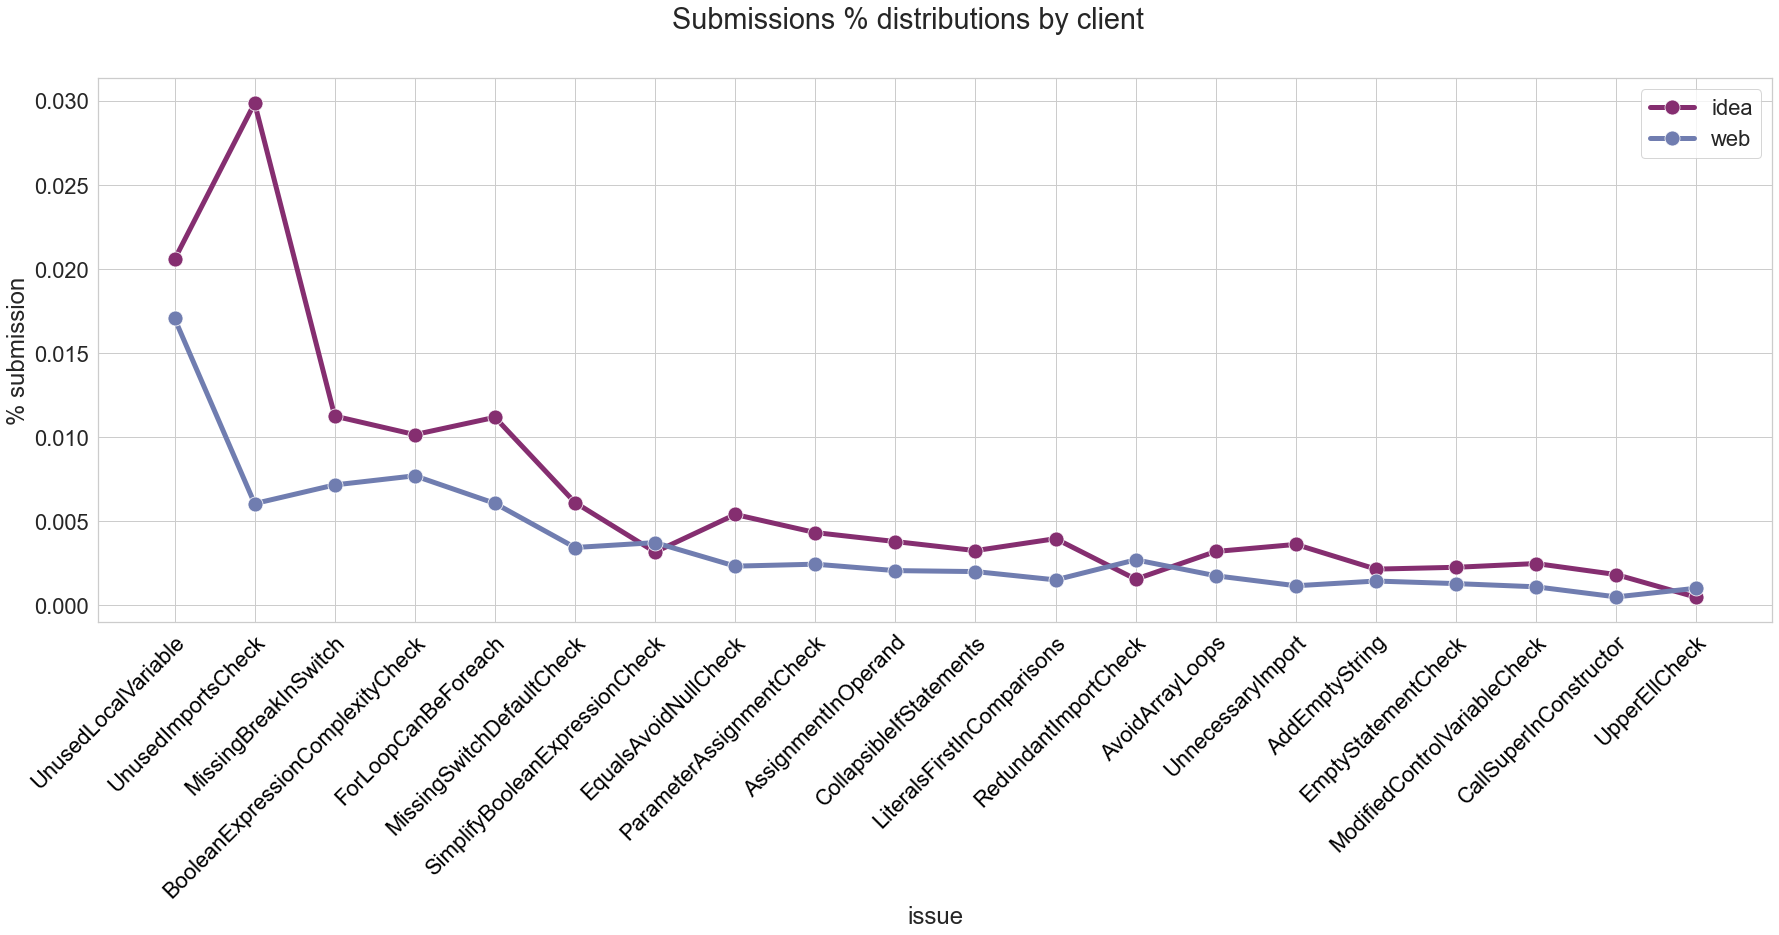

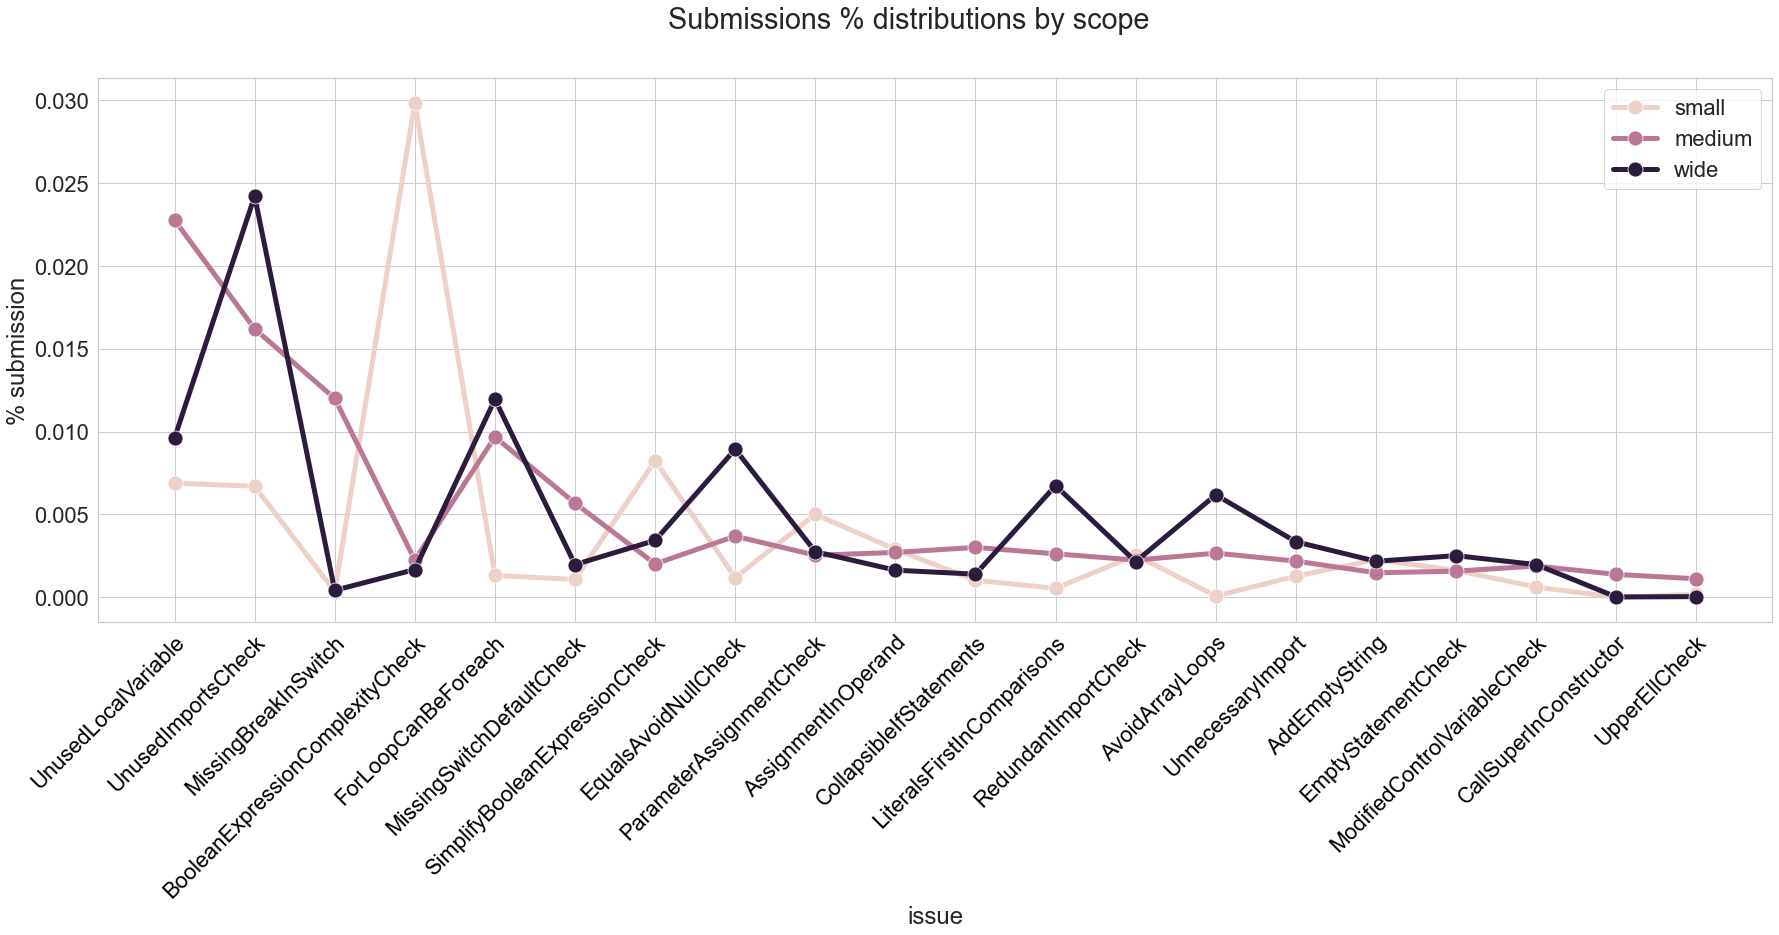

In [62]:
draw_issues(df_first_attempt_hyperstyle_issues_stats_unique, 
            df_first_attempt_hyperstyle_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=FIRST_ATTEMPT_STATS_PATH)

In [63]:
df_first_attempt_hyperstyle_issues_stats['hyperstyle_issues_count'] = \
    df_first_attempt_hyperstyle_issues_stats[df_first_attempt_hyperstyle_issues_top['name'].values].sum(axis=1)

df_first_attempt_hyperstyle_issues_stats['hyperstyle_issues_count_by_code_lines'] = \
    df_first_attempt_hyperstyle_issues_stats['hyperstyle_issues_count'] / \
    df_first_attempt_hyperstyle_issues_stats['code_lines_count']

df_first_attempt_hyperstyle_issues_stats_unique['hyperstyle_issues_count'] = \
    df_first_attempt_hyperstyle_issues_stats_unique[df_first_attempt_hyperstyle_issues_top['name'].values].sum(axis=1)

df_first_attempt_hyperstyle_issues_stats_unique['hyperstyle_issues_count_by_code_lines'] = \
    df_first_attempt_hyperstyle_issues_stats_unique['hyperstyle_issues_count'] / \
    df_first_attempt_hyperstyle_issues_stats_unique['code_lines_count']

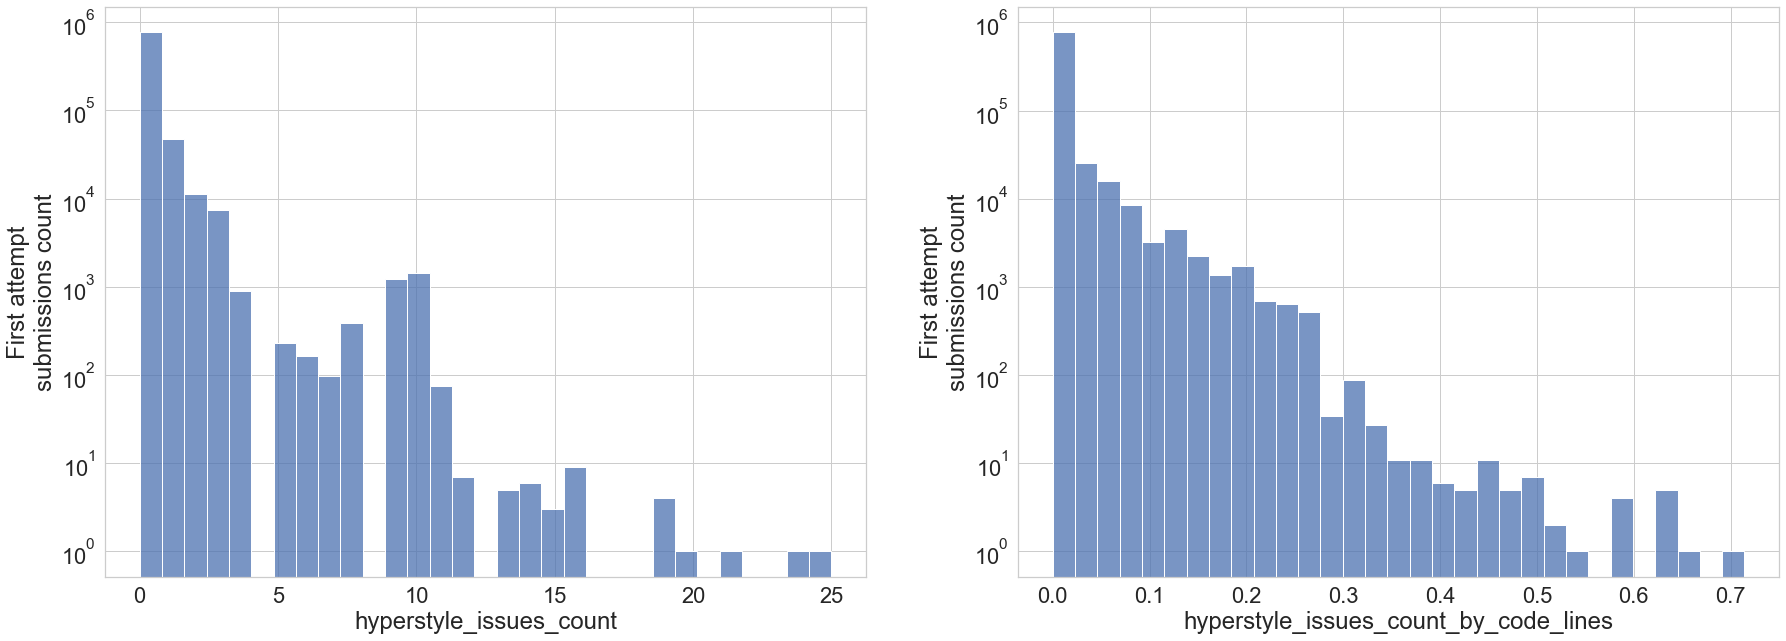

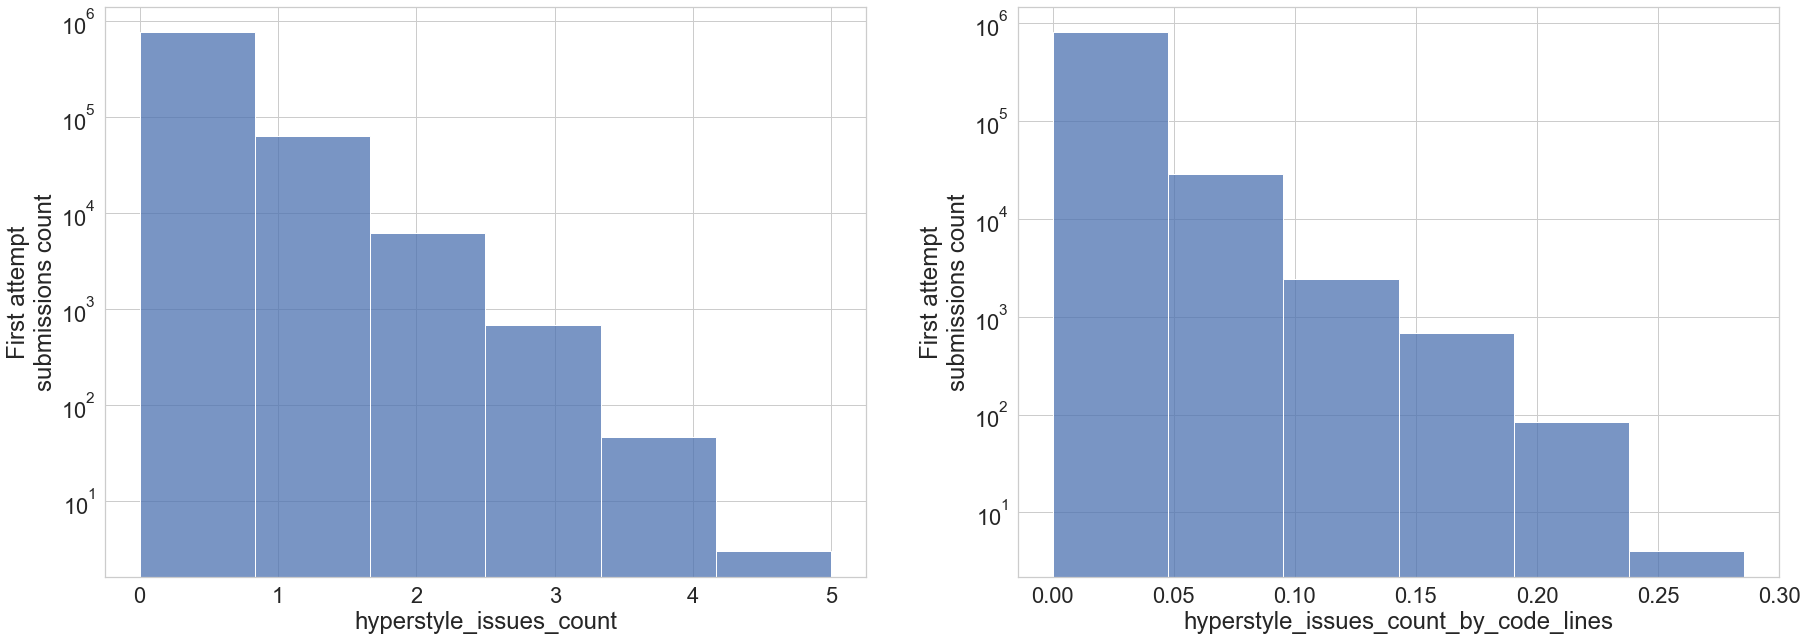

In [64]:
draw_hist_plots(df_first_attempt_hyperstyle_issues_stats, 
                ['hyperstyle_issues_count', 'hyperstyle_issues_count_by_code_lines'], q=1, 
                bins=df_first_attempt_hyperstyle_issues_stats['hyperstyle_issues_count'].max(), 
                log_scale=(False, True),
                y_label='First attempt\nsubmissions count')

draw_hist_plots(df_first_attempt_hyperstyle_issues_stats_unique, 
                ['hyperstyle_issues_count', 'hyperstyle_issues_count_by_code_lines'], q=1, 
                bins=df_first_attempt_hyperstyle_issues_stats_unique['hyperstyle_issues_count'].max(), 
                log_scale=(False, True),
                y_label='First attempt\nsubmissions count')

## How many attempts student do depending on number of issues in first submission

In [66]:
df_first_attempt_hyperstyle_issues_stats_unique['hyperstyle_issues_count'].value_counts()

0    764434
1     63251
2      6150
3       689
4        47
5         3
6         1
Name: hyperstyle_issues_count, dtype: int64

In [67]:
df_first_attempt_hyperstyle_issues_stats_unique.groupby('hyperstyle_issues_count')['total_attempts'].mean()

hyperstyle_issues_count
0    1.250782
1    1.655247
2    1.764715
3    1.801161
4    1.787234
5    1.000000
6    1.000000
Name: total_attempts, dtype: float64

In [68]:
df_first_attempt_hyperstyle_issues_stats.groupby('hyperstyle_issues_count')['total_attempts'].mean()

hyperstyle_issues_count
0     1.250782
1     1.637736
2     1.757817
3     1.803930
4     1.714917
5     1.694323
6     1.739394
7     1.428571
8     1.470588
9     1.393295
10    1.458657
11    1.554054
12    1.285714
13    1.200000
14    1.500000
15    2.333333
16    1.444444
19    1.250000
20    2.000000
21    1.000000
24    1.000000
25    1.000000
31    2.000000
Name: total_attempts, dtype: float64

## Number of total attempts if issues presents in first submission

In [69]:
print('issue', 'average_attempts')
for issue in df_first_attempt_hyperstyle_issues_top['name'].values:
    average_attempts = \
        df_first_attempt_hyperstyle_issues_stats_unique[df_first_attempt_hyperstyle_issues_stats_unique[issue] > 0]['total_attempts'].mean()
    print(issue, average_attempts)

issue average_attempts
UnusedLocalVariable 1.7705400981996726
UnusedImportsCheck 1.6941020762676813
MissingBreakInSwitch 1.6237306996800667
BooleanExpressionComplexityCheck 1.677613191727222
ForLoopCanBeForeach 1.6509046677816634
MissingSwitchDefaultCheck 1.6273867975995635
SimplifyBooleanExpressionCheck 1.8256010836437522
EqualsAvoidNullCheck 1.597061909758657
ParameterAssignmentCheck 1.6178955453149002
AssignmentInOperand 1.4584821428571428
CollapsibleIfStatements 1.8365853658536586
LiteralsFirstInComparisons 1.5255767301905716
RedundantImportCheck 1.7620779220779221
AvoidArrayLoops 1.6559705418200947
UnnecessaryImport 1.6656891495601174
AddEmptyString 1.4985935302390998
EmptyStatementCheck 1.7704081632653061
ModifiedControlVariableCheck 1.650187265917603
CallSuperInConstructor 1.1723716381418092
UpperEllCheck 1.5911047345767575


## Issues/steps correlation

In [70]:
df_step_issues_correlation = df_first_attempt_hyperstyle_issues_stats_unique \
    .groupby('step_id')[df_first_attempt_hyperstyle_issues_top['name'].values] \
    .mean() \
    .reset_index()

df_step_issues_correlation

step_id  UnusedLocalVariable  UnusedImportsCheck  MissingBreakInSwitch  \
0       1926             0.037776            0.141766              0.000000   
1       1927             0.025442            0.084806              0.000000   
2       1928             0.020134            0.100671              0.000671   
3       1929             0.019163            0.092789              0.000504   
4       1930             0.062046            0.060726              0.000660   
..       ...                  ...                 ...                   ...   
410    14366             0.000000            0.007092              0.000000   
411    14367             0.000000            0.144000              0.000000   
412    14631             0.000000            0.025641              0.000000   
413    14632             0.000000            0.020619              0.000000   
414    15239             0.000000            0.000000              0.000000   

     BooleanExpressionComplexityCheck  ForLoopCanBeForeach  \
0                            0.000000             0.122241   
1                            0.000000             0.096820   
2                            0.000671             0.135570   
3                            0.007564             0.119012   
4                            0.001320             0.013201   
..                                ...                  ...   
410                          0.000000             0.000000   
411                          0.000000             0.000000   
412                          0.000000             0.000000   
413                          0.000000             0.000000   
414                          0.000000             0.000000   

     MissingSwitchDefaultCheck  SimplifyBooleanExpressionCheck  \
0                      0.00000                        0.000849   
1                      0.00000                        0.000000   
2                      0.00000                        0.000000   
3                      0.00000                        0.001009   
4                      0.00066                        0.036964   
..                         ...                             ...   
410                    0.00000                        0.000000   
411                    0.00000                        0.000000   
412                    0.00000                        0.000000   
413                    0.00000                        0.000000   
414                    0.00000                        0.000000   

     EqualsAvoidNullCheck  ParameterAssignmentCheck  ...  \
0                0.000000                  0.002547  ...   
1                0.000000                  0.000000  ...   
2                0.000000                  0.001342  ...   
3                0.000000                  0.000000  ...   
4                0.001980                  0.001320  ...   
..                    ...                       ...  ...   
410              0.489362                  0.000000  ...   
411              0.000000                  0.000000  ...   
412              0.000000                  0.000000  ...   
413              0.000000                  0.000000  ...   
414              0.000000                  0.000000  ...   

     CollapsibleIfStatements  LiteralsFirstInComparisons  \
0                   0.000000                    0.000000   
1                   0.000000                    0.000707   
2                   0.000000                    0.000000   
3                   0.000504                    0.000504   
4                   0.013201                    0.008581   
..                       ...                         ...   
410                 0.000000                    0.127660   
411                 0.000000                    0.000000   
412                 0.000000                    0.000000   
413                 0.000000                    0.000000   
414                 0.000000                    0.000000   

     RedundantImportCheck  AvoidArrayLoops  UnnecessaryImport  AddEmptyStrin

In [71]:
step_issues_dict = {'step_id': [],
                    'issue': [],
                    'ratio': [],
                   }

issues_steps_corr_path = os.path.join(FIRST_ATTEMPT_STATS_PATH, 'issues_steps_corr')
os.makedirs(issues_steps_corr_path, exist_ok=True)

for issue in df_first_attempt_hyperstyle_issues_top['name'].values:
    df = df_step_issues_correlation[['step_id', issue]].sort_values(by=issue, ascending=False)
    
    df.to_csv(os.path.join(issues_steps_corr_path, f'{issue}.csv'), index=False)
        
    for _, row in df.iterrows():
        step_issues_dict['step_id'].append(int(row['step_id']))
        step_issues_dict['issue'].append(issue)
        step_issues_dict['ratio'].append(row[issue])

df_step_issues_top = pd.DataFrame.from_dict(step_issues_dict)
df_step_issues_top.to_csv(os.path.join(FIRST_ATTEMPT_STATS_PATH, f'top_steps_issues.csv'), index=False)
df_step_issues_top

step_id                issue     ratio
0        3659  UnusedLocalVariable  0.886587
1        9057  UnusedLocalVariable  0.795904
2        5771  UnusedLocalVariable  0.354626
3        2357  UnusedLocalVariable  0.278443
4        7768  UnusedLocalVariable  0.174460
...       ...                  ...       ...
8295     2458        UpperEllCheck  0.000000
8296     2457        UpperEllCheck  0.000000
8297     2449        UpperEllCheck  0.000000
8298     2446        UpperEllCheck  0.000000
8299    15239        UpperEllCheck  0.000000

[8300 rows x 3 columns]

In [72]:
issues_steps_dist_path = os.path.join(FIRST_ATTEMPT_STATS_PATH, 'issues_steps_dist')
os.makedirs(issues_steps_dist_path, exist_ok=True)

for issue in df_first_attempt_hyperstyle_issues_top['name'].values:
    df = df_first_attempt_hyperstyle_issues_stats_unique[['step_id', issue]] \
            .groupby('step_id') \
            .sum() / df_first_attempt_hyperstyle_issues_stats_unique[issue].sum()
    
    df = df.reset_index()
    df = df[df[issue] > 0].sort_values(by=issue, ascending=False)
    df.to_csv(os.path.join(issues_steps_dist_path, f'{issue}.csv'), index=False)
        
    display(df.T)

353          262          289          182  \
step_id              9057.00000  3659.000000  3820.000000  2734.000000   
UnusedLocalVariable     0.37401     0.218527     0.018462     0.011522   

                            334          56          345          282  \
step_id              5771.00000  2221.000000  7768.00000  3789.000000   
UnusedLocalVariable     0.01054     0.007267     0.00635     0.006219   

                             4            58   ...          291          293  \
step_id              1930.000000  2226.000000  ...  3822.000000  3829.000000   
UnusedLocalVariable     0.006154     0.006154  ...     0.000065     0.000065   

                             296          328          331          335  \
step_id              4330.000000  5738.000000  5767.000000  5810.000000   
UnusedLocalVariable     0.000065     0.000065     0.000065     0.000065   

                             337          339          348           408  
step_id              5813.000000  6009.000000  8404.000000  14279.000000  
UnusedLocalVariable     0.000065     0.000065     0.000065      0.000065  

[2 rows x 318 columns]

94           0            21           266  \
step_id             2300.00000  1926.000000  2142.000000  3663.000000   
UnusedImportsCheck     0.03102     0.027628     0.022996     0.022831   

                            262          288         3            355  \
step_id             3659.000000  3813.000000  1929.00000  9098.000000   
UnusedImportsCheck     0.019522     0.016296     0.01522     0.014972   

                            357          356  ...           377           375  \
step_id             9261.000000  9099.000000  ...  11359.000000  11178.000000   
UnusedImportsCheck     0.013235     0.013152  ...      0.000083      0.000083   

                            268          300          306          318  \
step_id             3707.000000  4342.000000  4349.000000  5202.000000   
UnusedImportsCheck     0.000083     0.000083     0.000083     0.000083   

                            319          326           365          202  
step_id             5203.000000  5736.000000  10980.000000  2795.000000  
UnusedImportsCheck     0.000083     0.000083      0.000083     0.000083  

[2 rows x 374 columns]

92           184          91           256  \
step_id               2298.000000  2737.000000  2297.000000  3481.000000   
MissingBreakInSwitch     0.294617     0.170121     0.148978     0.134094   

                              93           185          94            382  \
step_id               2299.000000  2739.000000  2300.000000  11528.000000   
MissingBreakInSwitch     0.109056     0.057171     0.052163      0.004312   

                              43           199  ...          158          182  \
step_id               2192.000000  2784.000000  ...  2509.000000  2734.000000   
MissingBreakInSwitch     0.003895     0.002782  ...     0.000139     0.000139   

                              217          33           30           3    \
step_id               2852.000000  2168.000000  2165.000000  1929.000000   
MissingBreakInSwitch     0.000139     0.000139     0.000139     0.000139   

                              214          263          4            2    
step_id               2849.000000  3660.000000  1930.000000  1928.000000  
MissingBreakInSwitch     0.000139     0.000139     0.000139     0.000139  

[2 rows x 46 columns]

30           76           78   \
step_id                           2165.000000  2274.000000  2276.000000   
BooleanExpressionComplexityCheck     0.273197     0.209475     0.171744   

                                          251           367         283  \
step_id                           3328.000000  10989.000000  3791.00000   
BooleanExpressionComplexityCheck     0.079933      0.077278     0.02697   

                                          315          35           33   \
step_id                           5016.000000  2170.000000  2168.000000   
BooleanExpressionComplexityCheck     0.023197     0.016909     0.013835   

                                          75   ...         180         139  \
step_id                           2273.000000  ...  2721.00000  2449.00000   
BooleanExpressionComplexityCheck     0.011878  ...     0.00014     0.00014   

                                         129         118         72   \
step_id                           2423.00000  2349.00000  2265.00000   
BooleanExpressionComplexityCheck     0.00014     0.00014     0.00014   

                                         60          46          18   \
step_id                           2228.00000  2211.00000  2139.00000   
BooleanExpressionComplexityCheck     0.00014     0.00014     0.00014   

                                         6            399  
step_id                           1937.00000  12800.00000  
BooleanExpressionComplexityCheck     0.00014      0.00014  

[2 rows x 67 columns]

288          13           11           0    \
step_id              3813.000000  2134.000000  2132.000000  1926.000000   
ForLoopCanBeForeach     0.091531     0.047134     0.045918     0.043789   

                             266          285          3            10   \
step_id              3663.000000  3794.000000  1929.000000  2131.000000   
ForLoopCanBeForeach     0.037251     0.036795     0.035883     0.033602   

                             5            263  ...          66           313  \
step_id              1936.000000  3660.000000  ...  2237.000000  5012.000000   
ForLoopCanBeForeach     0.031625     0.031017  ...     0.000152     0.000152   

                             44           272          273          200  \
step_id              2193.000000  3722.000000  3736.000000  2793.000000   
ForLoopCanBeForeach     0.000152     0.000152     0.000152     0.000152   

                             295          294          199          91   
step_id              4329.000000  3830.000000  2784.000000  2297.000000  
ForLoopCanBeForeach     0.000152     0.000152     0.000152     0.000152  

[2 rows x 161 columns]

94           185          43   \
step_id                    2300.000000  2739.000000  2192.000000   
MissingSwitchDefaultCheck     0.351064     0.305237     0.059465   

                                    382         342          45           250  \
step_id                    11528.000000  7004.00000  2194.000000  3325.000000   
MissingSwitchDefaultCheck      0.046372     0.03437     0.031369     0.023732   

                                   331          199          194  ...  \
step_id                    5767.000000  2784.000000  2767.000000  ...   
MissingSwitchDefaultCheck     0.021822     0.019913     0.016094  ...   

                                   334          245          243          89   \
step_id                    5771.000000  3126.000000  3123.000000  2295.000000   
MissingSwitchDefaultCheck     0.000273     0.000273     0.000273     0.000273   

                                   90           270          7            262  \
step_id                    2296.000000  3717.000000  1947.000000  3659.000000   
MissingSwitchDefaultCheck     0.000273     0.000273     0.000273     0.000273   

                                   237          4    
step_id                    2922.000000  1930.000000  
MissingSwitchDefaultCheck     0.000273     0.000273  

[2 rows x 48 columns]

78           188          289  \
step_id                         2276.000000  2744.000000  3820.000000   
SimplifyBooleanExpressionCheck     0.296309     0.143244     0.075516   

                                       182          5            249  \
step_id                         2734.00000  1936.000000  3324.000000   
SimplifyBooleanExpressionCheck     0.06705     0.036234     0.031832   

                                        4            32         76   \
step_id                         1930.000000  2167.000000  2274.0000   
SimplifyBooleanExpressionCheck     0.018964     0.015916     0.0149   

                                        81   ...          128          141  \
step_id                         2283.000000  ...  2422.000000  2458.000000   
SimplifyBooleanExpressionCheck     0.013207  ...     0.000339     0.000339   

                                        192          213          217  \
step_id                         2765.000000  2848.000000  2852.000000   
SimplifyBooleanExpressionCheck     0.000339     0.000339     0.000339   

                                        247          251          256  \
step_id                         3235.000000  3328.000000  3481.000000   
SimplifyBooleanExpressionCheck     0.000339     0.000339     0.000339   

                                        260           382  
step_id                         3655.000000  11528.000000  
SimplifyBooleanExpressionCheck     0.000339      0.000339  

[2 rows x 121 columns]

145          331          249          263  \
step_id               2481.000000  5767.000000  3324.000000  3660.000000   
EqualsAvoidNullCheck     0.386499     0.069955     0.056663     0.051417   

                             177          356          178          112  \
step_id               2717.00000  9099.000000  2718.000000  2343.000000   
EqualsAvoidNullCheck     0.04547     0.037076     0.033928     0.025533   

                              78            410  ...         167         58   \
step_id               2276.000000  14366.000000  ...  2550.00000  2226.00000   
EqualsAvoidNullCheck     0.025184      0.024134  ...     0.00035     0.00035   

                             59          66          184         306  \
step_id               2227.00000  2237.00000  2737.00000  4349.00000   
EqualsAvoidNullCheck     0.00035     0.00035     0.00035     0.00035   

                             305         104         139         234  
step_id               4348.00000  2326.00000  2449.00000  2899.00000  
EqualsAvoidNullCheck     0.00035     0.00035     0.00035     0.00035  

[2 rows x 98 columns]

368          72           7    \
step_id                   10990.000000  2265.000000  1947.000000   
ParameterAssignmentCheck      0.137865     0.087942     0.084101   

                                   400          251          250  \
step_id                   13206.000000  3328.000000  3325.000000   
ParameterAssignmentCheck      0.077189     0.061444     0.056068   

                                   367           372           373  \
step_id                   10989.000000  10994.000000  10995.000000   
ParameterAssignmentCheck      0.054147      0.051459      0.041475   

                                  197  ...          238          63   \
step_id                   2782.000000  ...  2923.000000  2231.000000   
ParameterAssignmentCheck     0.034562  ...     0.000384     0.000384   

                                  253          254          259          260  \
step_id                   3331.000000  3475.000000  3654.000000  3655.000000   
ParameterAssignmentCheck     0.000384     0.000384     0.000384     0.000384   

                                  44           41           271          188  
step_id                   2193.000000  2190.000000  3719.000000  2744.000000  
ParameterAssignmentCheck     0.000384     0.000384     0.000384     0.000384  

[2 rows x 147 columns]

182          23           181          59   \
step_id              2734.000000  2153.000000  2731.000000  2227.000000   
AssignmentInOperand     0.216964     0.098661     0.068304     0.048661   

                             145          354          355        62   \
step_id              2481.000000  9097.000000  9098.000000  2230.0000   
AssignmentInOperand     0.047768     0.043304     0.039732     0.0375   

                            356          63   ...          141          180  \
step_id              9099.00000  2231.000000  ...  2458.000000  2721.000000   
AssignmentInOperand     0.03125     0.028571  ...     0.000446     0.000446   

                             188          200          212          239  \
step_id              2744.000000  2793.000000  2847.000000  2924.000000   
AssignmentInOperand     0.000446     0.000446     0.000446     0.000446   

                             251          252          256          177  
step_id              3328.000000  3329.000000  3481.000000  2717.000000  
AssignmentInOperand     0.000446     0.000446     0.000446     0.000446  

[2 rows x 128 columns]

40           58           8            9    \
step_id                  2189.000000  2226.000000  2129.000000  2130.000000   
CollapsibleIfStatements     0.247317     0.192683     0.094634     0.086829   

                                 20           182          83           35   \
step_id                  2141.000000  2734.000000  2286.000000  2170.000000   
CollapsibleIfStatements     0.034634     0.029756     0.019024     0.016585   

                                 19           5    ...          80   \
step_id                  2140.000000  1936.000000  ...  2282.000000   
CollapsibleIfStatements     0.016585     0.014146  ...     0.000488   

                                 118          142          183          197  \
step_id                  2349.000000  2472.000000  2735.000000  2782.000000   
CollapsibleIfStatements     0.000488     0.000488     0.000488     0.000488   

                                 230          231          243          249  \
step_id                  2894.000000  2895.000000  3123.000000  3324.000000   
CollapsibleIfStatements     0.000488     0.000488     0.000488     0.000488   

                                  399  
step_id                  12800.000000  
CollapsibleIfStatements      0.000488  

[2 rows x 101 columns]

263          350          145  \
step_id                     3660.000000  8418.000000  2481.000000   
LiteralsFirstInComparisons     0.215145     0.134905     0.118355   

                                    177          178          112  \
step_id                     2717.000000  2718.000000  2343.000000   
LiteralsFirstInComparisons     0.065196     0.054664     0.054664   

                                    356          85           212  \
step_id                     9099.000000  2291.000000  2847.000000   
LiteralsFirstInComparisons     0.045637     0.034604     0.025577   

                                    83   ...          269          206  \
step_id                     2286.000000  ...  3709.000000  2833.000000   
LiteralsFirstInComparisons     0.022066  ...     0.000502     0.000502   

                                    62           285          286  \
step_id                     2230.000000  3794.000000  3795.000000   
LiteralsFirstInComparisons     0.000502     0.000502     0.000502   

                                    184          59           290  \
step_id                     2737.000000  2227.000000  3821.000000   
LiteralsFirstInComparisons     0.000502     0.000502     0.000502   

                                    291          1    
step_id                     3822.000000  1927.000000  
LiteralsFirstInComparisons     0.000502     0.000502  

[2 rows x 90 columns]

94           33          0            41   \
step_id               2300.000000  2168.000000  1926.00000  2190.000000   
RedundantImportCheck     0.188571     0.070649     0.05039     0.049351   

                               371          287          60           143  \
step_id               10993.000000  3796.000000  2228.000000  2473.000000   
RedundantImportCheck      0.049351     0.031169     0.024935     0.022857   

                             55           166  ...          69           226  \
step_id               2220.00000  2549.000000  ...  2245.000000  2871.000000   
RedundantImportCheck     0.02026     0.017662  ...     0.000519     0.000519   

                              225          224          219          213  \
step_id               2864.000000  2863.000000  2858.000000  2848.000000   
RedundantImportCheck     0.000519     0.000519     0.000519     0.000519   

                              210          209          208           404  
step_id               2845.000000  2844.000000  2843.000000  13518.000000  
RedundantImportCheck     0.000519     0.000519     0.000519      0.000519  

[2 rows x 202 columns]

12           21           266         252  \
step_id          2133.000000  2142.000000  3663.000000  3329.00000   
AvoidArrayLoops     0.323514     0.226723     0.163598     0.16202   

                         69           2            81           1    \
step_id          2245.000000  1928.000000  2283.000000  1927.000000   
AvoidArrayLoops     0.015781     0.014729     0.009995     0.009469   

                         355          87   ...          33           94   \
step_id          9098.000000  2293.000000  ...  2168.000000  2300.000000   
AvoidArrayLoops     0.007365     0.005786  ...     0.000526     0.000526   

                         236          124          145          173  \
step_id          2921.000000  2357.000000  2481.000000  2706.000000   
AvoidArrayLoops     0.000526     0.000526     0.000526     0.000526   

                         188          203          233          113  
step_id          2744.000000  2797.000000  2898.000000  2344.000000  
AvoidArrayLoops     0.000526     0.000526     0.000526     0.000526  

[2 rows x 60 columns]

94           0            33           355  \
step_id            2300.000000  1926.000000  2168.000000  9098.000000   
UnnecessaryImport     0.055132     0.039883     0.034604     0.020528   

                           356          354          287          21   \
step_id            9099.000000  9097.000000  3796.000000  2142.000000   
UnnecessaryImport     0.018182     0.015836     0.015249     0.014663   

                          266           371  ...          184          185  \
step_id            3663.00000  10993.000000  ...  2737.000000  2739.000000   
UnnecessaryImport     0.01349      0.012903  ...     0.000587     0.000587   

                           305          311          34           309  \
step_id            4348.000000  4941.000000  2169.000000  4939.000000   
UnnecessaryImport     0.000587     0.000587     0.000587     0.000587   

                           102          35           306           411  
step_id            2324.000000  2170.000000  4349.000000  14367.000000  
UnnecessaryImport     0.000587     0.000587     0.000587      0.000587  

[2 rows x 296 columns]

52          88          86           31           87   \
step_id         2217.000000  2294.00000  2292.00000  2166.000000  2293.000000   
AddEmptyString     0.198312     0.16315     0.12166     0.038678     0.028833   

                       312          44            367          93   \
step_id         5011.00000  2193.000000  10989.000000  2299.000000   
AddEmptyString     0.02391     0.017581      0.015471     0.015471   

                        145  ...          203          182          1    \
step_id         2481.000000  ...  2797.000000  2734.000000  1927.000000   
AddEmptyString     0.015471  ...     0.000703     0.000703     0.000703   

                        180          170          166          143  \
step_id         2721.000000  2703.000000  2549.000000  2473.000000   
AddEmptyString     0.000703     0.000703     0.000703     0.000703   

                        142          124          181  
step_id         2472.000000  2357.000000  2731.000000  
AddEmptyString     0.000703     0.000703     0.000703  

[2 rows x 129 columns]

180          280          23           182  \
step_id              2721.000000  3787.000000  2153.000000  2734.000000   
EmptyStatementCheck     0.032799     0.026968     0.022595     0.021137   

                             64           93           60           61   \
step_id              2234.000000  2299.000000  2228.000000  2229.000000   
EmptyStatementCheck     0.019679     0.016764     0.016035     0.014577   

                             62          145  ...          233          232  \
step_id              2230.000000  2481.00000  ...  2898.000000  2896.000000   
EmptyStatementCheck     0.013848     0.01312  ...     0.000729     0.000729   

                             230          226          225          220  \
step_id              2894.000000  2871.000000  2864.000000  2859.000000   
EmptyStatementCheck     0.000729     0.000729     0.000729     0.000729   

                             217          213          204           408  
step_id              2852.000000  2848.000000  2798.000000  14279.000000  
EmptyStatementCheck     0.000729     0.000729     0.000729      0.000729  

[2 rows x 257 columns]

288          283          84   \
step_id                       3813.000000  3791.000000  2288.000000   
ModifiedControlVariableCheck     0.194757     0.109363     0.081648   

                                      257          86          289  \
step_id                       3482.000000  2292.000000  3820.00000   
ModifiedControlVariableCheck     0.059176     0.057678     0.04794   

                                      312          311          4    \
step_id                       5011.000000  4941.000000  1930.000000   
ModifiedControlVariableCheck     0.044195     0.041199     0.035955   

                                      282  ...          123          38   \
step_id                       3789.000000  ...  2355.000000  2187.000000   
ModifiedControlVariableCheck     0.028464  ...     0.000749     0.000749   

                                      145          181          185  \
step_id                       2481.000000  2731.000000  2739.000000   
ModifiedControlVariableCheck     0.000749     0.000749     0.000749   

                                      194          233          234  \
step_id                       2767.000000  2898.000000  2899.000000   
ModifiedControlVariableCheck     0.000749     0.000749     0.000749   

                                      31            364  
step_id                       2166.000000  10613.000000  
ModifiedControlVariableCheck     0.000749      0.000749  

[2 rows x 98 columns]

330          341          327          328  \
step_id                 5765.000000  6011.000000  5737.000000  5738.000000   
CallSuperInConstructor     0.607579     0.273839     0.030562     0.028117   

                                340          339         94          326  \
step_id                 6010.000000  6009.000000  2300.00000  5736.00000   
CallSuperInConstructor     0.017115     0.013447     0.00978     0.00489   

                                329          264          261          258  \
step_id                 5764.000000  3661.000000  3658.000000  3653.000000   
CallSuperInConstructor     0.002445     0.001222     0.001222     0.001222   

                                251          245          332          333  \
step_id                 3328.000000  3126.000000  5768.000000  5769.000000   
CallSuperInConstructor     0.001222     0.001222     0.001222     0.001222   

                                159          105          0    
step_id                 2519.000000  2329.000000  1926.000000  
CallSuperInConstructor     0.001222     0.001222     0.001222

175          25           186           368  \
step_id        2708.000000  2160.000000  2742.000000  10990.000000   
UpperEllCheck     0.780488     0.057389     0.050215      0.030129   

                       61            372          163          93   \
step_id        2229.000000  10994.000000  2542.000000  2299.000000   
UpperEllCheck     0.022956      0.010043     0.008608     0.008608   

                       255          136  ...          356           369  \
step_id        3479.000000  2440.000000  ...  9099.000000  10991.000000   
UpperEllCheck     0.002869     0.002869  ...     0.001435      0.001435   

                        360          16           286          251  \
step_id        10237.000000  2137.000000  3795.000000  3328.000000   
UpperEllCheck      0.001435     0.001435     0.001435     0.001435   

                       208          45           41            382  
step_id        2843.000000  2194.000000  2190.000000  11528.000000  
UpperEllCheck     0.001435     0.001435     0.001435      0.001435  

[2 rows x 24 columns]

# Last attempt stats

Last attempt submissions is when **attempt** == **total_attemps** - final result of all attemps. This shows what issues student do not fix and leave in their final solutions.

In [73]:
df_last_attempt_stats = df_submissions_stats[df_submissions_stats['attempt'] == df_submissions_stats['total_attempts']]
df_last_attempt_stats.describe()

id  code_lines_count  code_symbols_count        step_id  \
count  8.345750e+05     834575.000000       834575.000000  834575.000000   
mean   4.274333e+07         19.284431          514.749106    3564.302187   
std    7.896427e+06         19.601680          511.520300    2400.881303   
min    2.938134e+07          1.000000           91.000000    1926.000000   
25%    3.575094e+07         10.000000          248.000000    2272.000000   
50%    4.266003e+07         15.000000          396.000000    2509.000000   
75%    4.976481e+07         22.000000          597.000000    3752.000000   
max    5.639778e+07       2366.000000        81399.000000   15239.000000   

        sync_counter        user_id         group        attempt  \
count  834575.000000  834575.000000  8.345750e+05  834575.000000   
mean        8.394936    8592.311883  5.522554e+05       1.285706   
std         1.627423    8034.311124  3.082742e+05       0.673806   
min         2.000000       0.000000  0.000000e+00       1.000000   
25%         7.000000    2363.000000  2.787975e+05       1.000000   
50%         8.000000    5901.000000  5.746260e+05       1.000000   
75%         9.000000   13224.000000  8.246625e+05       1.000000   
max        22.000000   82397.000000  1.055200e+06       5.000000   

       total_attempts  
count   834575.000000  
mean         1.285706  
std          0.673806  
min          1.000000  
25%          1.000000  
50%          1.000000  
75%          1.000000  
max          5.000000

In [74]:
print(df_last_attempt_stats.shape[0] == df_first_attempt_stats.shape[0])

True


### Last attempt statistics

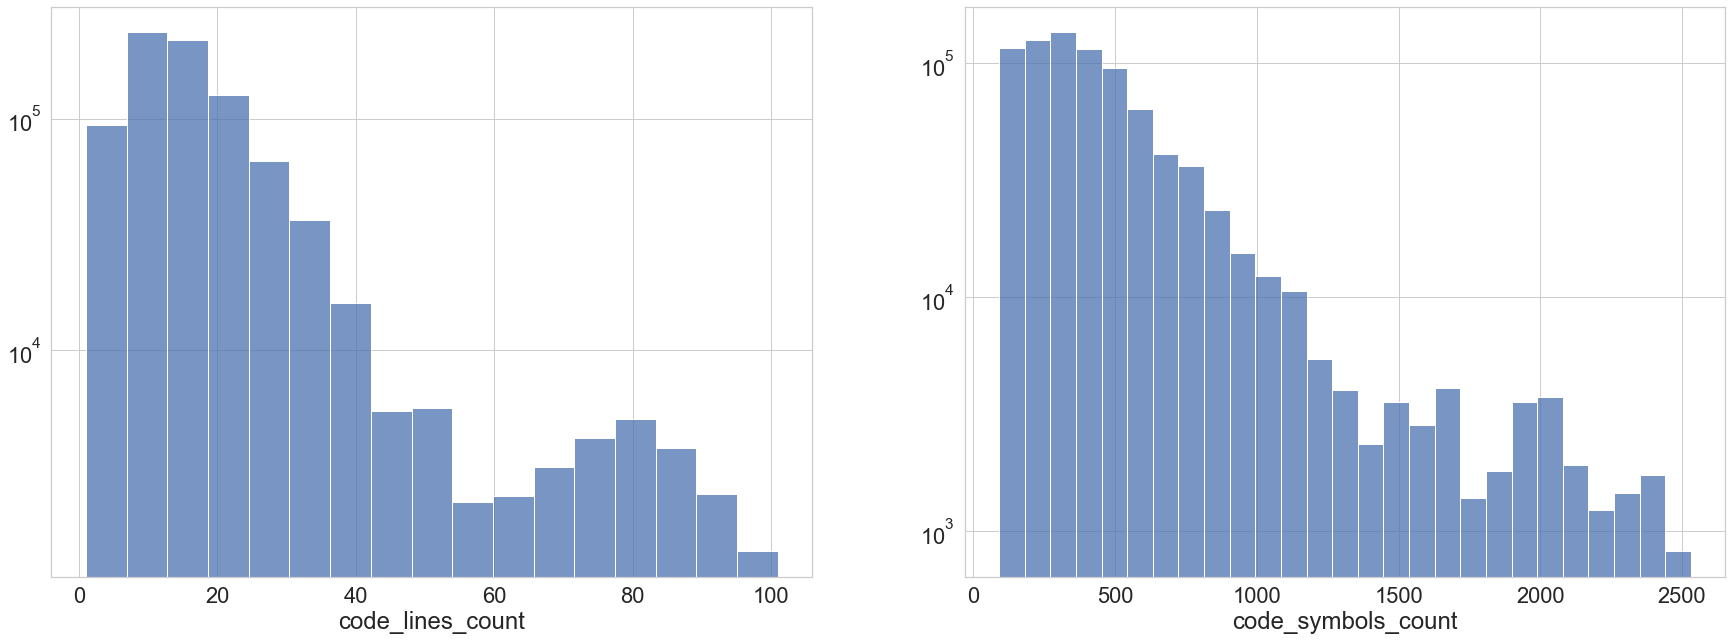

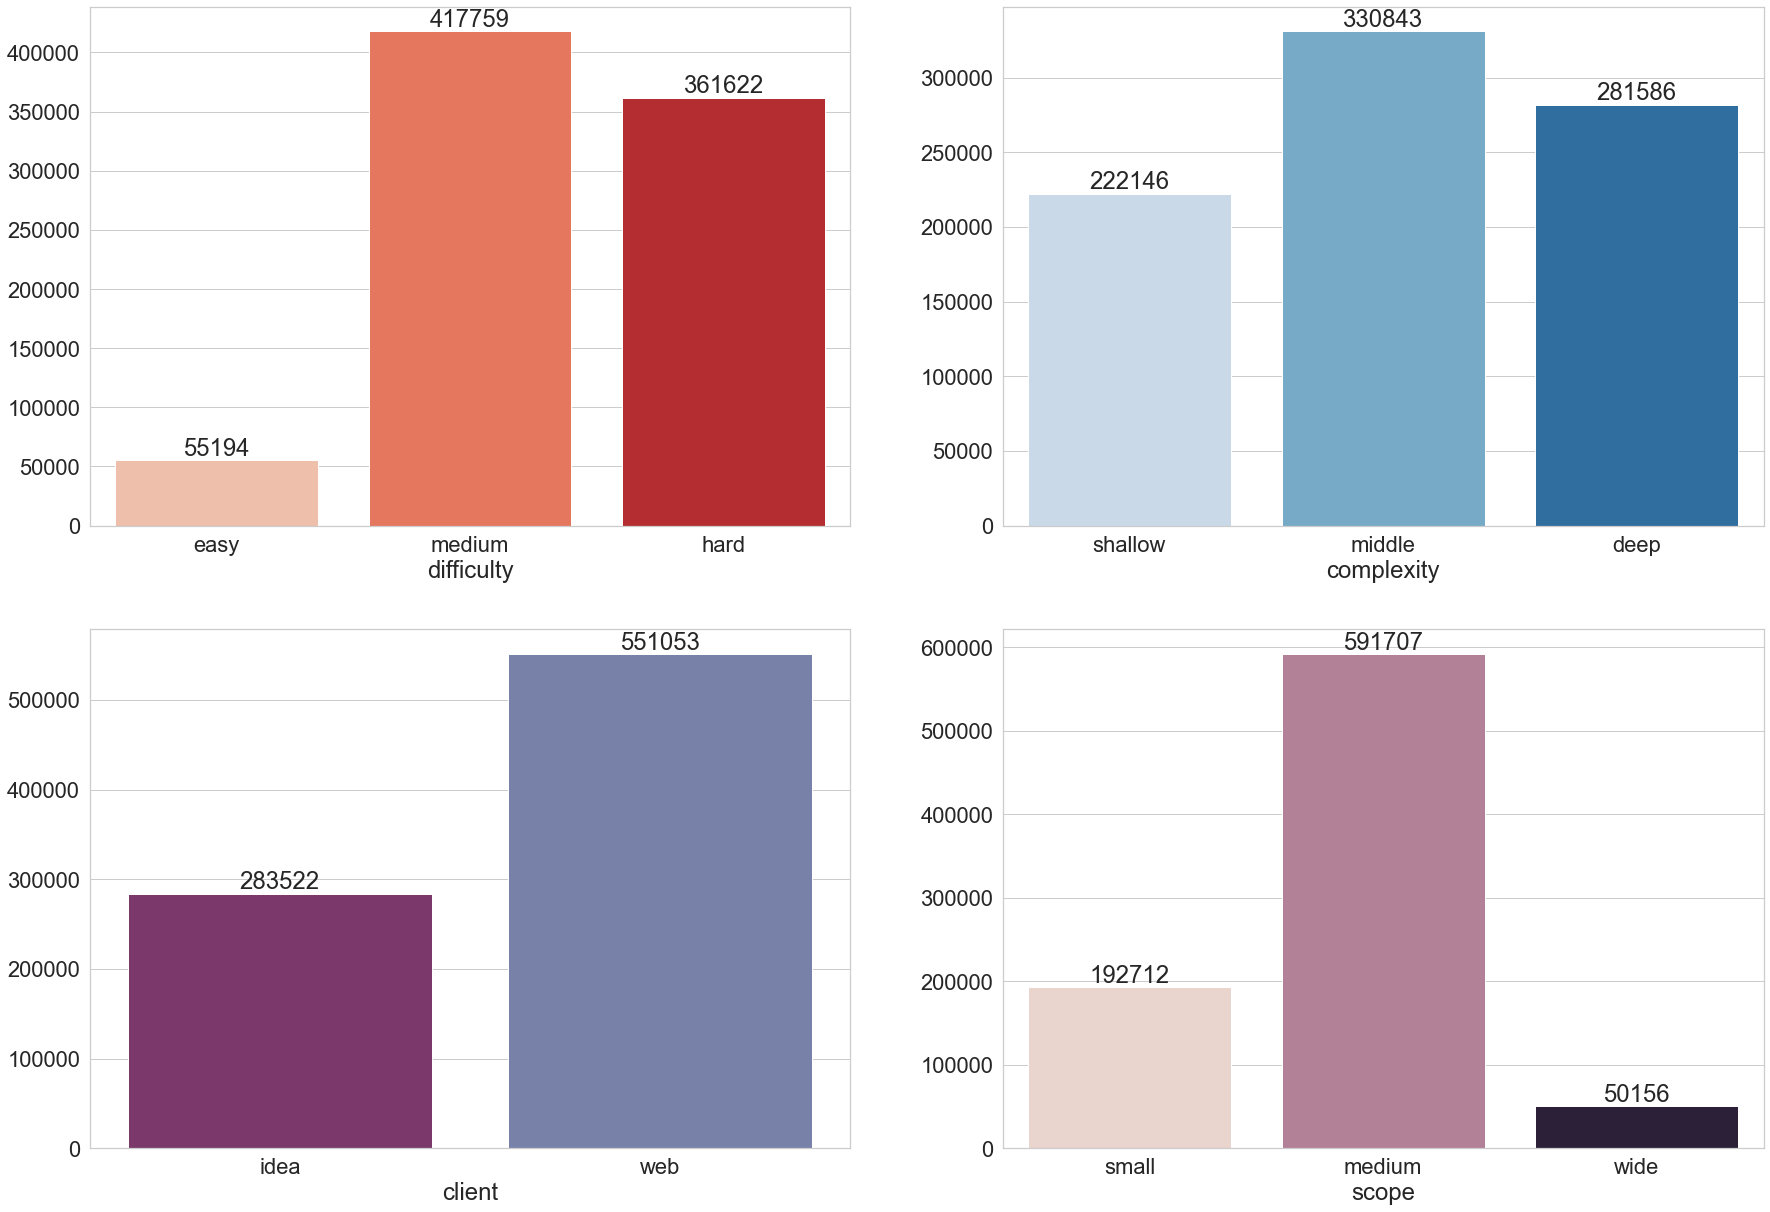

In [75]:
draw_hist_plots(df_last_attempt_stats, ['code_lines_count', 'code_symbols_count'], 
                log_scale=(False, True))
draw_count_plots(df_last_attempt_stats, ['difficulty', 'complexity', 'client', 'scope'])

In [76]:
df_last_attempt_hyperstyle_issues_stats = merge_dfs(df_last_attempt_stats, 
                                                    df_hyperstyle_issues_stats, 
                                                    left_on='id', right_on='id')

df_last_attempt_hyperstyle_issues_stats_unique = merge_dfs(df_last_attempt_stats, 
                                                           df_hyperstyle_issues_stats_unique, 
                                                           left_on='id', right_on='id')

### Hyperstyle issues analysis in last attempt. Percent of submissions with each issue.

In [77]:
def sort_by_order(df: pd.DataFrame, column: str, order: List[str]) -> pd.DataFrame:
    df_order = pd.DataFrame.from_dict({'order': order})
    return merge_dfs(df_order, df, left_on='order', right_on=column).drop(columns=['order'])

In [78]:
df_last_attempt_hyperstyle_issues_top = get_top_issues(df_last_attempt_hyperstyle_issues_stats_unique, 
                                          df_first_attempt_hyperstyle_issues_top, 
                                          len(df_first_attempt_hyperstyle_issues_top), 
                                          hyperstyle_issues_ignore_names)

df_last_attempt_hyperstyle_issues_top = sort_by_order(df_last_attempt_hyperstyle_issues_top,
                                                      'name',
                                                      df_first_attempt_hyperstyle_issues_top['name'].values)
                                                       
df_last_attempt_hyperstyle_issues_top.to_csv(os.path.join(LAST_ATTEMPT_STATS_PATH, f'top_issues.csv'), index=False)
df_last_attempt_hyperstyle_issues_top

name  count        category  \
0                UnusedLocalVariable   9812  BEST_PRACTICES   
1                 UnusedImportsCheck   7315  BEST_PRACTICES   
2               MissingBreakInSwitch   4721     ERROR_PRONE   
3   BooleanExpressionComplexityCheck   6085  BEST_PRACTICES   
4                ForLoopCanBeForeach   4750  BEST_PRACTICES   
5          MissingSwitchDefaultCheck   2421     ERROR_PRONE   
6     SimplifyBooleanExpressionCheck   1954  BEST_PRACTICES   
7               EqualsAvoidNullCheck   2078  BEST_PRACTICES   
8           ParameterAssignmentCheck   1796  BEST_PRACTICES   
9                AssignmentInOperand   2336     ERROR_PRONE   
10           CollapsibleIfStatements   1289  BEST_PRACTICES   
11        LiteralsFirstInComparisons   1799  BEST_PRACTICES   
12              RedundantImportCheck   1173  BEST_PRACTICES   
13                   AvoidArrayLoops   1584  BEST_PRACTICES   
14                 UnnecessaryImport   1088  BEST_PRACTICES   
15                    AddEmptyString   1403  BEST_PRACTICES   
16               EmptyStatementCheck    789     ERROR_PRONE   
17      ModifiedControlVariableCheck   1100  BEST_PRACTICES   
18            CallSuperInConstructor    812  BEST_PRACTICES   
19                     UpperEllCheck    480  BEST_PRACTICES   

                                                 text difficulty  \
0        Avoid unused local variables such as 'unit'.     MEDIUM   
1                    Unused import - javax.print.Doc.     MEDIUM   
2         A switch statement does not contain a break       HARD   
3   Too long boolean expression. Try to split it i...       EASY   
4     This for loop can be replaced by a foreach loop     MEDIUM   
5                    switch without "default" clause.       HARD   
6                       Expression can be simplified.     MEDIUM   
7   String literal expressions should be on the le...     MEDIUM   
8      Assignment of parameter 'str1' is not allowed.     MEDIUM   
9                       Avoid assignments in operands       HARD   
10  These nested if statements could be combined b...     MEDIUM   
11      Position literals first in String comparisons     MEDIUM   
12  Redundant import from the java.lang package - ...     MEDIUM   
13                 System.arraycopy is more efficient     MEDIUM   
14                 Unused import 'java.util.stream.*'     MEDIUM   
15                           Do not add empty strings     MEDIUM   
16                                   Empty statement.       HARD   
17                  Control variable 'j' is modified.     MEDIUM   
18  It is a good practice to call super() in a con...     MEDIUM   
19                          Should use uppercase 'L'.     MEDIUM   

                                          code_sample     ratio  
0   import javax.print.Doc;\n\nclass Army {\n\n   ...  0.011757  
1   import javax.print.Doc; // UnusedImportsCheck ...  0.008765  
2   import java.util.Scanner;\n\nclass Main {\n   ...  0.005657  
3   import java.util.*;\n\npublic class Main {\n  ...  0.007291  
4   import java.util.Scanner;\n\nclass Main {\n   ...  0.005692  
5   import java.util.Scanner;\n\nclass Main {\n   ...  0.002901  
6   import java.util.Scanner;\n\nclass Main {\n   ...  0.002341  
7   import java.util.Scanner;\nclass Main {\n    s...  0.002490  
8   import java.util.Scanner;\n\n\npublic class Ma...  0.002152  
9   import java.io.BufferedReader;\nimport java.io...  0.002799  
10  import java.util.Scanner;\n\nclass Main {\n   ...  0.001544  
11  import java.util.Scanner;\n\nclass Main {\n   ...  0.002156  
12  import java.util.*;\nimport java.lang.*; // Re...  0.001406  
13  import java.util.Scanner;\n\nclass SelectionCo...  0.001898  
14   import java.util.*;\n import java.util.stream...  0.001304  
15  import java.util.*;\nclass Main {\n    public ...  0.001681  
16  public class Main {\n\n    public static void ...  0.000945  
17  import java.util.Scanner;\n\nclass Concatenate...  0.001318  
18  import java.util.Loca

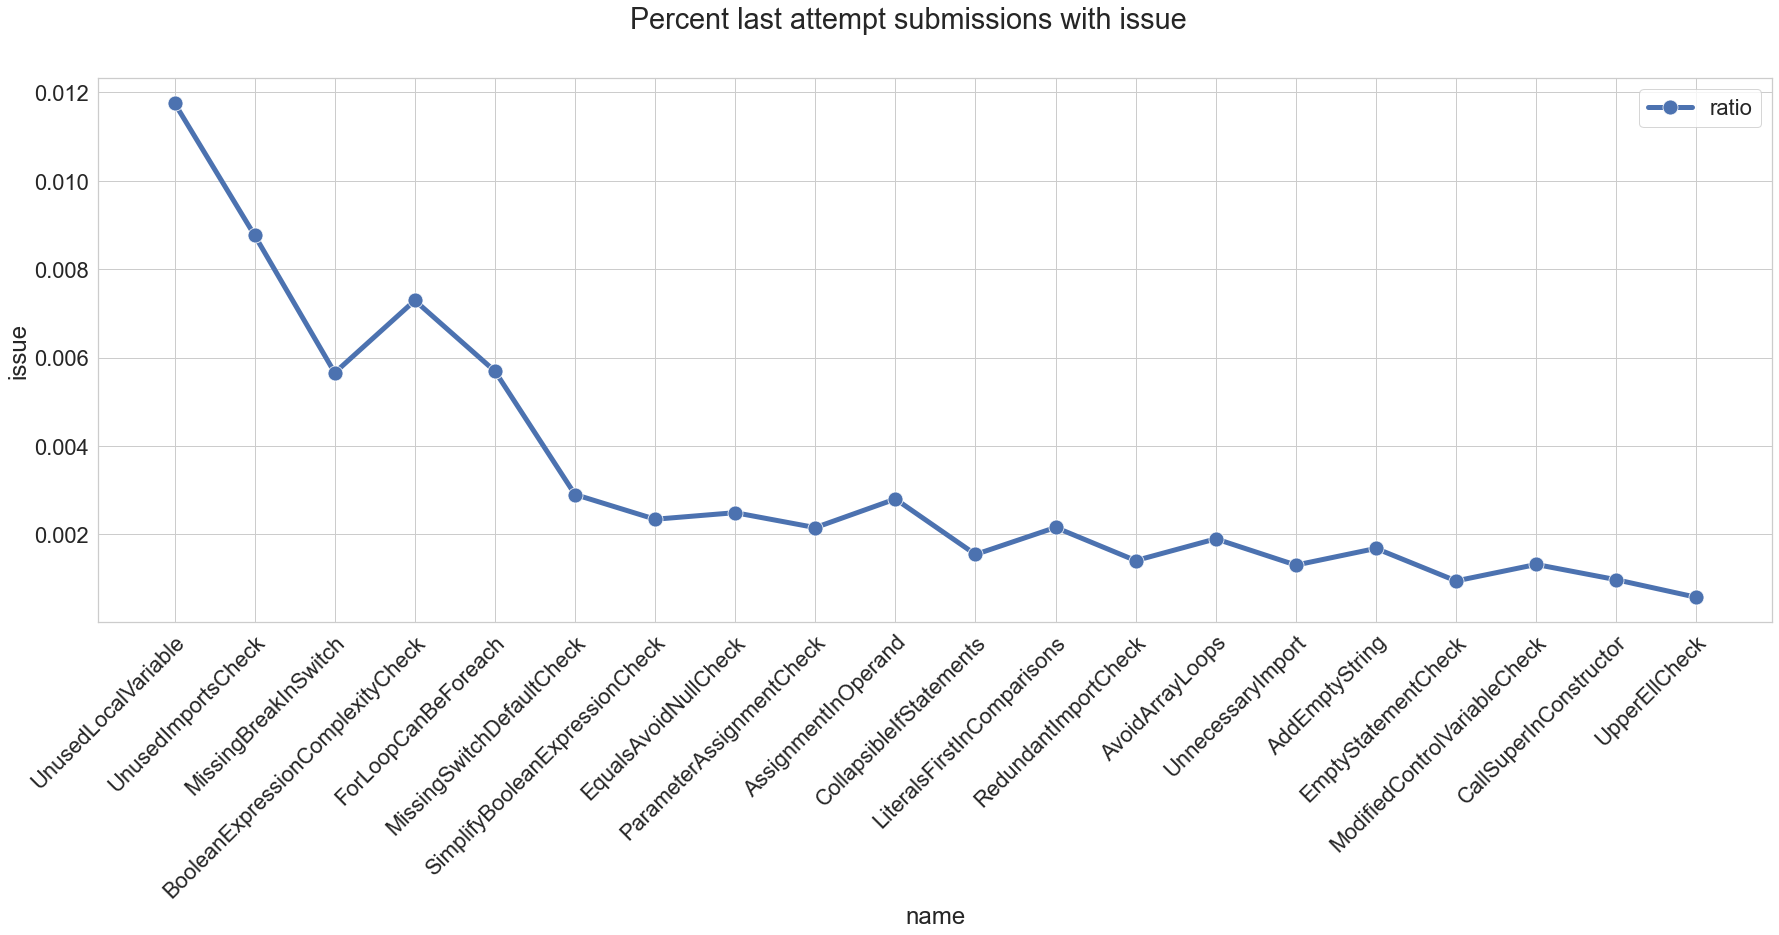

In [79]:
draw_compare(df_last_attempt_hyperstyle_issues_top, 'name', ['ratio', ['ratio']], 
             y_label='issue', 
             title='Percent last attempt submissions with issue', 
             save_path=os.path.join(LAST_ATTEMPT_STATS_PATH, f'top_issues.pdf'))

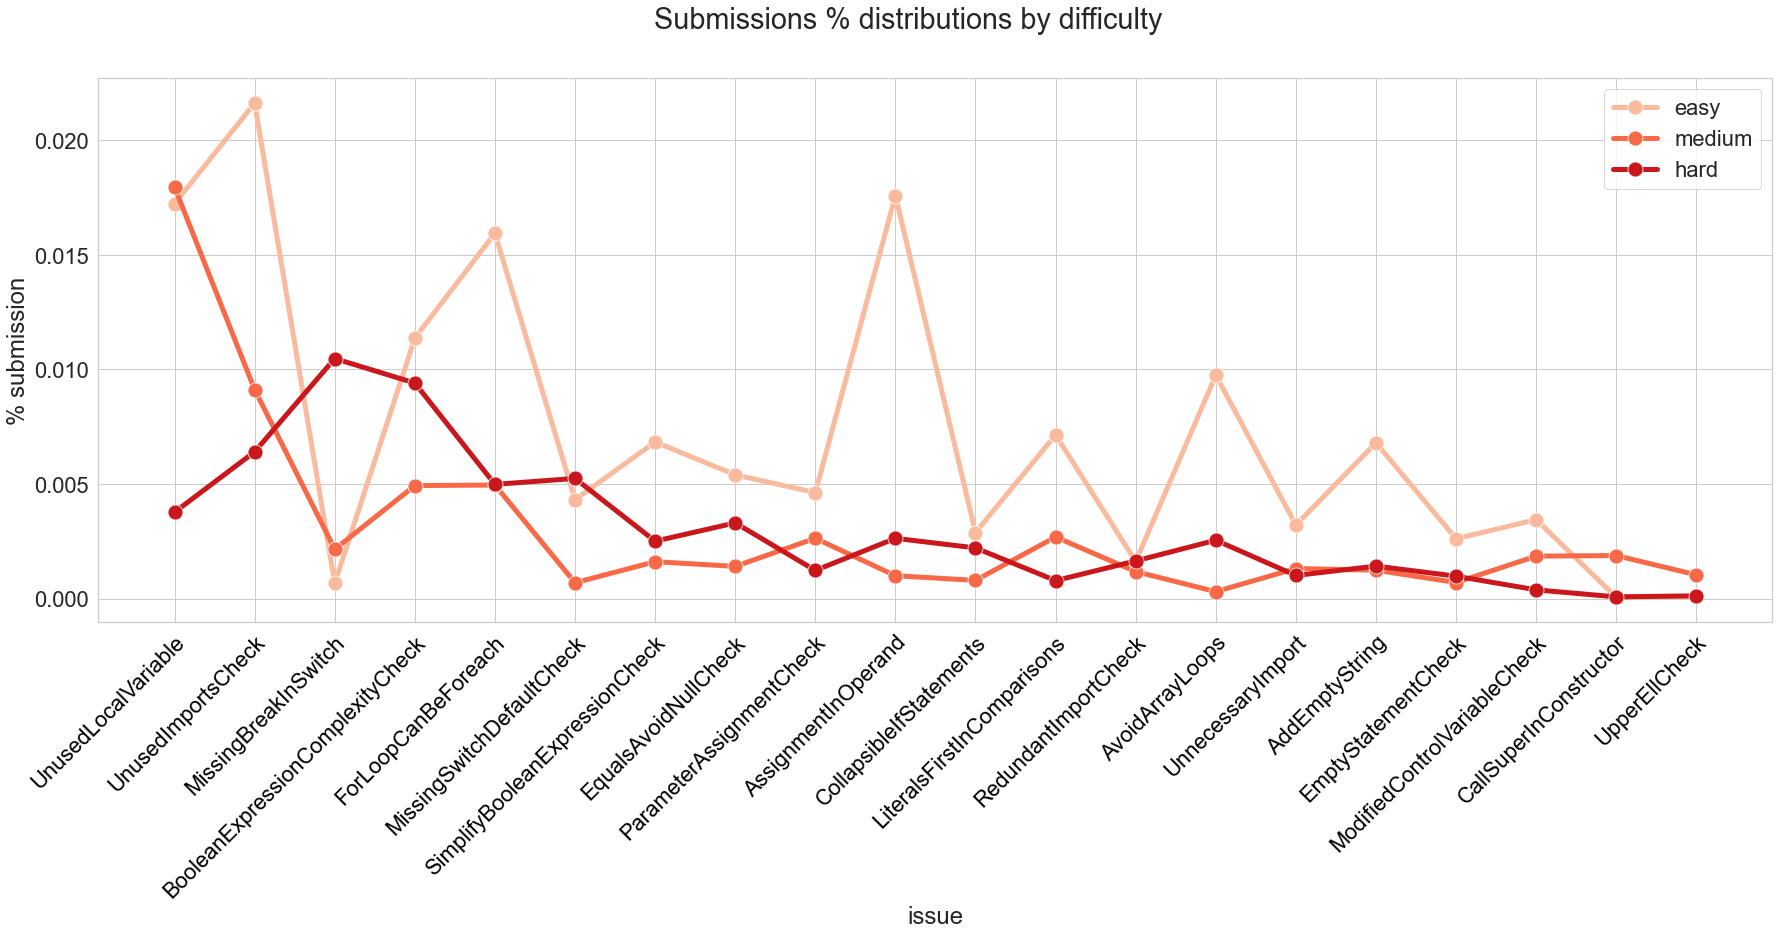

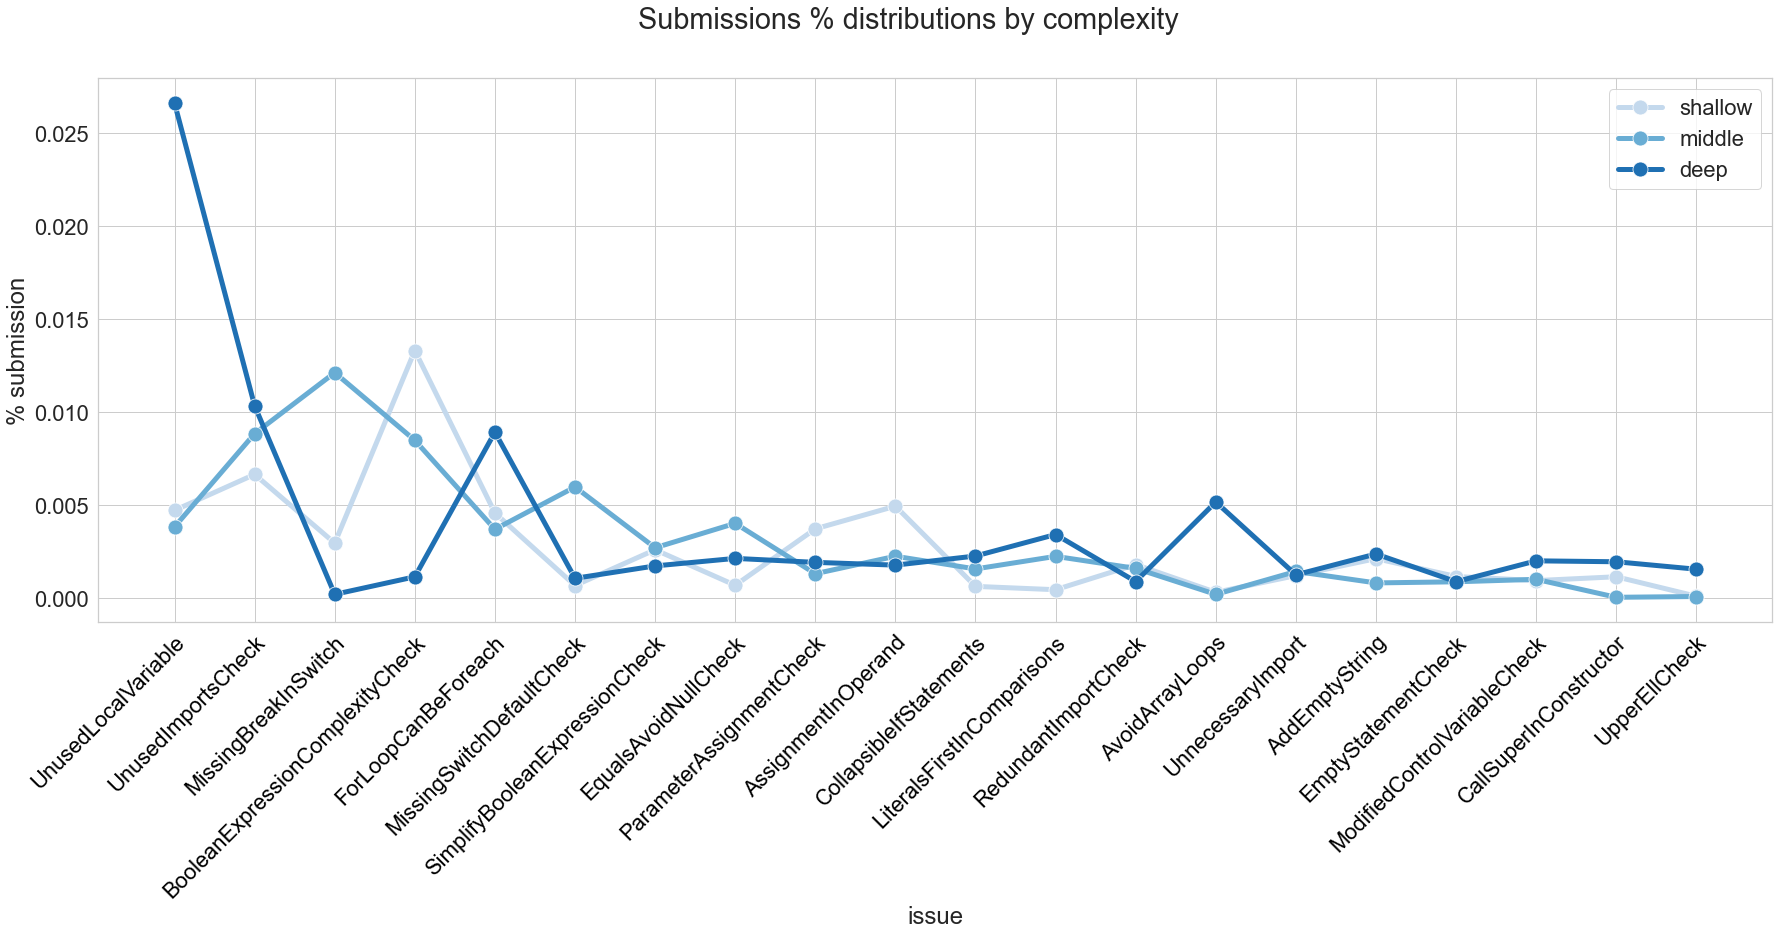

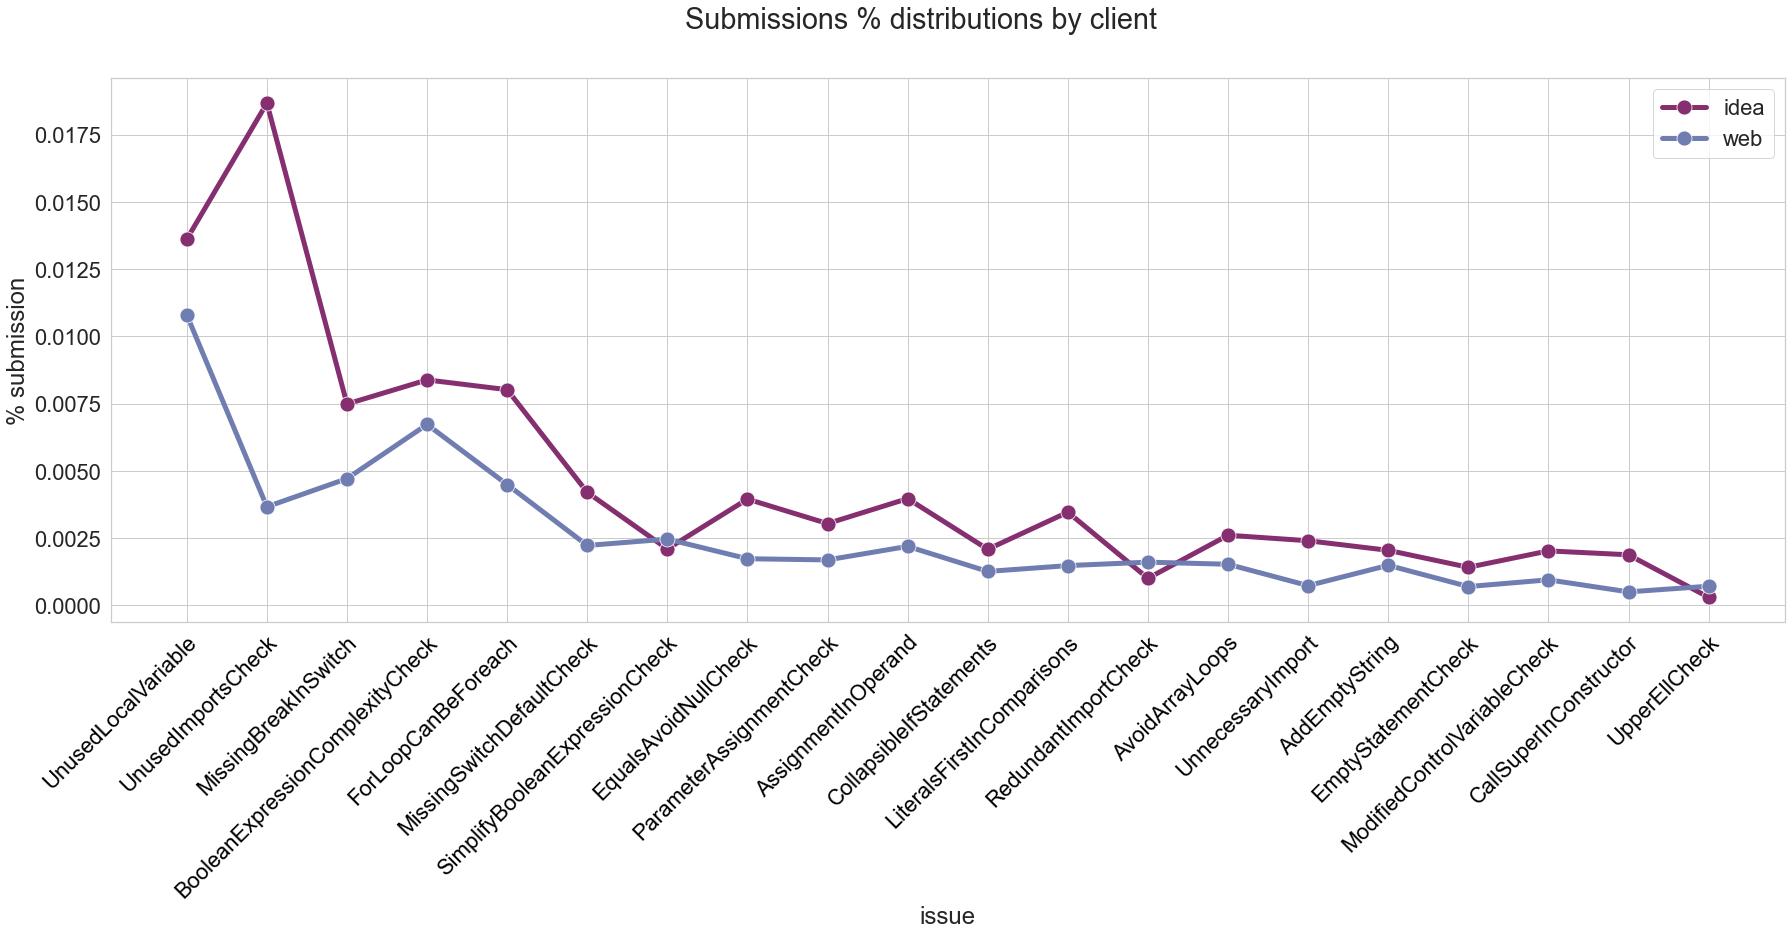

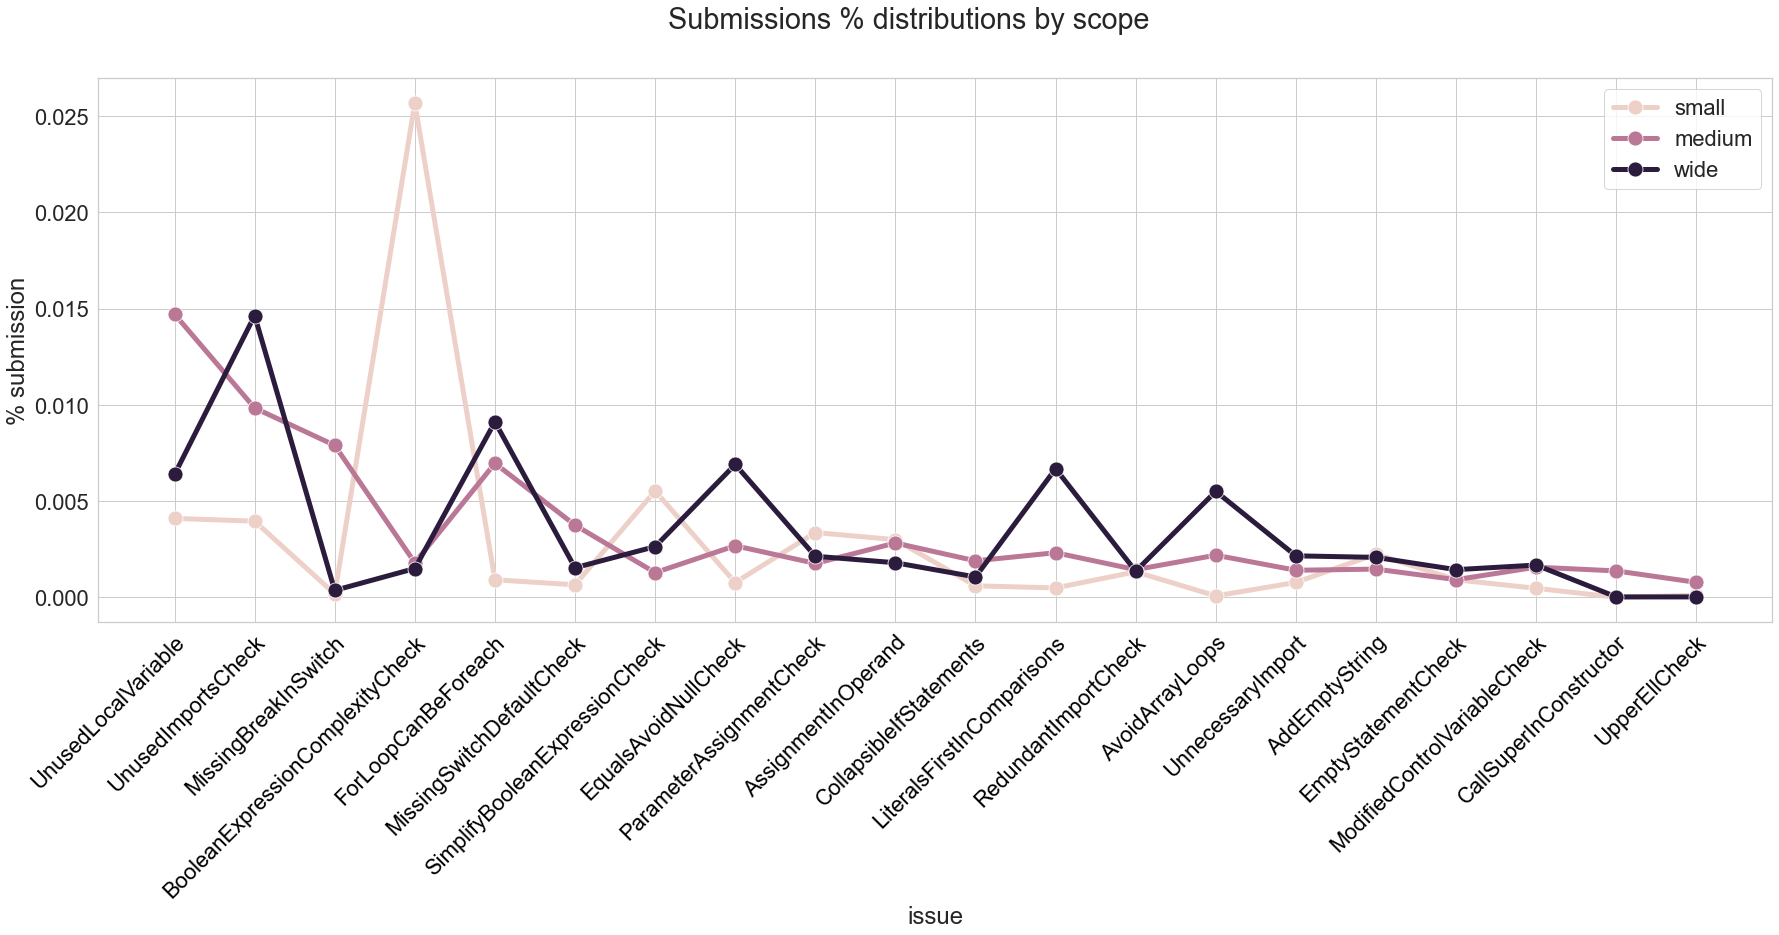

In [80]:
draw_issues(df_last_attempt_hyperstyle_issues_stats_unique, 
            df_first_attempt_hyperstyle_issues_top, 
            hyperstyle_issues_info_names,
            base_dir=LAST_ATTEMPT_STATS_PATH)

In [81]:
df_single_attempt_hyperstyle_issues_top = get_top_issues(
    df_first_attempt_hyperstyle_issues_stats_unique[df_first_attempt_hyperstyle_issues_stats_unique['total_attempts'] == 1],
    df_first_attempt_hyperstyle_issues_top, 
    len(df_first_attempt_hyperstyle_issues_top), 
    hyperstyle_issues_ignore_names)

df_single_attempt_hyperstyle_issues_top = sort_by_order(df_single_attempt_hyperstyle_issues_top,
                                                      'name',
                                                      df_first_attempt_hyperstyle_issues_top['name'].values)
                                                       
df_single_attempt_hyperstyle_issues_top.to_csv(os.path.join(FIRST_LAST_ATTEMPT_STATS_PATH, 
                                                            f'single_attempt_top_issues.csv'), index=False)
df_single_attempt_hyperstyle_issues_top


name  count        category  \
0                UnusedLocalVariable   8349  BEST_PRACTICES   
1                 UnusedImportsCheck   6503  BEST_PRACTICES   
2               MissingBreakInSwitch   4163     ERROR_PRONE   
3   BooleanExpressionComplexityCheck   4274  BEST_PRACTICES   
4                ForLoopCanBeForeach   3883  BEST_PRACTICES   
5          MissingSwitchDefaultCheck   2192     ERROR_PRONE   
6     SimplifyBooleanExpressionCheck   1562  BEST_PRACTICES   
7               EqualsAvoidNullCheck   1784  BEST_PRACTICES   
8           ParameterAssignmentCheck   1529  BEST_PRACTICES   
9                AssignmentInOperand   1560     ERROR_PRONE   
10           CollapsibleIfStatements   1084  BEST_PRACTICES   
11        LiteralsFirstInComparisons   1315  BEST_PRACTICES   
12              RedundantImportCheck   1022  BEST_PRACTICES   
13                   AvoidArrayLoops   1148  BEST_PRACTICES   
14                 UnnecessaryImport    963  BEST_PRACTICES   
15                    AddEmptyString    971  BEST_PRACTICES   
16               EmptyStatementCheck    697     ERROR_PRONE   
17      ModifiedControlVariableCheck    804  BEST_PRACTICES   
18            CallSuperInConstructor    704  BEST_PRACTICES   
19                     UpperEllCheck    461  BEST_PRACTICES   

                                                 text difficulty  \
0        Avoid unused local variables such as 'unit'.     MEDIUM   
1                    Unused import - javax.print.Doc.     MEDIUM   
2         A switch statement does not contain a break       HARD   
3   Too long boolean expression. Try to split it i...       EASY   
4     This for loop can be replaced by a foreach loop     MEDIUM   
5                    switch without "default" clause.       HARD   
6                       Expression can be simplified.     MEDIUM   
7   String literal expressions should be on the le...     MEDIUM   
8      Assignment of parameter 'str1' is not allowed.     MEDIUM   
9                       Avoid assignments in operands       HARD   
10  These nested if statements could be combined b...     MEDIUM   
11      Position literals first in String comparisons     MEDIUM   
12  Redundant import from the java.lang package - ...     MEDIUM   
13                 System.arraycopy is more efficient     MEDIUM   
14                 Unused import 'java.util.stream.*'     MEDIUM   
15                           Do not add empty strings     MEDIUM   
16                                   Empty statement.       HARD   
17                  Control variable 'j' is modified.     MEDIUM   
18  It is a good practice to call super() in a con...     MEDIUM   
19                          Should use uppercase 'L'.     MEDIUM   

                                          code_sample     ratio  
0   import javax.print.Doc;\n\nclass Army {\n\n   ...  0.012430  
1   import javax.print.Doc; // UnusedImportsCheck ...  0.009682  
2   import java.util.Scanner;\n\nclass Main {\n   ...  0.006198  
3   import java.util.*;\n\npublic class Main {\n  ...  0.006363  
4   import java.util.Scanner;\n\nclass Main {\n   ...  0.005781  
5   import java.util.Scanner;\n\nclass Main {\n   ...  0.003263  
6   import java.util.Scanner;\n\nclass Main {\n   ...  0.002325  
7   import java.util.Scanner;\nclass Main {\n    s...  0.002656  
8   import java.util.Scanner;\n\n\npublic class Ma...  0.002276  
9   import java.io.BufferedReader;\nimport java.io...  0.002323  
10  import java.util.Scanner;\n\nclass Main {\n   ...  0.001614  
11  import java.util.Scanner;\n\nclass Main {\n   ...  0.001958  
12  import java.util.*;\nimport java.lang.*; // Re...  0.001522  
13  import java.util.Scanner;\n\nclass SelectionCo...  0.001709  
14   import java.util.*;\n import java.util.stream...  0.001434  
15  import java.util.*;\nclass Main {\n    public ...  0.001446  
16  public class Main {\n\n    public static void ...  0.001038  
17  import java.util.Scanner;\n\nclass Concatenate...  0.001197  
18  import java.util.Loca

In [82]:
df_first_last_attempt_hyperstyle_issues_top = pd.merge(
    df_first_attempt_hyperstyle_issues_top[['name', 'count', 'category']], 
    df_last_attempt_hyperstyle_issues_top[['name', 'count', 'category']], 
    left_on=['name', 'category'], right_on=['name', 'category'], suffixes=('_first', '_last'))

df_first_last_attempt_hyperstyle_issues_top = pd.merge(
    df_first_last_attempt_hyperstyle_issues_top, 
    df_single_attempt_hyperstyle_issues_top[['name', 'count', 'category']].rename(
        columns={'count': 'count_single_attempt', 'ratio': 'ratio_single_attempt'}),
    left_on=['name', 'category'], right_on=['name', 'category'])

df_first_last_attempt_hyperstyle_issues_top

name  count_first        category  count_last  \
0                UnusedLocalVariable        15275  BEST_PRACTICES        9812   
1                 UnusedImportsCheck        12089  BEST_PRACTICES        7315   
2               MissingBreakInSwitch         7189     ERROR_PRONE        4721   
3   BooleanExpressionComplexityCheck         7156  BEST_PRACTICES        6085   
4                ForLoopCanBeForeach         6577  BEST_PRACTICES        4750   
5          MissingSwitchDefaultCheck         3666     ERROR_PRONE        2421   
6     SimplifyBooleanExpressionCheck         2953  BEST_PRACTICES        1954   
7               EqualsAvoidNullCheck         2859  BEST_PRACTICES        2078   
8           ParameterAssignmentCheck         2604  BEST_PRACTICES        1796   
9                AssignmentInOperand         2240     ERROR_PRONE        2336   
10           CollapsibleIfStatements         2050  BEST_PRACTICES        1289   
11        LiteralsFirstInComparisons         1994  BEST_PRACTICES        1799   
12              RedundantImportCheck         1925  BEST_PRACTICES        1173   
13                   AvoidArrayLoops         1901  BEST_PRACTICES        1584   
14                 UnnecessaryImport         1705  BEST_PRACTICES        1088   
15                    AddEmptyString         1422  BEST_PRACTICES        1403   
16               EmptyStatementCheck         1372     ERROR_PRONE         789   
17      ModifiedControlVariableCheck         1335  BEST_PRACTICES        1100   
18            CallSuperInConstructor          818  BEST_PRACTICES         812   
19                     UpperEllCheck          697  BEST_PRACTICES         480   

    count_single_attempt  
0                   8349  
1                   6503  
2                   4163  
3                   4274  
4                   3883  
5                   2192  
6                   1562  
7                   1784  
8                   1529  
9                   1560  
10                  1084  
11                  1315  
12                  1022  
13                  1148  
14                   963  
15                   971  
16                   697  
17                   804  
18                   704  
19                   461

In [83]:
df_first_last_attempt_hyperstyle_issues_top['count_first_not_single'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_first'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_single_attempt']

df_first_last_attempt_hyperstyle_issues_top['count_last_not_single'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_last'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_single_attempt']
    
df_first_last_attempt_hyperstyle_issues_top['count_diff'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_first_not_single'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_last_not_single']

df_first_last_attempt_hyperstyle_issues_top['ratio_left'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_last_not_single'] / \
    df_first_last_attempt_hyperstyle_issues_top['count_first_not_single']

df_first_last_attempt_hyperstyle_issues_top = df_first_last_attempt_hyperstyle_issues_top \
    .sort_values(by='ratio_left')

df_first_last_attempt_hyperstyle_issues_top.to_csv(os.path.join(FIRST_LAST_ATTEMPT_STATS_PATH, 
                                                                f'top_issues.csv'), index=False)
df_first_last_attempt_hyperstyle_issues_top

name  count_first        category  count_last  \
19                     UpperEllCheck          697  BEST_PRACTICES         480   
16               EmptyStatementCheck         1372     ERROR_PRONE         789   
1                 UnusedImportsCheck        12089  BEST_PRACTICES        7315   
5          MissingSwitchDefaultCheck         3666     ERROR_PRONE        2421   
12              RedundantImportCheck         1925  BEST_PRACTICES        1173   
14                 UnnecessaryImport         1705  BEST_PRACTICES        1088   
2               MissingBreakInSwitch         7189     ERROR_PRONE        4721   
0                UnusedLocalVariable        15275  BEST_PRACTICES        9812   
10           CollapsibleIfStatements         2050  BEST_PRACTICES        1289   
8           ParameterAssignmentCheck         2604  BEST_PRACTICES        1796   
7               EqualsAvoidNullCheck         2859  BEST_PRACTICES        2078   
6     SimplifyBooleanExpressionCheck         2953  BEST_PRACTICES        1954   
4                ForLoopCanBeForeach         6577  BEST_PRACTICES        4750   
17      ModifiedControlVariableCheck         1335  BEST_PRACTICES        1100   
13                   AvoidArrayLoops         1901  BEST_PRACTICES        1584   
3   BooleanExpressionComplexityCheck         7156  BEST_PRACTICES        6085   
11        LiteralsFirstInComparisons         1994  BEST_PRACTICES        1799   
18            CallSuperInConstructor          818  BEST_PRACTICES         812   
15                    AddEmptyString         1422  BEST_PRACTICES        1403   
9                AssignmentInOperand         2240     ERROR_PRONE        2336   

    count_single_attempt  count_first_not_single  count_last_not_single  \
19                   461                     236                     19   
16                   697                     675                     92   
1                   6503                    5586                    812   
5                   2192                    1474                    229   
12                  1022                     903                    151   
14                   963                     742                    125   
2                   4163                    3026                    558   
0                   8349                    6926                   1463   
10                  1084                     966                    205   
8                   1529                    1075                    267   
7                   1784                    1075                    294   
6                   1562                    1391                    392   
4                   3883                    2694                    867   
17                   804                     531                    296   
13                  1148                     753                    436   
3                   4274                    2882                   1811   
11                  1315                     679                    484   
18                   704                     114                    108   
15                   971                     451                    432   
9                   1560                     680                    776   

    count_diff  ratio_left  
19         217    0.080508  
16         583    0.136296  
1         4774    0.145363  
5         1245    0.155360  
12         752    0.167220  
14         617    0.168464  
2         2468    0.184402  
0         5463    0.211233  
10         761    0.212215  
8          808    0.248372  
7          781    0.273488  
6          999    0.281812  
4         1827    0.321826  
17         235    0.557439  
13         317    0.579017  
3         1071    0.628383  
11         195    0.712813  
18           6    0.947368  
15          19    0.957871  
9          -96    1.141176

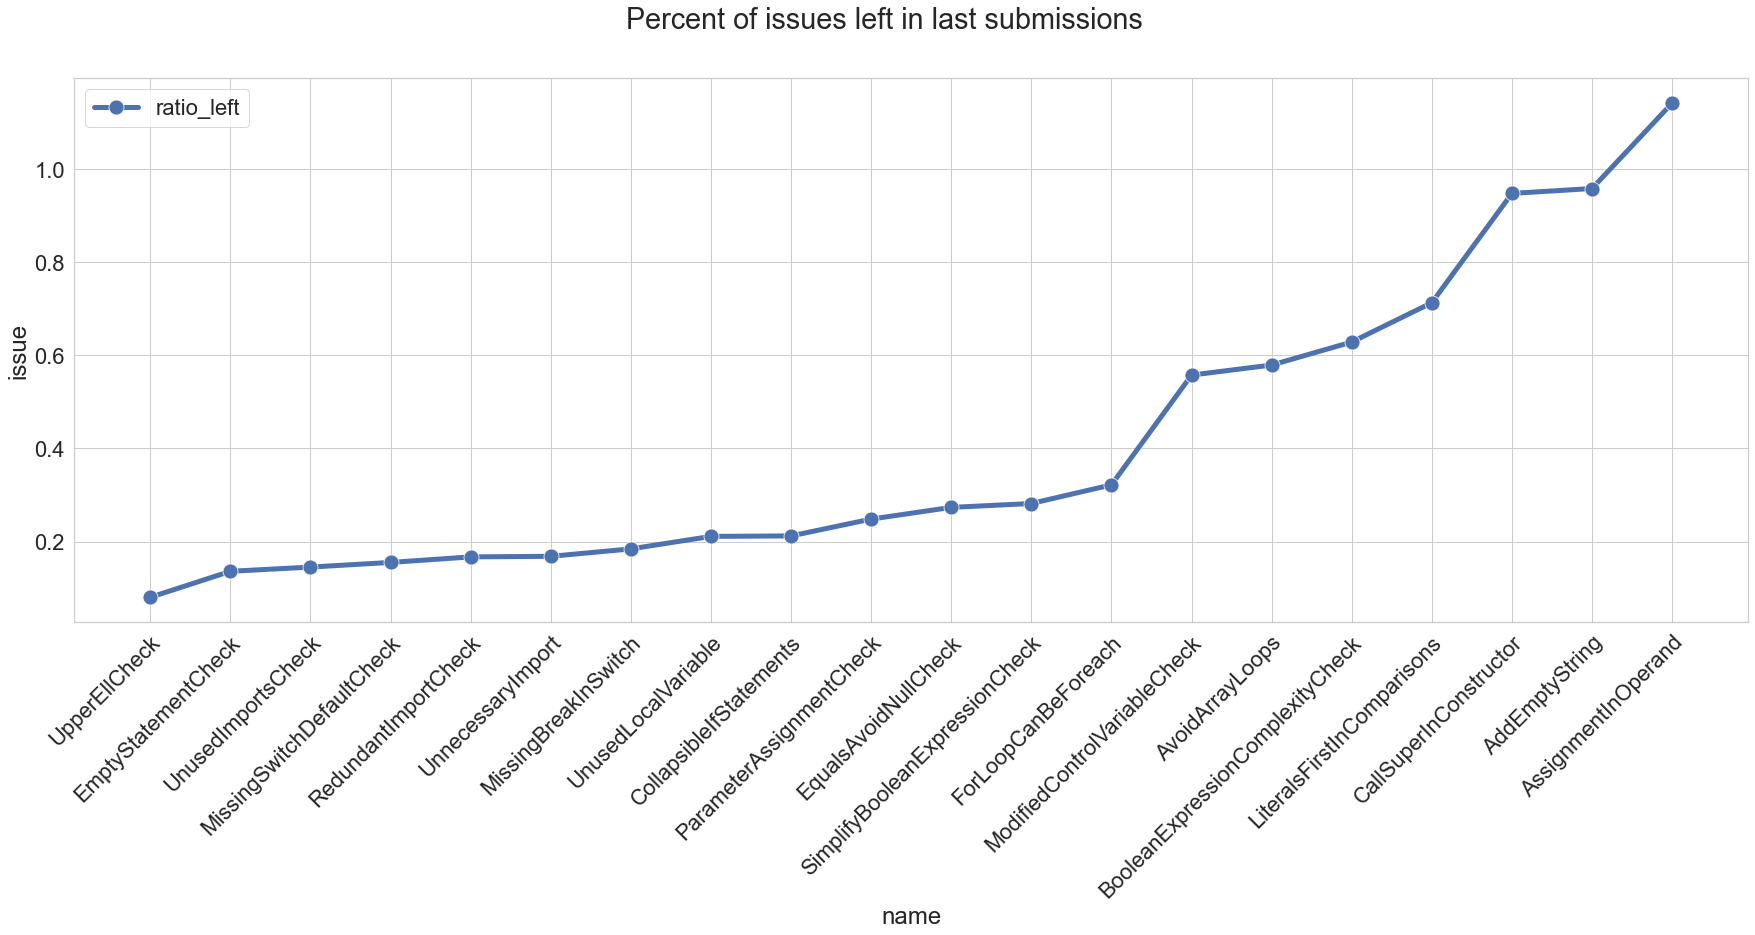

In [84]:
draw_compare(df_first_last_attempt_hyperstyle_issues_top, 
             'name', ['ratio', ['ratio_left']], 
             y_label='issue', 
             title='Percent of issues left in last submissions', 
             save_path=os.path.join(FIRST_LAST_ATTEMPT_STATS_PATH, f'top_issues.pdf'))

In [217]:
df_first_last_attempt_hyperstyle_issues_top['count_first'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_first'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_single_attempt']

df_first_last_attempt_hyperstyle_issues_top['count_last'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_last'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_single_attempt']
    
df_first_last_attempt_hyperstyle_issues_top['count_diff'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_first'] - \
    df_first_last_attempt_hyperstyle_issues_top['count_last']

df_first_last_attempt_hyperstyle_issues_top['ratio_left'] = \
    df_first_last_attempt_hyperstyle_issues_top['count_last'] / \
    df_first_last_attempt_hyperstyle_issues_top['count_first']

df_first_last_attempt_hyperstyle_issues_top = df_first_last_attempt_hyperstyle_issues_top \
    .sort_values(by='ratio_left')

df_first_last_attempt_hyperstyle_issues_top.to_csv(os.path.join(FIRST_LAST_ATTEMPT_STATS_PATH, 
                                                                f'top_issues.csv'), index=False)
df_first_last_attempt_hyperstyle_issues_top

name  count_first        category  count_last  \
17               EmptyStatementCheck          704     ERROR_PRONE          94   
1                 UnusedImportsCheck         6181  BEST_PRACTICES         878   
5          MissingSwitchDefaultCheck         1691     ERROR_PRONE         261   
14              RedundantImportCheck          894  BEST_PRACTICES         140   
15          UseShortArrayInitializer          808  BEST_PRACTICES         133   
9                  UnnecessaryImport          954  BEST_PRACTICES         170   
2               MissingBreakInSwitch         3328     ERROR_PRONE         621   
0                UnusedLocalVariable         7740  BEST_PRACTICES        1579   
12           CollapsibleIfStatements          975  BEST_PRACTICES         207   
8           ParameterAssignmentCheck         1076  BEST_PRACTICES         260   
7               EqualsAvoidNullCheck         1082  BEST_PRACTICES         296   
6     SimplifyBooleanExpressionCheck         1366  BEST_PRACTICES         382   
4                ForLoopCanBeForeach         2843  BEST_PRACTICES         903   
19      ModifiedControlVariableCheck          533  BEST_PRACTICES         289   
13                   AvoidArrayLoops          763  BEST_PRACTICES         445   
3   BooleanExpressionComplexityCheck         2946  BEST_PRACTICES        1838   
10        LiteralsFirstInComparisons          762  BEST_PRACTICES         571   
16                    AddEmptyString          485  BEST_PRACTICES         466   
18            CallSuperInConstructor          173  BEST_PRACTICES         168   
11               AssignmentInOperand          700     ERROR_PRONE         808   

    count_single_attempt  count_diff  ratio_left  
17                   744         610    0.133523  
1                   7403        5303    0.142048  
5                   2398        1430    0.154347  
14                   992         754    0.156600  
15                   909         675    0.164604  
9                   1418         784    0.178197  
2                   4511        2707    0.186599  
0                   9392        6161    0.204005  
12                  1096         768    0.212308  
8                   1505         816    0.241636  
7                   1760         786    0.273567  
6                   1512         984    0.279649  
4                   4207        1940    0.317622  
19                   798         244    0.542214  
13                  1169         318    0.583224  
3                   4352        1108    0.623897  
10                  1590         191    0.749344  
16                  1058          19    0.960825  
18                  1185           5    0.971098  
11                  1639        -108    1.154286

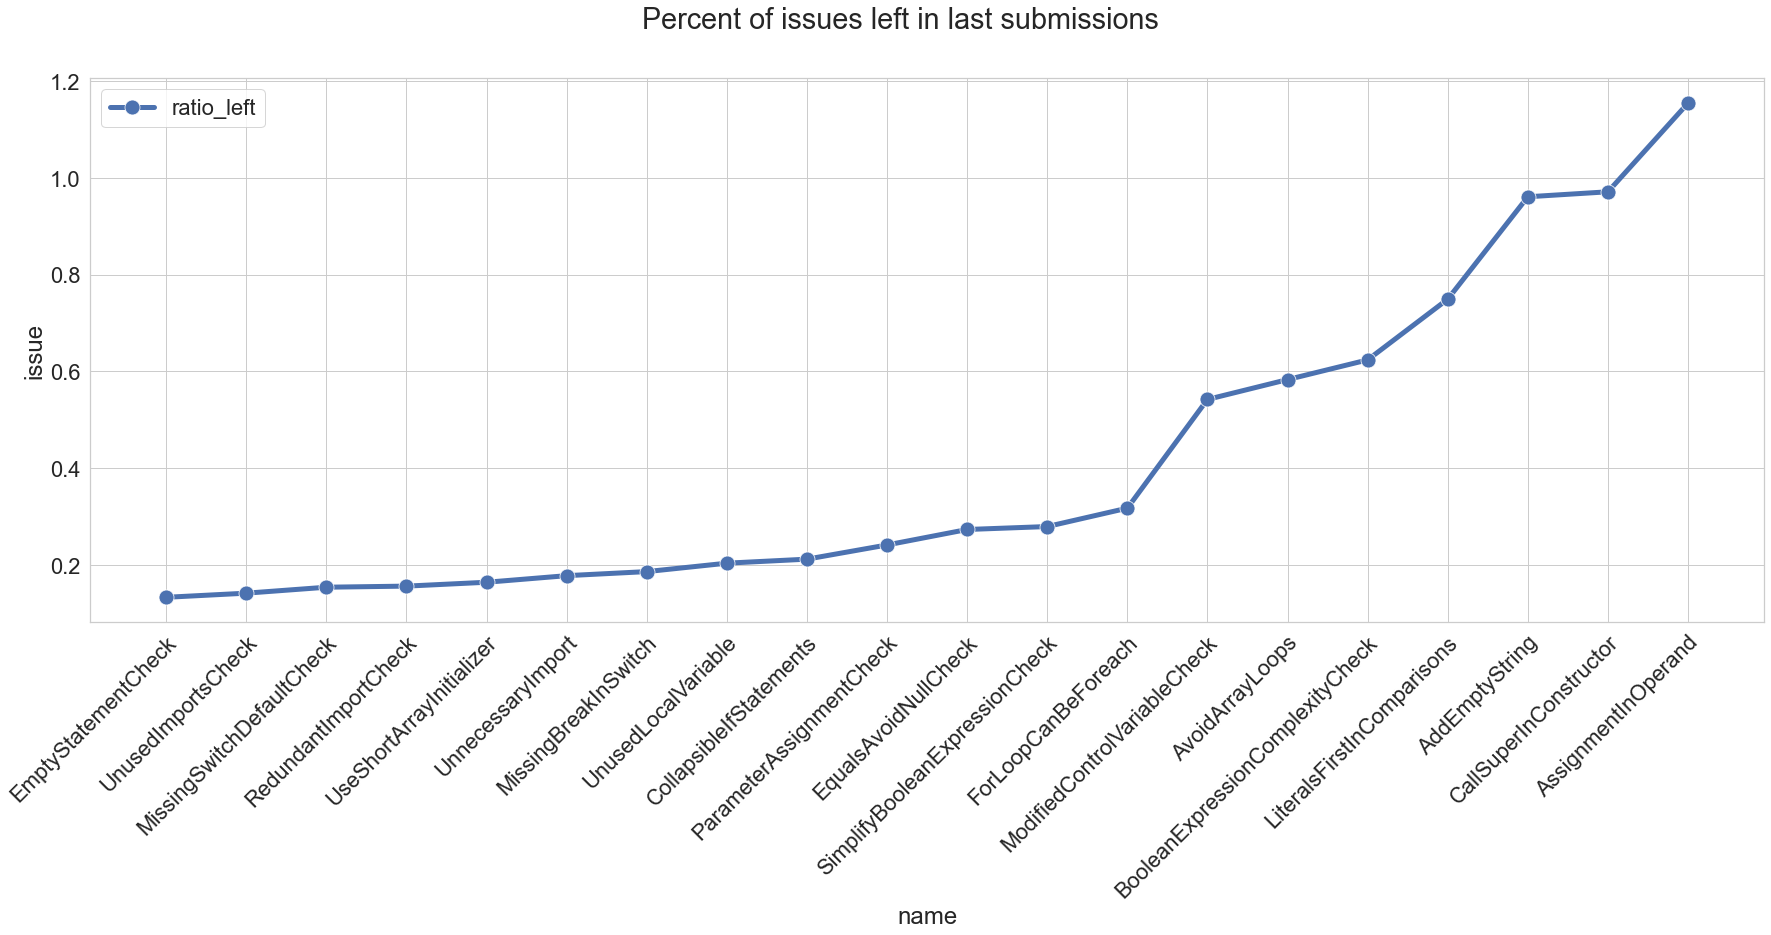

In [219]:
draw_compare(df_first_last_attempt_hyperstyle_issues_top, 
             'name', ['ratio', ['ratio_left']], 
             y_label='issue', 
             title='Percent of issues left in last submissions', 
             save_path=os.path.join(FIRST_LAST_ATTEMPT_STATS_PATH, f'top_issues.pdf'))

# Submission series (groups) analysis
To pass the step user can make several attemps. The ordered sequence of attemps in **submission series**. In this section you can find analysis of the student progess on code quality issues fixing. 

### Number of submission series by total number of attempts in series

In [85]:
df_last_attempt_stats['total_attempts'].value_counts()

1    671688
2    110716
3     34140
4     12677
5      5354
Name: total_attempts, dtype: int64

In [95]:
def draw_feature_dynamic(feature: str, max_attempts: int = 5, exact_attempts: bool = False, is_mean=True):
    for attr in ['difficulty', 'complexity', 'client', 'scope']:
        df_dynamic = get_submissions_series_dynamic_by_feature(df_hyperstyle_issues_stats, feature, attr, 
                                                               max_attempts=max_attempts)
#         uncomment to save stats to csv
#         df_dynamic.to_csv(f'{feature}_dynamic_{attr}.csv', index=False)
        draw_compare(df_dynamic, 'attempt', attr, y_label=f'mean\n{feature}', title=f'{feature} dynamic by attemps')

## Average number of hyperstyle issues by each attempt
For all submission series, we calculate mean number of issues made on i-th attempt. The plots show that from attempt to attempt the number of issues in students’ solutions decreases, regardless of the parameters of the student, steps on environment.

`exact_attempts` - if True than only submissions with `total_attempt` == `max_attempts` (so the number of submission for each attempt is equal) are selected othwise `total_attempt` <= `max_attempts` (so the number of submission for each attempt is decreasing)

In [97]:
df_hyperstyle_issues_stats['hyperstyle_issues_count'] = \
    df_hyperstyle_issues_stats[df_hyperstyle_issues_top['name'].values].sum(axis=1)

df_hyperstyle_issues_stats['hyperstyle_issues_count'].value_counts()

0     981576
1      62394
2      14600
3       9129
10      1560
9       1359
4       1170
8        460
5        294
6        215
7        128
11        78
16        14
12        10
13         8
14         7
15         4
19         3
20         2
21         2
17         1
18         1
24         1
25         1
31         1
Name: hyperstyle_issues_count, dtype: int64

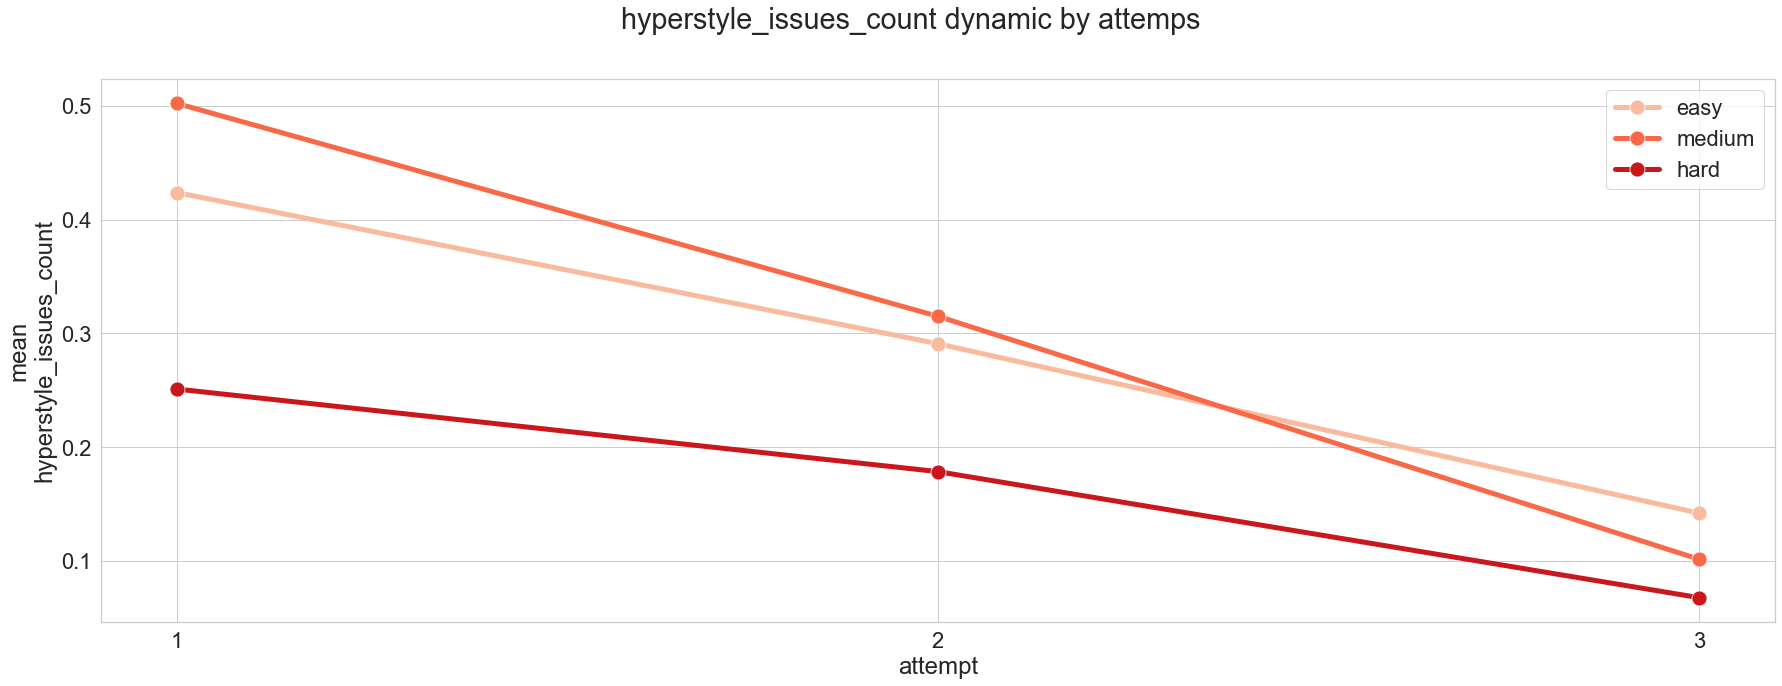

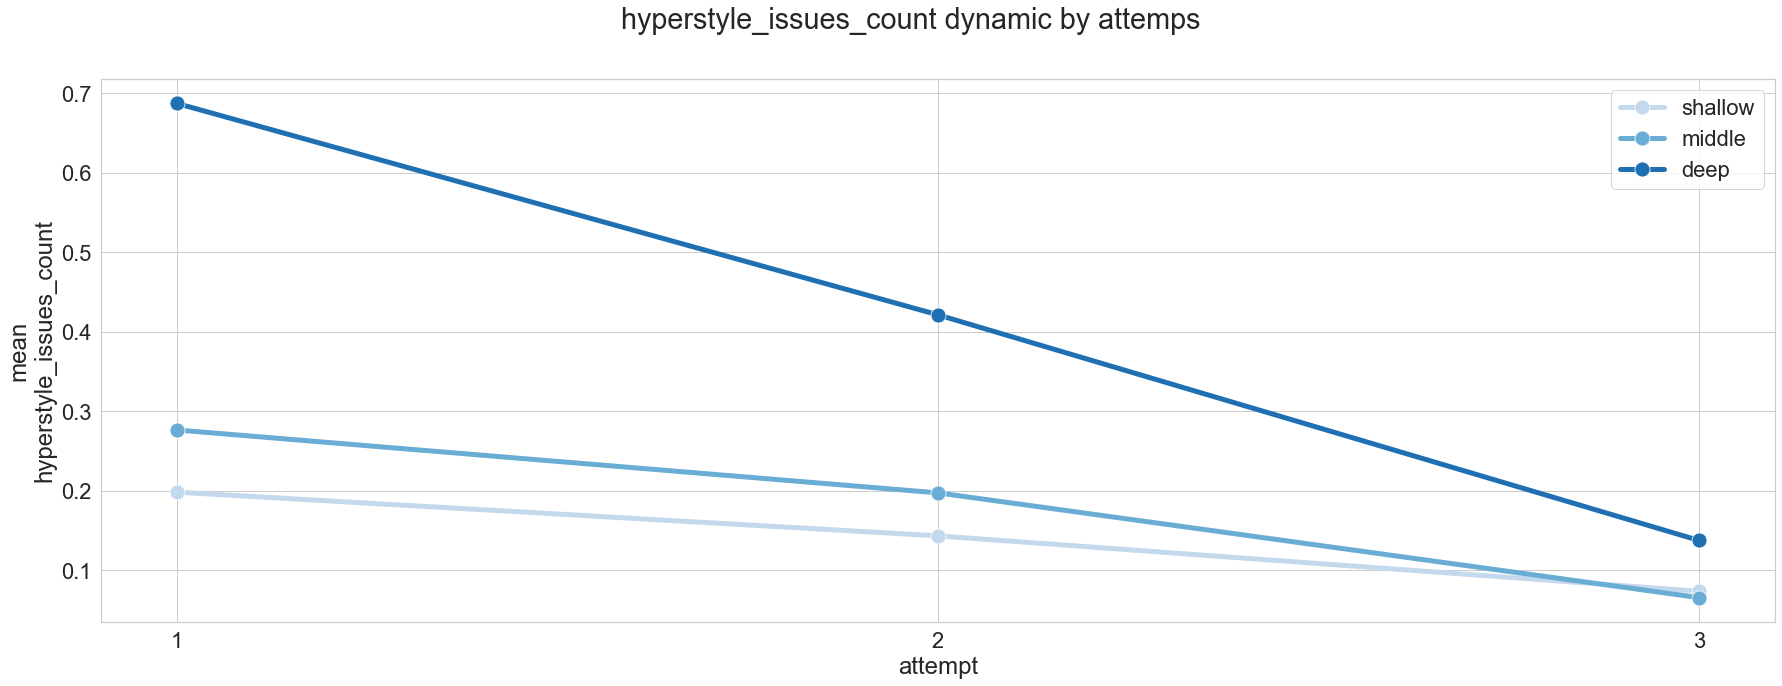

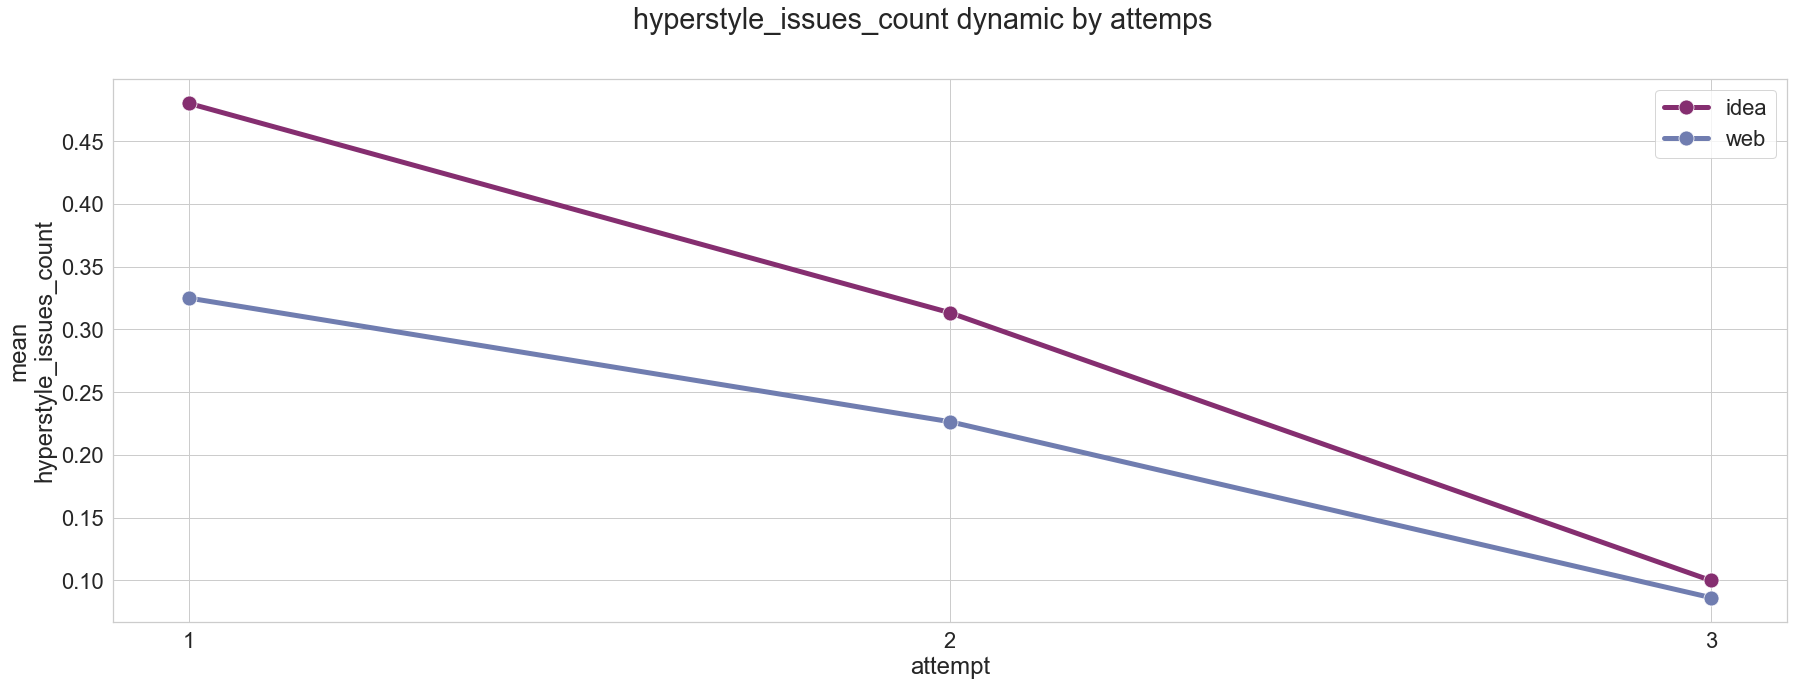

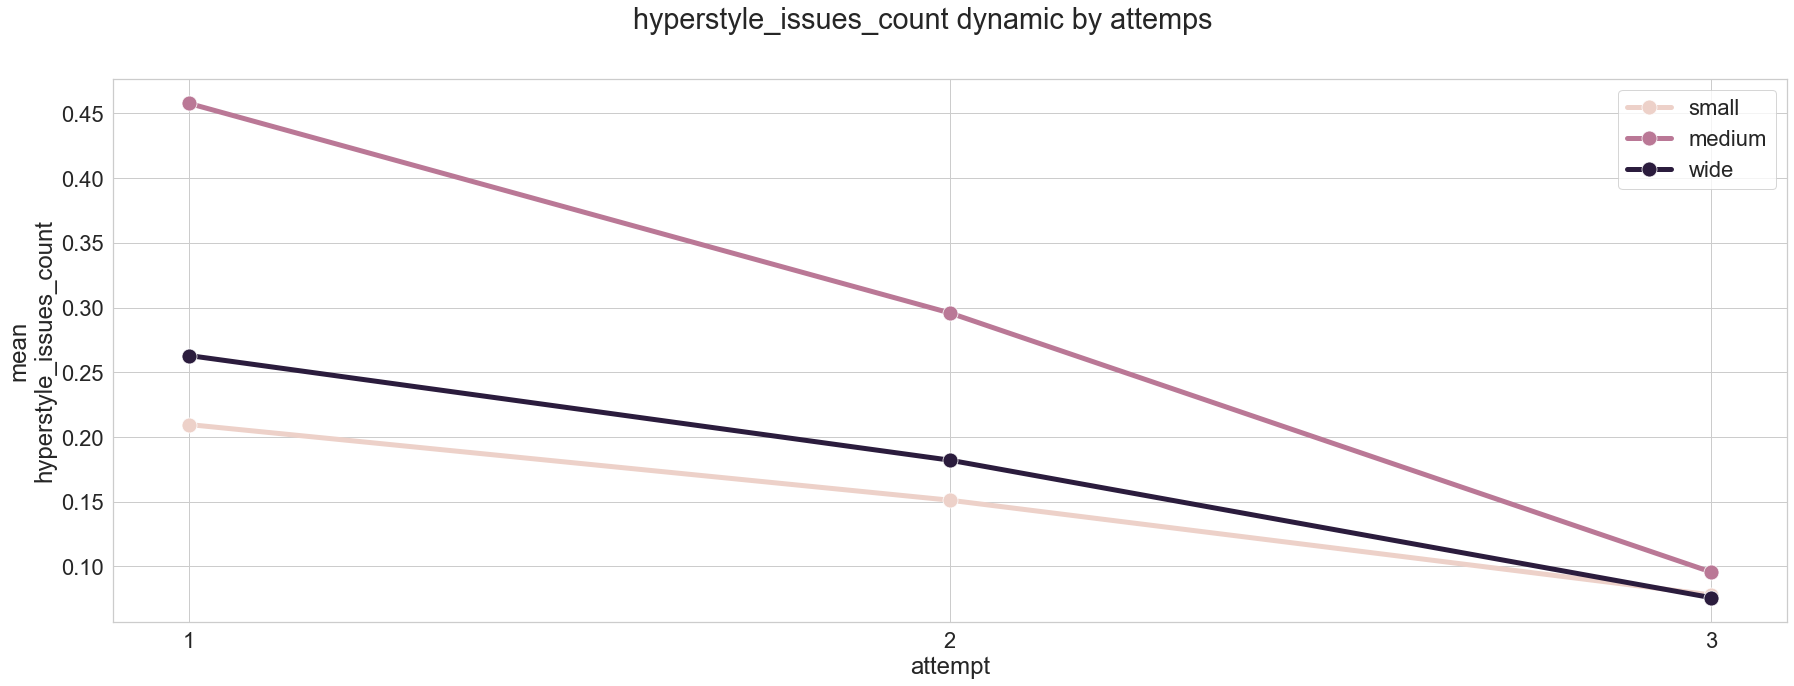

In [98]:
draw_feature_dynamic('hyperstyle_issues_count', max_attempts=3, exact_attempts=True)

## Submissions series dynamic
Plots show how average soution parameters change throught attemps 

### Dynamin for all sobmission series with total_attemps = 5

In [99]:
def draw_issues_dynamic(df: pd.DataFrame, df_issues: pd.DataFrame, max_attempts: int = 5,
                                          exact_attempts: bool = False, by_type=False, is_mean=True):
    df_issues_dynamic = get_submissions_series_issues_dynamic(df, df_issues, max_attempts, exact_attempts, 
                                                              by_type, is_mean)
    suffix = f'{max_attempts}' + ('_by_type' if by_type else '') + ('_exect' if exact_attempts else '')
    
    df_issues_dynamic.drop(columns=['attempt', 'count']).T \
        .to_csv(os.path.join(ISSUES_DYNAMIC_STATS_PATH, f'issues_dynamic_{suffix}.csv'), index=True)
    
    issues = df_issues['category' if by_type else 'name'].unique()
    draw_compare(df_issues_dynamic, 'attempt', ('issue', issues))
    return df_issues_dynamic.drop(columns=['attempt', 'count']).T

### Hypertyle issues dynamic by attempts (with issue names)
Percent of submission which contains each issue by attempts dynamic. The plot shows that in most cases all issues are decreras but it should be examined more precisely in csv file

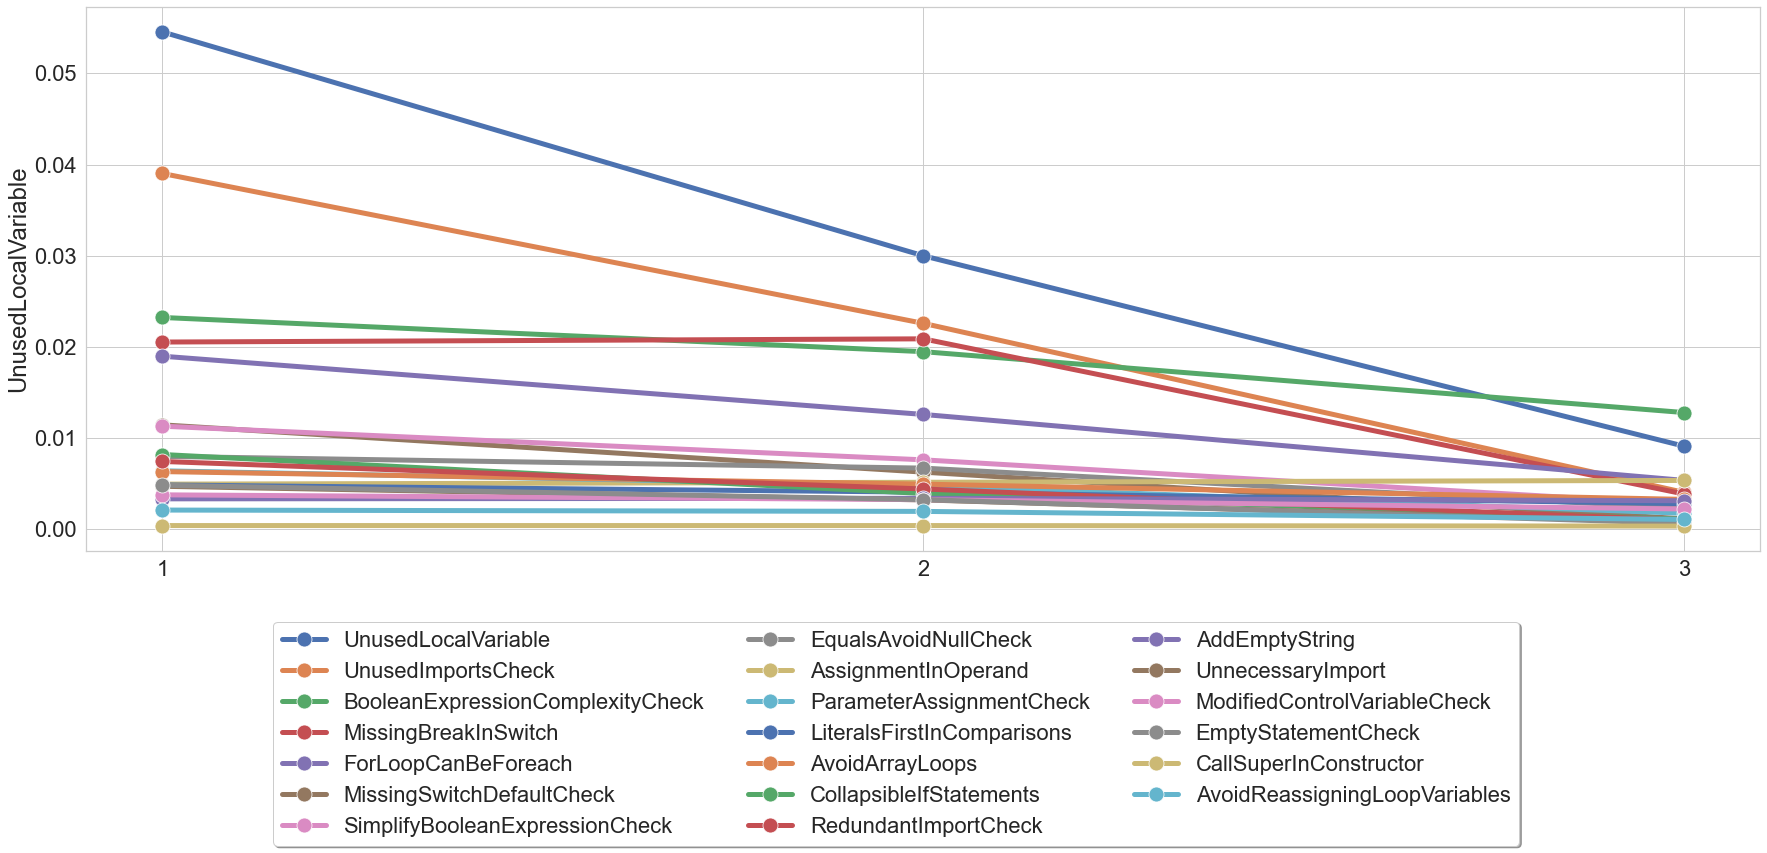

<Figure size 432x288 with 0 Axes>

0         1         2
UnusedLocalVariable               0.054540  0.029994  0.009110
UnusedImportsCheck                0.039016  0.022583  0.004042
BooleanExpressionComplexityCheck  0.023228  0.019479  0.012800
MissingBreakInSwitch              0.020533  0.020885  0.003866
ForLoopCanBeForeach               0.018981  0.012595  0.005360
MissingSwitchDefaultCheck         0.011453  0.006268  0.001142
SimplifyBooleanExpressionCheck    0.011306  0.007616  0.002753
EqualsAvoidNullCheck              0.007996  0.006708  0.002314
AssignmentInOperand               0.004950  0.005155  0.005360
ParameterAssignmentCheck          0.006415  0.004774  0.001757
LiteralsFirstInComparisons        0.004862  0.004071  0.002812
AvoidArrayLoops                   0.006327  0.004950  0.003281
CollapsibleIfStatements           0.008202  0.003925  0.001084
RedundantImportCheck              0.007440  0.004423  0.000996
AddEmptyString                    0.003339  0.003398  0.003134
UnnecessaryImport                 0.004716  0.003222  0.000762
ModifiedControlVariableCheck      0.003779  0.003251  0.002226
EmptyStatementCheck               0.004833  0.003251  0.000644
CallSuperInConstructor            0.000410  0.000410  0.000351
AvoidReassigningLoopVariables     0.002109  0.001963  0.001084

In [100]:
draw_issues_dynamic(df_hyperstyle_issues_stats_unique, 
                    df_hyperstyle_issues_top, 
                    max_attempts=3, 
                    exact_attempts=True)

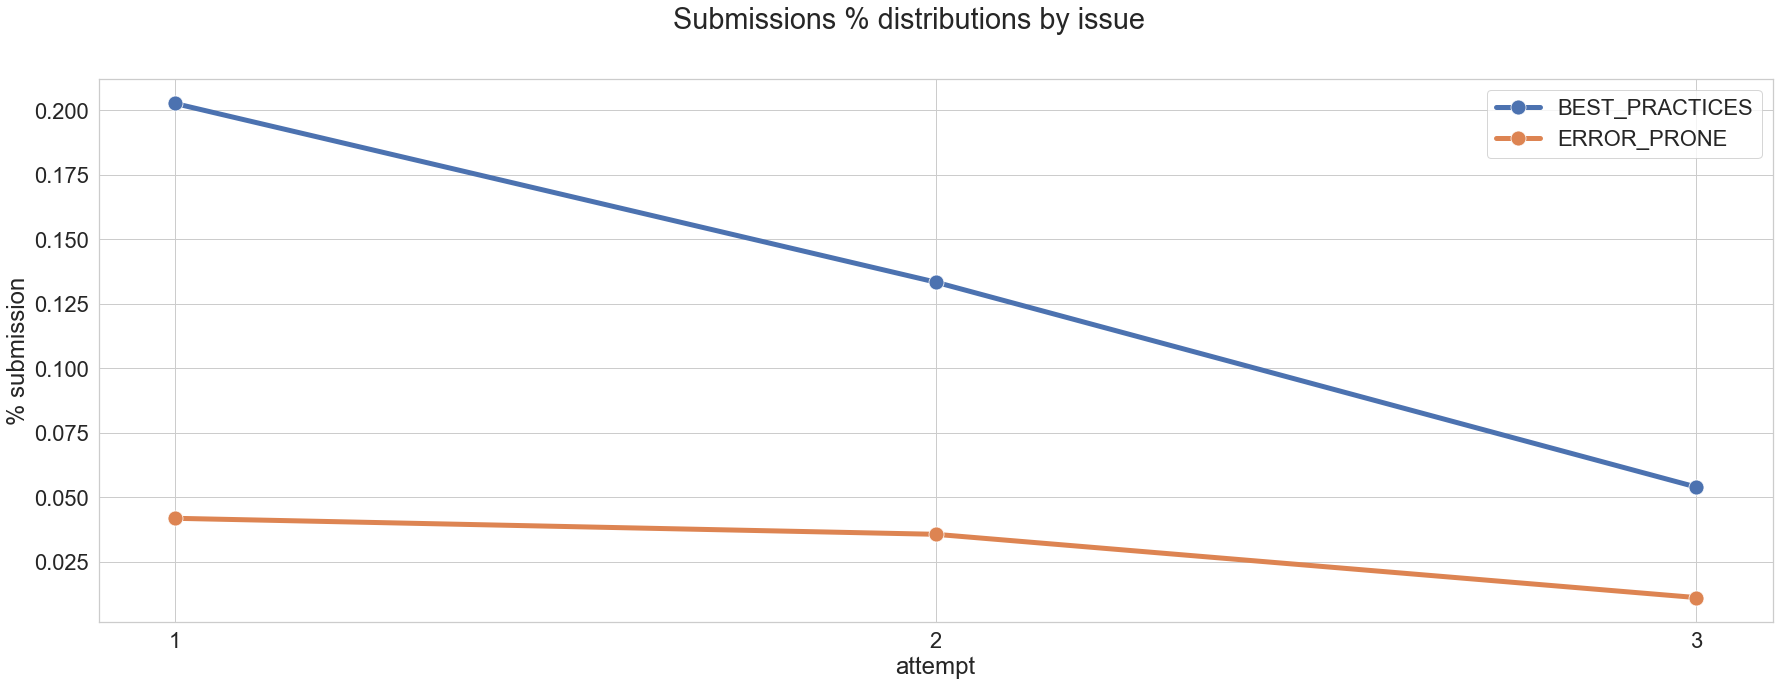

0         1         2
BEST_PRACTICES  0.202665  0.133363  0.053866
ERROR_PRONE     0.041769  0.035559  0.011013

In [101]:
draw_issues_dynamic(df_hyperstyle_issues_stats_unique, 
                    df_hyperstyle_issues_top, 
                    by_type=True, 
                    max_attempts=3, 
                    exact_attempts=True)